In [ ]:

#!pip install pyXSteam

In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import math
#from tkinter import Tk
#from tkinter.filedialog import askopenfilename
from decimal import Decimal, ROUND_HALF_UP
from pyXSteam.XSteam import XSteam
from matplotlib.ticker import MaxNLocator

import matplotlib as mpl, imageio_ffmpeg
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter

## Data Upload (.lvm file)

In [672]:
##### Dictionary to store DataFrames and file paths
dataframes = {}
file_paths = {}


# Common header skip value
skip = 22

# Base directory
base_dir = r"Y:\0_Ishraq\New Pool Boiling Video"

# ---- Ask user for Boiling ID ----
boiling_id = input("Enter the Boiling ID (e.g., 183): ").strip()
folder_name = f"Boiling-{boiling_id}"
folder_path = os.path.join(base_dir, folder_name)

# ---- Ask user for target pressure ----
Target_pressure_kPa = float(input("Enter the Target pressure in kPa: "))

# Ask the user for applied heat load
applied_heat_load = float(input("Enter applied heat load (W/cm^2): "))

# Check if folder exists
if not os.path.exists(folder_path):
    print(f"❌ Folder '{folder_name}' not found in {base_dir}")
    exit()

# ---- Define file names ----
files_to_load = {
    "Temperature": "Temperature.lvm",
    "Pressure": "Pressure.lvm"
}

# ---- Load files ----
for key, filename in files_to_load.items():
    file_path = os.path.join(folder_path, filename)
    if os.path.exists(file_path):
        try:
            df = pd.read_csv(file_path, skiprows=skip, sep='\t')
            dataframes[key] = df
            file_paths[key] = file_path
            print(f"✅ Loaded '{key}' data.")
        except Exception as e:
            print(f"❌ Error loading {key} file: {e}")
    else:
        print(f"⚠️ {filename} not found in {folder_path}")
        exit()


print("\nFiles successfully loaded:")
for name, path in file_paths.items():
    print(f" - {name}: {path}")

print(f"\nTarget Pressure: {Target_pressure_kPa} kPa")

print(f"\nApplied Heat Load: {applied_heat_load} Watt")


✅ Loaded 'Temperature' data.
✅ Loaded 'Pressure' data.

Files successfully loaded:
 - Temperature: Y:\0_Ishraq\New Pool Boiling Video\Boiling-300\Temperature.lvm
 - Pressure: Y:\0_Ishraq\New Pool Boiling Video\Boiling-300\Pressure.lvm

Target Pressure: 10.0 kPa

Applied Heat Load: 120.0 Watt


## Read Data from individual file

In [673]:
# See what keys you have
print(list(dataframes.keys()))          # ['Temperature', 'Pressure']

temp_df  = dataframes["Temperature"]
press_df = dataframes["Pressure"]

# First key (in insertion order)
first_key = list(dataframes.keys())[0]
print(f"\nThe first key is: {first_key}")

print(temp_df.head())
print(temp_df.tail())
print(temp_df.columns)

# Second key (in insertion order)
second_key = list(dataframes.keys())[1]
print(f"\nThe second key is: {second_key}")

print(press_df.head())
print(press_df.tail())
print(press_df.columns)

['Temperature', 'Pressure']

The first key is: Temperature
    X_Value  Thermo-couple_1  Thermo-couple_2  Thermo-couple_3  \
0  0.000000        45.388203        45.525191        45.589854   
1  0.000333        45.388203        45.525191        45.589854   
2  0.000667        45.388203        45.525191        45.589854   
3  0.001000        45.388203        45.525191        45.589854   
4  0.001333        45.388203        45.525191        45.589854   

   Thermo-couple_4  Vapour Temp  Liquid Temp  Comment  
0        45.692221    45.770331    46.441291      NaN  
1        45.692221    45.770331    46.441291      NaN  
2        45.692221    45.770331    46.441291      NaN  
3        45.692221    45.770331    46.441291      NaN  
4        45.692221    45.770331    46.441291      NaN  
            X_Value  Thermo-couple_1  Thermo-couple_2  Thermo-couple_3  \
1235995  411.988033        61.883344        60.971038        60.037969   
1235996  411.988367        61.883344        60.971038       

## Rename Columns

In [674]:
# code just to use for Hari Boiling ID's as they have a different column naming system
# ---- Rename columns after loading ----
if 'Temperature' in dataframes:
    df_temp = dataframes['Temperature']
    col_map = {
        df_temp.columns[0]: 'Time (sec)',
        df_temp.columns[1]: 'Thermo-couple_1',
        df_temp.columns[2]: 'Thermo-couple_2',
        df_temp.columns[3]: 'Thermo-couple_3',
        df_temp.columns[4]: 'Thermo-couple_4',
        df_temp.columns[5]: 'Vapour Temp',
        df_temp.columns[6]: 'Liquid Temp'
    }
    df_temp.rename(columns=col_map, inplace=True)
    dataframes['Temperature'] = df_temp
    print(f"✅ Renamed Temperature columns.")

if 'Pressure' in dataframes:
    df_press = dataframes['Pressure']
    col_map = {
        df_press.columns[0]: 'Time (sec)',
        df_press.columns[1]: 'Pressure (kPa)',
    }
    df_press.rename(columns=col_map, inplace=True)
    dataframes['Pressure'] = df_press
    print(f"✅ Renamed Pressure columns.")

✅ Renamed Temperature columns.
✅ Renamed Pressure columns.


### Check the change in column names

In [675]:
print(temp_df.head())
print(temp_df.columns)

print(press_df.head())
print(press_df.columns)

   Time (sec)  Thermo-couple_1  Thermo-couple_2  Thermo-couple_3  \
0    0.000000        45.388203        45.525191        45.589854   
1    0.000333        45.388203        45.525191        45.589854   
2    0.000667        45.388203        45.525191        45.589854   
3    0.001000        45.388203        45.525191        45.589854   
4    0.001333        45.388203        45.525191        45.589854   

   Thermo-couple_4  Vapour Temp  Liquid Temp  Comment  
0        45.692221    45.770331    46.441291      NaN  
1        45.692221    45.770331    46.441291      NaN  
2        45.692221    45.770331    46.441291      NaN  
3        45.692221    45.770331    46.441291      NaN  
4        45.692221    45.770331    46.441291      NaN  
Index(['Time (sec)', 'Thermo-couple_1', 'Thermo-couple_2', 'Thermo-couple_3',
       'Thermo-couple_4', 'Vapour Temp', 'Liquid Temp', 'Comment'],
      dtype='object')
   Time (sec)  Pressure (kPa)  Comment
0     0.00000       10.083338      NaN
1     0.0

## Saturation Temperature & Pressure

In [676]:
# 1) Mean & rounded pressure (kPa)
Raw_pressure_mean_kPa = dataframes['Pressure']['Pressure (kPa)'].mean()
pressure_mean_kPa = float(
    Decimal(str(Raw_pressure_mean_kPa)).quantize(Decimal('0.01'), rounding=ROUND_HALF_UP)
)

# 2) Build XSteam object and convert pressure to what it expects

steam = XSteam(XSteam.UNIT_SYSTEM_BARE)  # expects MPa, returns K
p_MPa = pressure_mean_kPa / 1000.0       # kPa -> MPa
T_sat = steam.tsat_p(p_MPa) - 273.15   # K -> °C



print(f"Target pressure is {Target_pressure_kPa:.2f} kPa but Mean Pressure is {pressure_mean_kPa:.2f} kPa")
print(f"For mean pressure {pressure_mean_kPa:} kPa, the Saturation Temperature: {T_sat:.3f} °C")

Target pressure is 10.00 kPa but Mean Pressure is 10.10 kPa
For mean pressure 10.1 kPa, the Saturation Temperature: 46.002 °C


### Extraction from Dataset

In [677]:
# Extract data for plotting
# Extract data from Temperature file
df_temp = dataframes['Temperature']
time_temp = df_temp['Time (sec)']
T1 = df_temp['Thermo-couple_1']
T2 = df_temp['Thermo-couple_2']
T3 = df_temp['Thermo-couple_3']
T4 = df_temp['Thermo-couple_4']
T_vapour = df_temp['Vapour Temp']
T_liquid = df_temp['Liquid Temp']

# Extract data from Pressure file
df_press = dataframes['Pressure']
time_press = df_press['Time (sec)']
pressure = df_press['Pressure (kPa)']

### Heat Flux & HTC calculation

In [678]:
# Given Constants
k = 392  # Thermal conductivity of Cu (W/mK)
tc_location = np.array([0, 2.54, 5.08, 7.62]) * 1e-3  # Thermocouple locations (meters)

# Flat Copper Surface
surface_location = 13.1826 * 1e-3  # Surface location relative to the lowest (first) thermocouple position (meters)  

# New Micro-channel and Micropillar Copper Surface
#surface_location = 13.68298 * 1e-3  # Surface location relative to the lowest (first) thermocouple position (meters) 

# Stack temperature readings into an array
temp_profile = np.column_stack((T1, T2, T3, T4))  # Shape (num_samples, 4)

# Number of thermocouples
n = len(tc_location)

# Least Squares Regression to Fit Temperature Profile
# 1) Compute the slope denominator (same as MATLAB)
slope_denominator = n * np.sum(tc_location**2) - (np.sum(tc_location))**2

# 2) Compute numerator for slope:
#    - Multiply temp_profile (N,4) by tc_location (4,) → (N,4)
#    - Sum along axis=1 to get (N,) for each time step
slope_numerator = n * np.sum(temp_profile * tc_location, axis=1) \
                  - np.sum(tc_location) * np.sum(temp_profile, axis=1)

# 3) Element-wise division to get slope for each time step
slope = slope_numerator / slope_denominator

# Compute Heat Flux using Fourier’s Law
q = - k * slope / 1e4  # Heat flux in W/cm^2 (1e4 converts from W/m^2 to W/cm^2)

# Compute the intercept (b) for the linear fit
# b has shape (N,)
b = (np.sum(temp_profile, axis=1) - slope * np.sum(tc_location)) / n

# Estimate surface temperature using the fitted profile
# Surface_Temperature has shape (N,)
Surface_Temperature = slope * surface_location + b

# Compute Heat Transfer Coefficient (HTC)
htc = q / (Surface_Temperature - T_sat)  # h = q / (T_surface - T_sat)

### Save Image Files

In [679]:
import re
saved_figures = []

def _safe(name: str) -> str:
    # sanitize for filenames
    return re.sub(r'[^\w\-. ]+', '_', name).strip().replace(' ', '_')


#### Tick Spacing in x and y-axis

In [680]:
# Find the overall min and max from T1, T2, T3, and T4
Temp_min_value = np.min([T1.min(), T2.min(), T3.min(), T4.min()])
Temp_max_value = np.max([T1.max(), T2.max(), T3.max(), T4.max()])

tmin = float(np.nanmin(time_temp))
tmax = float(np.nanmax(time_temp))

## Temperature ##
ymin_Temp = float(Temp_min_value)
ymax_Temp = float(Temp_max_value)

# X step
if (tmax - tmin) > 300:
    x_step_time = 50
else:
    x_step_time = 20

# Y step
if (Temp_max_value - Temp_min_value) > 100:
    y_step_temp = 20
else:
    y_step_temp = 10



## Heat Flux ##
ymin_q = float(np.nanmin(q))
ymax_q = float(np.nanmax(q))

# Y step
if (ymax_q - ymin_q) > 100:
    x_step_q = 20
    y_step_q = 20
else:
    x_step_q = 10
    y_step_q = 10



## Surface Temperature ##
ymin_Surface_Temperature = float(np.nanmin(Surface_Temperature))
ymax_Surface_Temperature = float(np.nanmax(Surface_Temperature))

# Y step
if (ymax_Surface_Temperature - ymin_Surface_Temperature) > 80:
    x_step_Surface_Temperature = 10
    y_step_Surface_Temperature = 10
else:
    x_step_Surface_Temperature = 5
    y_step_Surface_Temperature = 10


## Surface Temperature ##
ymin_Wall_Superheat = float(np.nanmin(Surface_Temperature - T_sat))
ymax_Wall_Superheat = float(np.nanmax(Surface_Temperature - T_sat))

# Y step
if (ymax_Wall_Superheat - ymin_Wall_Superheat) > 60:
    x_step_Wall_Superheat = 10
    y_step_Wall_Superheat = 10
else:
    x_step_Wall_Superheat = 5
    y_step_Wall_Superheat = 10

print(f"x_step_time chosen = {x_step_time} s  (ΔTime range = {tmax - tmin:.2f} s)")
print(f"y_step_temp chosen = {y_step_temp} °C (ΔTemp range = {Temp_max_value - Temp_min_value:.2f} °C)")
print(f"y_step_q chosen = {y_step_q} W/cm² (Δq range = {ymax_q - ymin_q:.2f} W/cm²)")
print(f"y_step_Surface_Temperature chosen = {y_step_Surface_Temperature} °C (ΔSurface_Temp range = {ymax_Surface_Temperature - ymin_Surface_Temperature:.2f} °C)")
print(f"y_step_Wall_Superheat chosen = {y_step_Wall_Superheat} °C (ΔWall_Superheat range = {ymax_Wall_Superheat - ymin_Wall_Superheat:.2f} °C)")

x_step_time chosen = 50 s  (ΔTime range = 411.99 s)
y_step_temp chosen = 10 °C (ΔTemp range = 90.47 °C)
y_step_q chosen = 20 W/cm² (Δq range = 100.30 W/cm²)
y_step_Surface_Temperature chosen = 10 °C (ΔSurface_Temp range = 79.79 °C)
y_step_Wall_Superheat chosen = 10 °C (ΔWall_Superheat range = 79.79 °C)


### Plot Temperature Profile

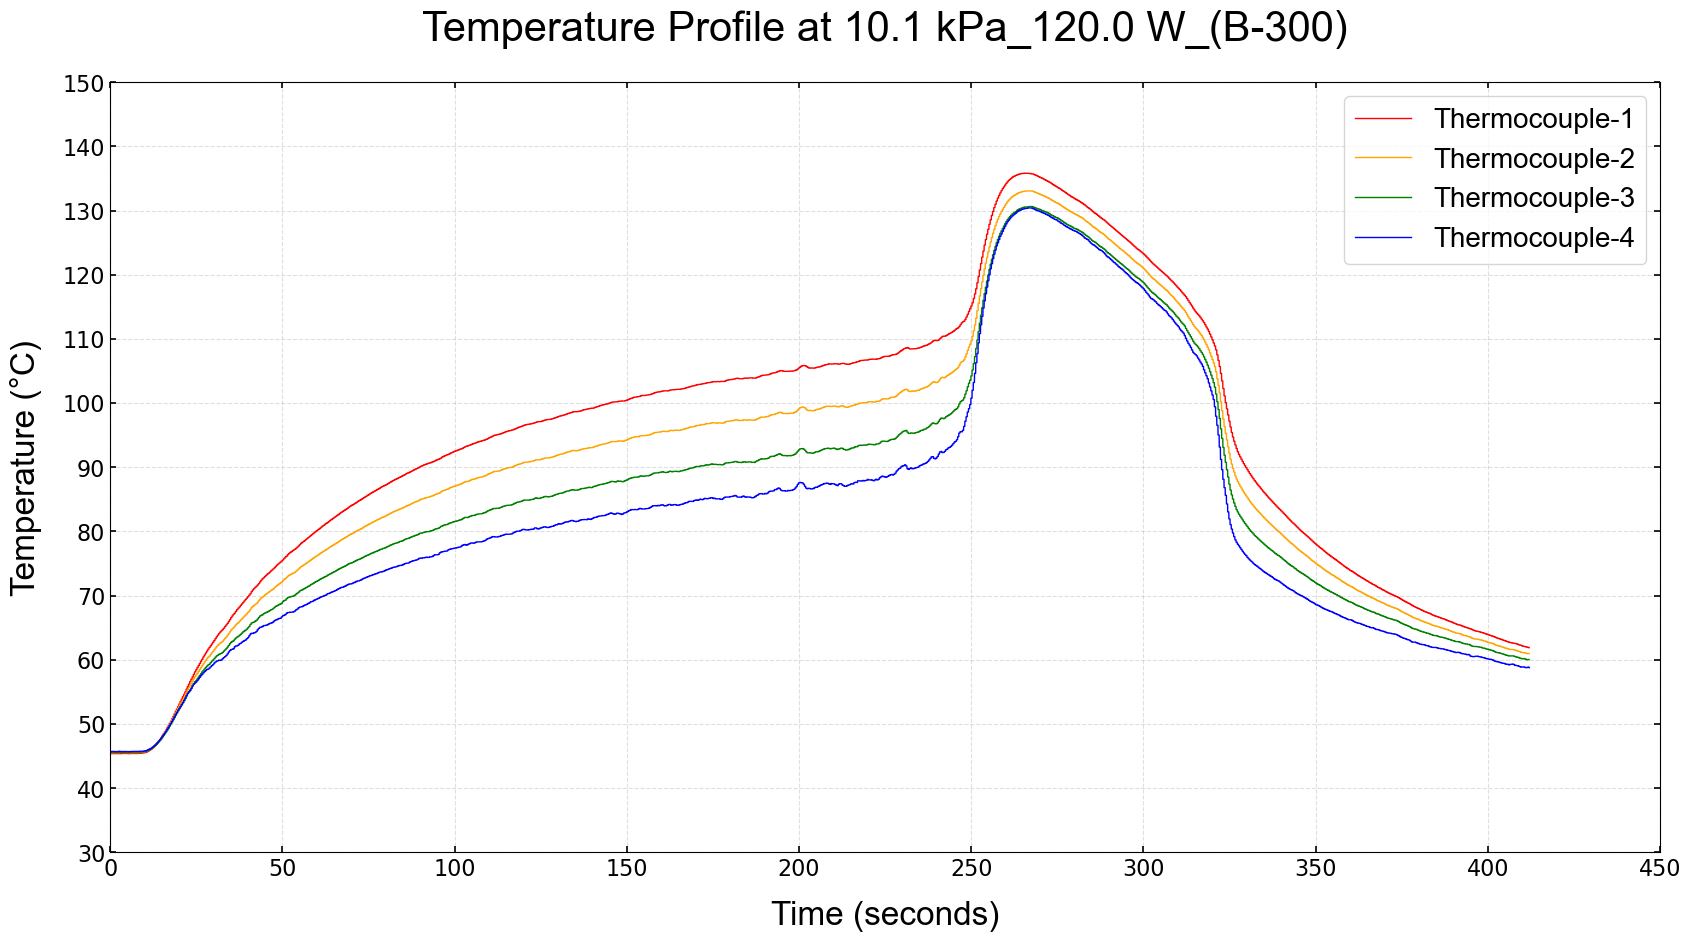

In [681]:
## Create the plot
plt.figure(figsize=(20, 10))

# =======================
# 🔹 First Plot: Without T_surface
# =======================
# Plot each temperature sensor with progressively lighter shades
'''
plt.plot(time_temp, T1, label='Thermocouple-1', color='black', linewidth=1)            # Darkest
plt.plot(time_temp, T2, label='Thermocouple-2', color='darkslategray', linewidth=1)    # Dark gray-green tint
plt.plot(time_temp, T3, label='Thermocouple-3', color='silver', linewidth=1)           # Lighter gray
plt.plot(time_temp, T4, label='Thermocouple-4', color='gainsboro', linewidth=1)        # Very light gray
'''
plt.plot(time_temp, T1, label='Thermocouple-1', color='red', linewidth=1)
plt.plot(time_temp, T2, label='Thermocouple-2', color='orange', linewidth=1)
plt.plot(time_temp, T3, label='Thermocouple-3', color='green', linewidth=1)
plt.plot(time_temp, T4, label='Thermocouple-4', color='blue', linewidth=1)

# Set axis limits
#plt.xlim(time_temp.min(), time_temp.max())  # X-axis from min to max time



#plt.ylim(Temp_min_value-10, Temp_max_value+10)  # Y-axis range (adjust as needed)

ax = plt.gca()
ax.tick_params(axis='both', which='both', direction='in',top=True, right=True, width=1.2, length=4)


## x-axis ticks ##
# multiples of 50 strictly before/after the data bounds
#x_step_time = 20
x_tick_start = x_step_time * np.floor(tmin / x_step_time)
x_tick_end   = x_step_time * np.ceil(tmax / x_step_time)
if x_tick_start >= tmin:
    x_tick_start -= 0
if x_tick_end <= tmax:
    x_tick_end += x_step_time

# set new axis limits and ticks
ax.set_xlim(x_tick_start, x_tick_end)
ax.set_xticks(np.arange(x_tick_start, x_tick_end + x_step_time, x_step_time))



# multiples of 10 strictly before/after the data bounds
#y_step_temp = 10
y_tick_start = y_step_temp * np.floor(ymin_Temp / y_step_temp)
y_tick_end   = y_step_temp * np.ceil(ymax_Temp / y_step_temp)
if y_tick_start >= ymin_Temp:
    y_tick_start -= y_step_temp
if y_tick_end <= ymax_Temp:
    y_tick_end += y_step_temp

# set new y-limits and ticks
ax.set_ylim(y_tick_start, y_tick_end)
ax.set_yticks(np.arange(y_tick_start-y_step_temp, y_tick_end +2*y_step_temp, y_step_temp))

# Labels and title
plt.xlabel("Time (seconds)", fontsize=24, fontname='Arial', labelpad=15)
plt.ylabel("Temperature (°C)", fontsize=24, fontname='Arial', labelpad=15)
plt.title(f"Temperature Profile at {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=30, pad=30, fontname='Arial')


plt.xticks(fontsize=16)  # Increase x-axis tick size
plt.yticks(fontsize=16)  # Increase y-axis tick size

# Add a legend
# Legend with custom font
plt.legend(prop={'family':'Arial','size':20}, loc='upper right')

# Show the grid and plot
plt.grid(True, linestyle='--', alpha=0.4)

# Add a figure border
#plt.gcf().patch.set_linewidth(2)  # Set border thickness
#plt.gcf().patch.set_edgecolor('black')  # Set border color

# Save figure (use a tuple)
saved_figures.append((f"1_Temperature_Profile_{pressure_mean_kPa}kPa_B-{boiling_id}", plt.gcf()))


plt.show()







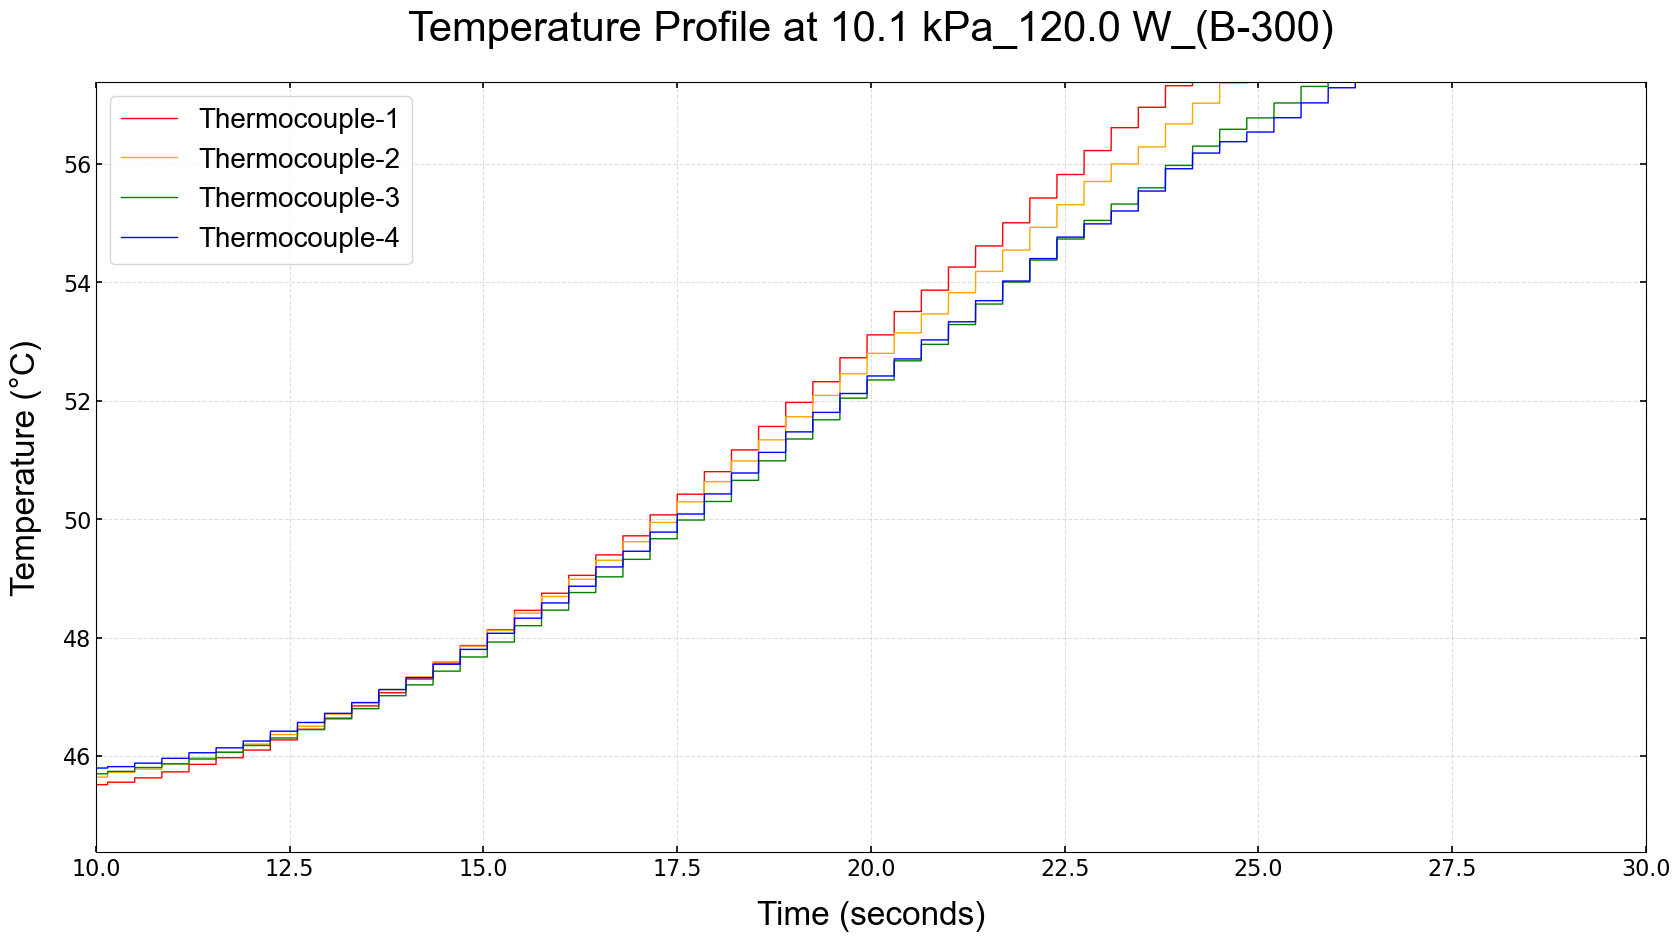

In [682]:
## Create the plot
plt.figure(figsize=(20, 10))


plt.plot(time_temp, T1, label='Thermocouple-1', color='red', linewidth=1)
plt.plot(time_temp, T2, label='Thermocouple-2', color='orange', linewidth=1)
plt.plot(time_temp, T3, label='Thermocouple-3', color='green', linewidth=1)
plt.plot(time_temp, T4, label='Thermocouple-4', color='blue', linewidth=1)

a =10
b = 30
# Set axis limits
#plt.xlim(time_temp.min(), time_temp.min()+20)  # X-axis from min to max time
plt.xlim(a, b)  # X-axis from min to max time


plt.ylim(Temp_min_value-1, Temp_min_value+12)  # Y-axis range (adjust as needed)

# Labels and title
plt.xlabel("Time (seconds)", fontsize=24, fontname='Arial', labelpad=15)
plt.ylabel("Temperature (°C)", fontsize=24, fontname='Arial', labelpad=15)
plt.title(f"Temperature Profile at {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=30, pad=30, fontname='Arial')


plt.xticks(fontsize=16)  # Increase x-axis tick size
plt.yticks(fontsize=16)  # Increase y-axis tick size

# Add a legend
# Legend with custom font
plt.legend(prop={'family':'Arial','size':20}, loc='upper left') 

# Show the grid and plot
plt.grid(True, linestyle='--', alpha=0.4)

# Add a figure border
#plt.gcf().patch.set_linewidth(2)  # Set border thickness
#plt.gcf().patch.set_edgecolor('black')  # Set border color

# Save figure (use a tuple)
#saved_figures.append((f"2_Temperature_Profile_Enlarged_{pressure_mean_kPa}kPa_B-{boiling_id}", plt.gcf()))

ax = plt.gca()
ax.tick_params(axis='both', which='both', direction='in',top=True, right=True, width=1.2, length=4)

plt.show()


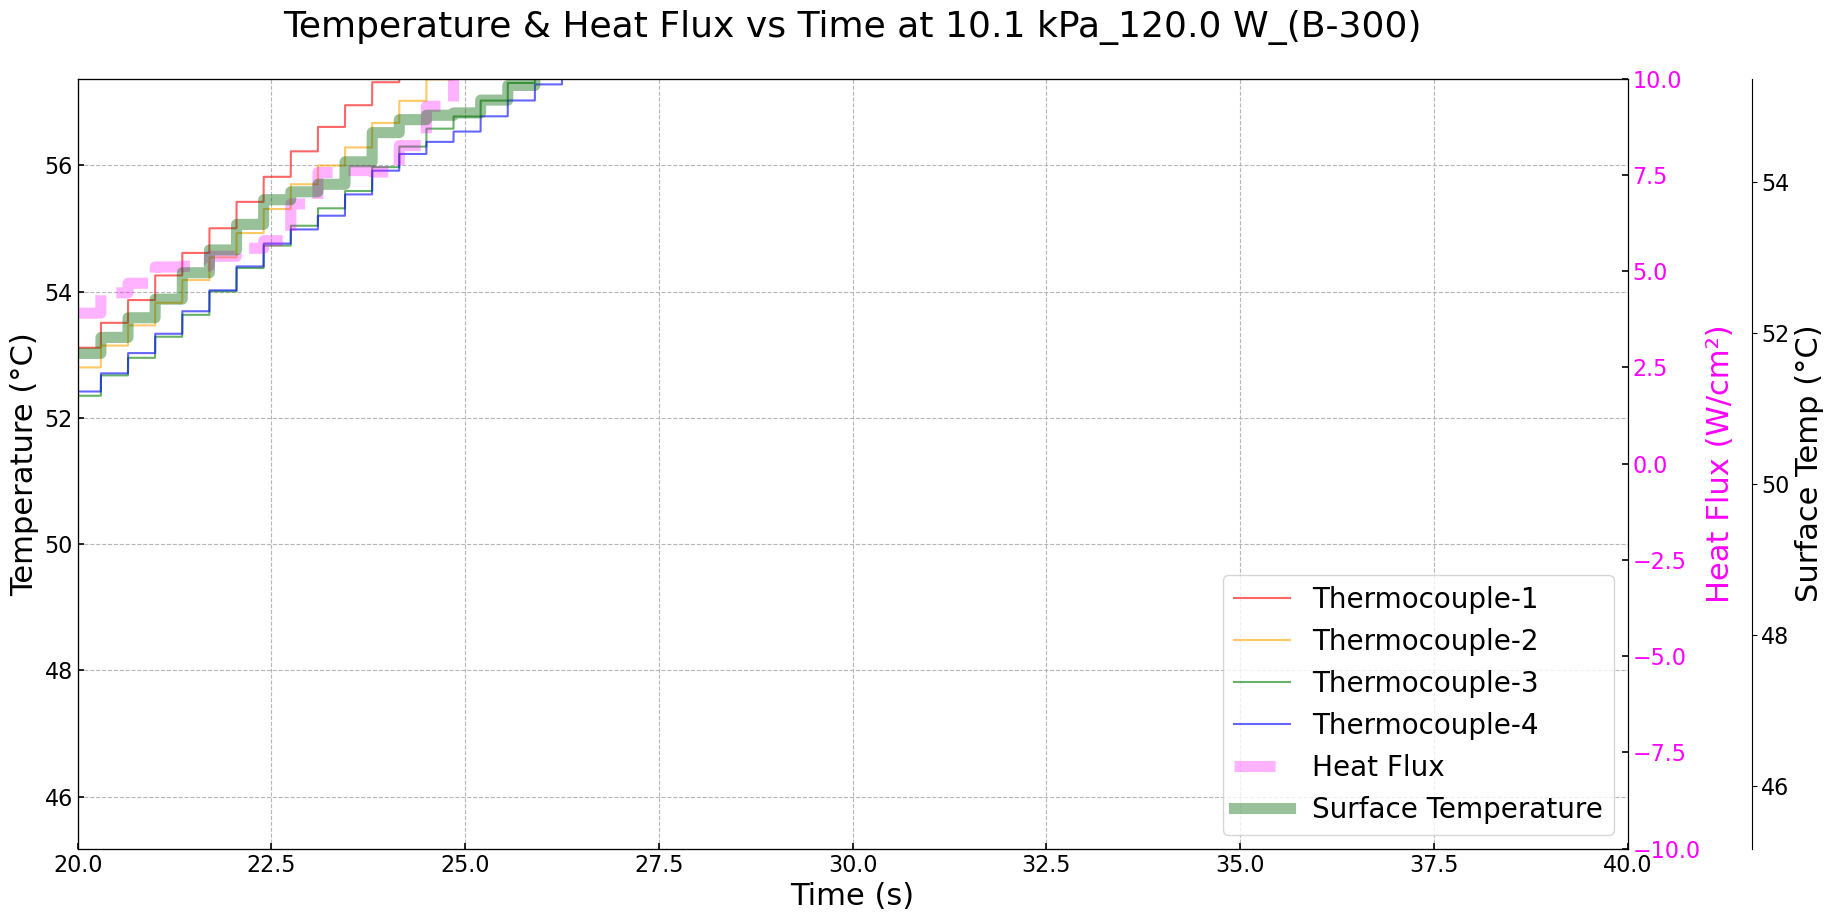

In [683]:
# --- Combined Plot: Temperatures + Heat Flux + Surface Temperature ---
fig, ax1 = plt.subplots(figsize=(20, 10))

# ---------------------------
# 🔴 Left Y-axis: Temperatures
# ---------------------------
ax1.plot(time_temp, T1, label='Thermocouple-1', color='red', alpha=0.6, linewidth=1.5)
ax1.plot(time_temp, T2, label='Thermocouple-2', color='orange', alpha=0.6, linewidth=1.5)
ax1.plot(time_temp, T3, label='Thermocouple-3', color='green', alpha=0.6, linewidth=1.5)
ax1.plot(time_temp, T4, label='Thermocouple-4', color='blue', alpha=0.6, linewidth=1.5)

a =20
b = 40
# ax1.set_xlim(time_temp.min(), time_temp.min() + 40)
ax1.set_xlim(a, b)
ax1.set_ylim(Temp_min_value - 0.2, Temp_min_value + 12)   # Temperature y-limit

# Labels
ax1.set_xlabel("Time (s)", fontsize=22)
ax1.set_ylabel("Temperature (°C)", fontsize=22, color='black')
ax1.tick_params(axis='y', labelcolor='black', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)

ax1.tick_params(axis='x', which='both',
                bottom=True, top=False,
                direction='in', width=1.2, length=4, labelsize=16)

# Only left y-ticks
ax1.tick_params(axis='y', which='both',
                left=True, right=False,
                direction='in', width=1.2, length=4, labelsize=16)
# ---------------------------
# 🔵 Right Y-axis #1: Heat Flux
# ---------------------------
ax2 = ax1.twinx()
ax2.plot(time_temp, q, color='magenta', linewidth=8, linestyle='--', alpha=0.3, label="Heat Flux")

# Heat Flux axis limits (independent!)
q_min = np.min(q)
q_max = np.max(q)
# ax2.set_ylim(q_min - 5, q_min + 10)   # Heat flux y-limit
ax2.set_ylim(-10, 10)   # Heat flux y-limit

ax2.set_ylabel("Heat Flux (W/cm²)", fontsize=22, color='magenta')
ax2.tick_params(axis='y', labelcolor='magenta', labelsize=16)

ax2.tick_params(axis='y', which='both',left=False, right=True,direction='in', width=1.2, length=4)

# ---------------------------
# 🟣 Right Y-axis #2 (offset): Surface Temperature
# ---------------------------
ax3 = ax1.twinx()  # create a second right-side axis
ax3.spines["right"].set_position(("axes", 1.08))  # offset to avoid overlap with ax2
ax3.spines["right"].set_visible(True)

# Plot Surface Temperature (adjust name if your variable differs)
# Example variable name: Surface_Temperature
Surf_min = np.nanmin(Surface_Temperature)
Surf_max = np.nanmax(Surface_Temperature)
ax3.plot(time_temp, Surface_Temperature, color='darkgreen', linewidth=8, alpha=0.4, label="Surface Temperature")

# Independent y-lim for surface temp
#ax3.set_ylim(Surf_min - 0.2, Surf_min + 15)
ax3.set_ylim(Temp_min_value - 0.2, Temp_min_value + 10)

ax3.set_ylabel("Surface Temp (°C)", fontsize=22, color='black')
ax3.tick_params(axis='y', labelcolor='black', labelsize=16)

# ---------------------------
# Legends (combine from all three axes)
# ---------------------------
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, fontsize=20, loc='lower right')

# Title & Grid
plt.title(f"Temperature & Heat Flux vs Time at {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=26, pad=30)
ax1.grid(True, linestyle='--', alpha=0.9)

# Save figure (use a tuple)
saved_figures.append((f"2_Heat Flux check_{pressure_mean_kPa}kPa_B-{boiling_id}", plt.gcf()))

plt.show()


## Plotting Surface Temperature

Max Surface Temperature = 125.69 (°C) at 267.39 s


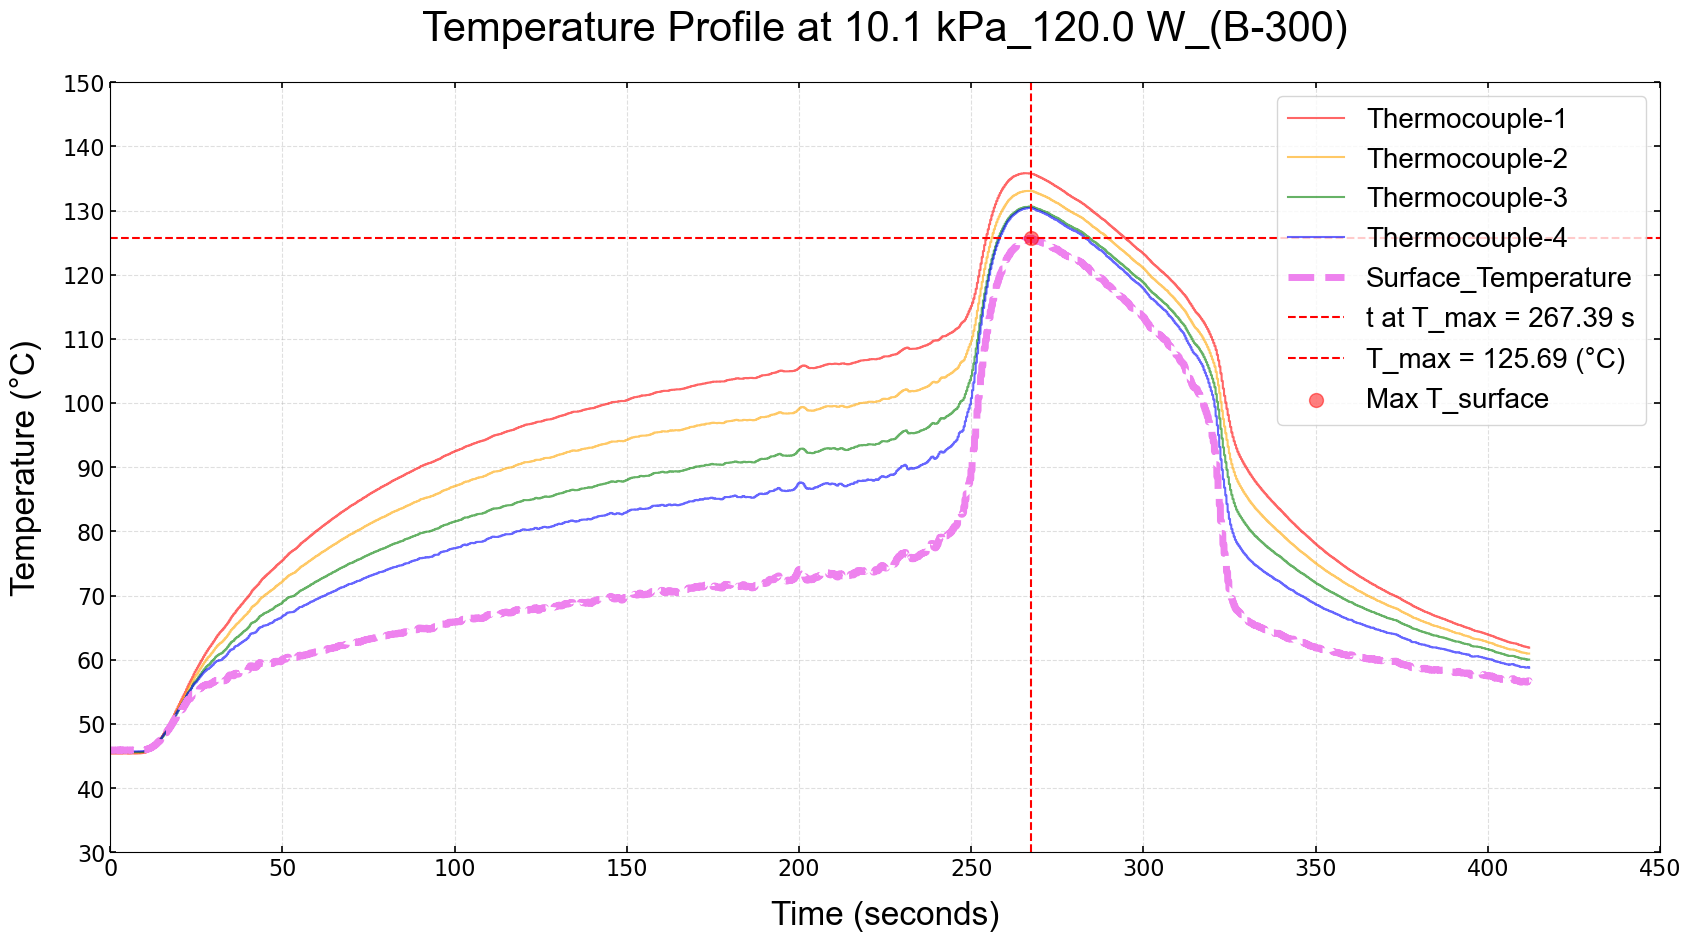

In [684]:
max_Surface_Temperature = np.max(Surface_Temperature)
time_at_max_Surface_Temperature = time_temp[np.argmax(Surface_Temperature)]
print(f"Max Surface Temperature = {max_Surface_Temperature:.2f} (°C) at {time_at_max_Surface_Temperature:.2f} s")

## Create the plot
plt.figure(figsize=(20, 10))
# =======================
# 🔹 Second Plot: With calculated T_surface
# =======================

plt.plot(time_temp, T1, label='Thermocouple-1', color='red', alpha=0.6, linewidth=1.5)
plt.plot(time_temp, T2, label='Thermocouple-2', color='orange', alpha=0.6, linewidth=1.5)
plt.plot(time_temp, T3, label='Thermocouple-3', color='green', alpha=0.6, linewidth=1.5)
plt.plot(time_temp, T4, label='Thermocouple-4', color='blue', alpha=0.6, linewidth=1.5)

# Plot each temperature sensor with progressively lighter shades
#plt.plot(time_temp, T1, label='Thermocouple-1', color='black', linewidth=1)       # Darkest black
#plt.plot(time_temp, T2, label='Thermocouple-2', color='dimgray', linewidth=1)     # Dark gray
#plt.plot(time_temp, T3, label='Thermocouple-3', color='gray', linewidth=1)        # Medium gray
#plt.plot(time_temp, T4, label='Thermocouple-4', color='lightgray', linewidth=1)   # Light gray
plt.plot(time_temp, Surface_Temperature, label='Surface_Temperature', color='violet', linewidth=5, linestyle='--')   # Light gray

# Add vertical dashed line at CHF_time
plt.axvline(x=time_at_max_Surface_Temperature, color='red', linestyle='--', linewidth=1.5, label=f't at T_max = {time_at_max_Surface_Temperature:.2f} s')

# Add horizontal dashed line at CHF_value
plt.axhline(y=max_Surface_Temperature, color='red', linestyle='--', linewidth=1.5, label=f'T_max = {max_Surface_Temperature:.2f} (°C)')

# Add a big green dot at the CHF point
plt.scatter(time_at_max_Surface_Temperature, max_Surface_Temperature, color='red', s=100, alpha=0.5, label='Max T_surface', zorder=5)




# Set axis limits
#plt.xlim(time_temp.min(), time_temp.max())  # X-axis from min to max time



#plt.ylim(Temp_min_value-30, Temp_max_value+30)  # Y-axis range (adjust as needed)

ax = plt.gca()

tmin = float(np.nanmin(time_temp))
tmax = float(np.nanmax(time_temp))

## x-axis ticks ##

#x_step_time = 20
x_tick_start = x_step_time * np.floor(tmin / x_step_time)
x_tick_end   = x_step_time * np.ceil(tmax / x_step_time)
if x_tick_start >= tmin:
    x_tick_start -= 0
if x_tick_end <= tmax:
    x_tick_end += x_step_time

# set new axis limits and ticks
ax.set_xlim(x_tick_start, x_tick_end)
ax.set_xticks(np.arange(x_tick_start, x_tick_end + x_step_time, x_step_time))



#y_step_temp = 10
y_tick_start = y_step_temp * np.floor(ymin_Temp / y_step_temp)
y_tick_end   = y_step_temp * np.ceil(ymax_Temp / y_step_temp)
if y_tick_start >= ymin_Temp:
    y_tick_start -= y_step_temp
if y_tick_end <= ymax_Temp:
    y_tick_end += y_step_temp

# set new y-limits and ticks
ax.set_ylim(y_tick_start, y_tick_end)
ax.set_yticks(np.arange(y_tick_start-y_step_temp, y_tick_end +2*y_step_temp, y_step_temp))

# Labels and title
plt.xlabel("Time (seconds)", fontsize=24, fontname='Arial', labelpad=15)
plt.ylabel("Temperature (°C)", fontsize=24, fontname='Arial', labelpad=15)
plt.title(f"Temperature Profile at {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=30, pad=30, fontname='Arial')

plt.xticks(fontsize=16)  # Increase x-axis tick size
plt.yticks(fontsize=16)  # Increase y-axis tick size

# Add a legend
plt.legend(prop={'family':'Arial','size':20}, loc='upper right')  # Adjust the size (increase as needed)

# Show the grid and plot
plt.grid(True, linestyle='--', alpha=0.4)

# Add a figure border
#plt.gcf().patch.set_linewidth(2)  # Set border thickness
#plt.gcf().patch.set_edgecolor('black')  # Set border color

# Save figure (use a tuple)
saved_figures.append((f"3_Surface Temperature_{pressure_mean_kPa}kPa_B-{boiling_id}", plt.gcf()))

ax = plt.gca()
ax.tick_params(axis='both', which='both', direction='in',top=True, right=True, width=1.2, length=4)

plt.show()




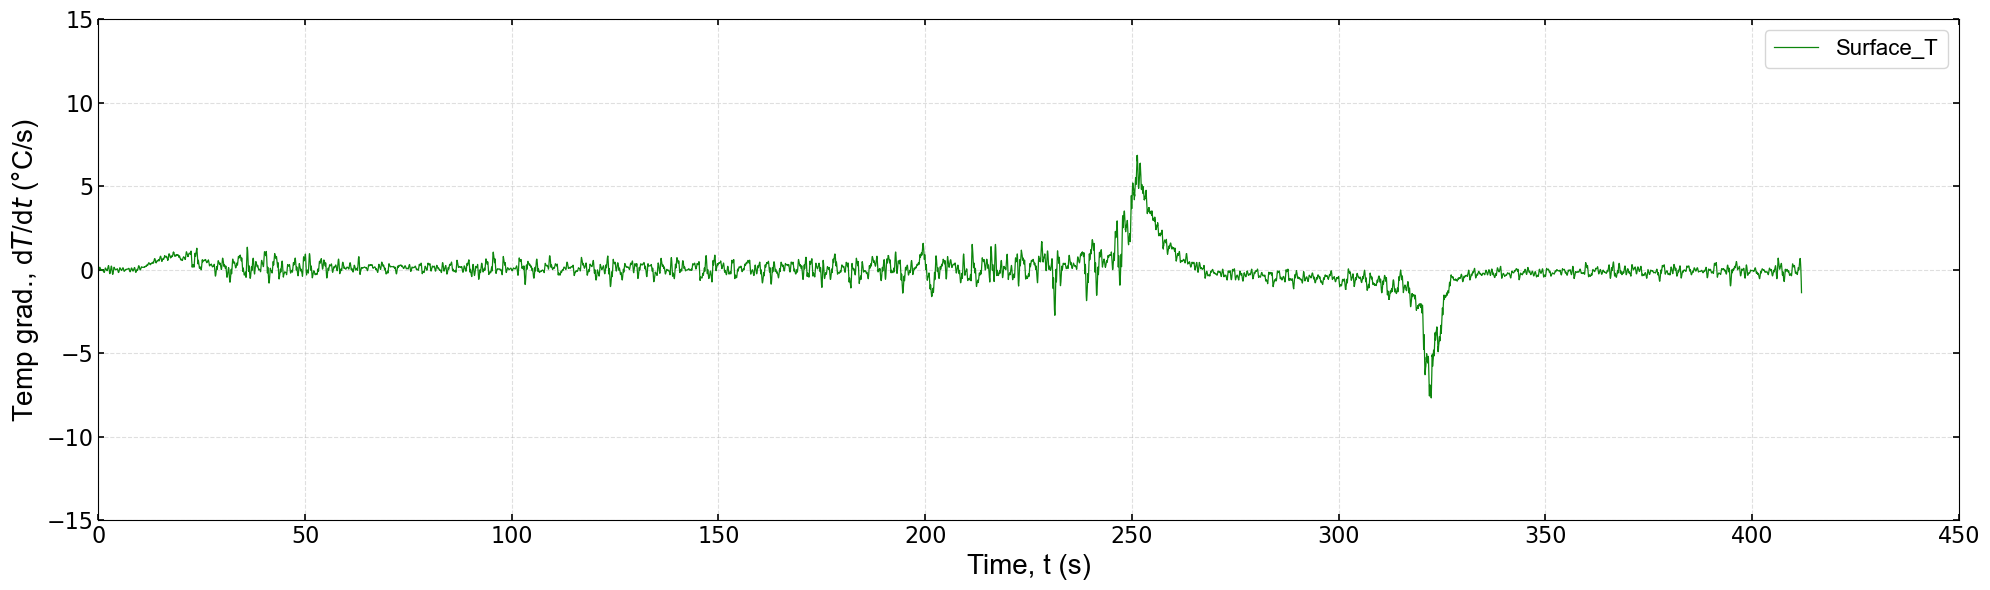

In [685]:
# ====== knobs (same behavior for all curves) ======
use_savgol = True      # True: Savitzky–Golay derivative; False: gradient + moving-average
smooth_sec = 0.75      # smoothing window in seconds (0.3–1.0 typical)
ma_sec     = 1.0       # only used if use_savgol=False
ds_step    = 100        # plot every Nth point to visually thin the line
# ==================================================

t = np.asarray(time_temp, dtype=float)

# ensure strictly increasing time
if np.any(np.diff(t) <= 0):
    t = np.maximum.accumulate(t + np.linspace(0, 1e-12, t.size))

dt_med = float(np.median(np.diff(t)))

def dTdt_processed(Tsig):
    Tsig = np.asarray(Tsig, dtype=float)
    if use_savgol:
        from scipy.signal import savgol_filter
        win = max(3, int(round(smooth_sec / max(1e-9, dt_med))) | 1)  # odd >= 3
        dTdt = savgol_filter(Tsig, window_length=win, polyorder=3, deriv=1, delta=dt_med)
    else:
        dTdt_raw = np.gradient(Tsig, t)
        win = max(3, int(round(ma_sec / max(1e-9, dt_med))) | 1)
        ker = np.ones(win) / win
        dTdt = np.convolve(dTdt_raw, ker, mode='same')
    # downsample for plotting
    return t[::ds_step], dTdt[::ds_step]

# compute for all five signals
curves = [
    #("TC-1", "black",        *dTdt_processed(T1)),
    #("TC-2", "dimgray",      *dTdt_processed(T2)),
    #("TC-3", "gray",         *dTdt_processed(T3)),
    #("TC-4", "lightgray",    *dTdt_processed(T4)),
    ("Surface_T", "green",   *dTdt_processed(Surface_Temperature)),
]

# ---- Plot ----
fig, ax = plt.subplots(figsize=(20, 6))
for label, color, tx, dy in curves:
    ax.plot(tx, dy, color=color, linewidth=0.9, alpha=0.95, label=label)

ax.set_xlabel('Time, t (s)', fontsize=20, fontname='Arial')
ax.set_ylabel(r'Temp grad., d$T$/d$t$ (°C/s)', fontsize=20, fontname='Arial')

# Nice x ticks
x_tick_start = x_step_time * np.floor(tmin / x_step_time)
x_tick_end   = x_step_time * np.ceil(tmax / x_step_time)
if x_tick_start >= tmin:
    x_tick_start -= 0
if x_tick_end <= tmax:
    x_tick_end += x_step_time

# set new axis limits and ticks
ax.set_xlim(x_tick_start, x_tick_end)
ax.set_xticks(np.arange(x_tick_start, x_tick_end + x_step_time, x_step_time))

# Y ticks with padding based on all plotted derivatives
all_vals = np.concatenate([dy for _,_,_,dy in curves])
ymin_dT_dt = float(np.nanmin(all_vals))
ymax_dT_dt = float(np.nanmax(all_vals))
pad  = 0.1 * max(1e-9, ymax_dT_dt - ymin_dT_dt)
# Y step
if (ymax_dT_dt - ymin_dT_dt) > 5:
    y_step_dT_dt = 5
else:
    y_step_dT_dt = 1

y_tick_start = y_step_dT_dt * np.floor(ymin_dT_dt / y_step_dT_dt)
y_tick_end   = y_step_dT_dt * np.ceil(ymax_dT_dt / y_step_dT_dt)
if y_tick_start >= ymin_dT_dt:
    y_tick_start -= y_step_dT_dt
if y_tick_end <= ymax_dT_dt:
    y_tick_end += y_step_dT_dt

# set new y-limits and ticks
ax.set_ylim(y_tick_start, y_tick_end)
ax.set_yticks(np.arange(y_tick_start-y_step_dT_dt, y_tick_end +2*y_step_dT_dt, y_step_dT_dt))

plt.xticks(fontsize=16)  # Increase x-axis tick size
plt.yticks(fontsize=16)  # Increase y-axis tick size

ax.grid(True, linestyle='--', alpha=0.4)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, width=1.2, length=4)
ax.legend(prop={'family':'Arial','size':16}, loc='upper right')
plt.tight_layout()

# Save figure (use a tuple)
saved_figures.append((f"4_Temperature Gradient_{pressure_mean_kPa}kPa_B-{boiling_id}", plt.gcf()))


plt.show()

### Heat Flux and HTC

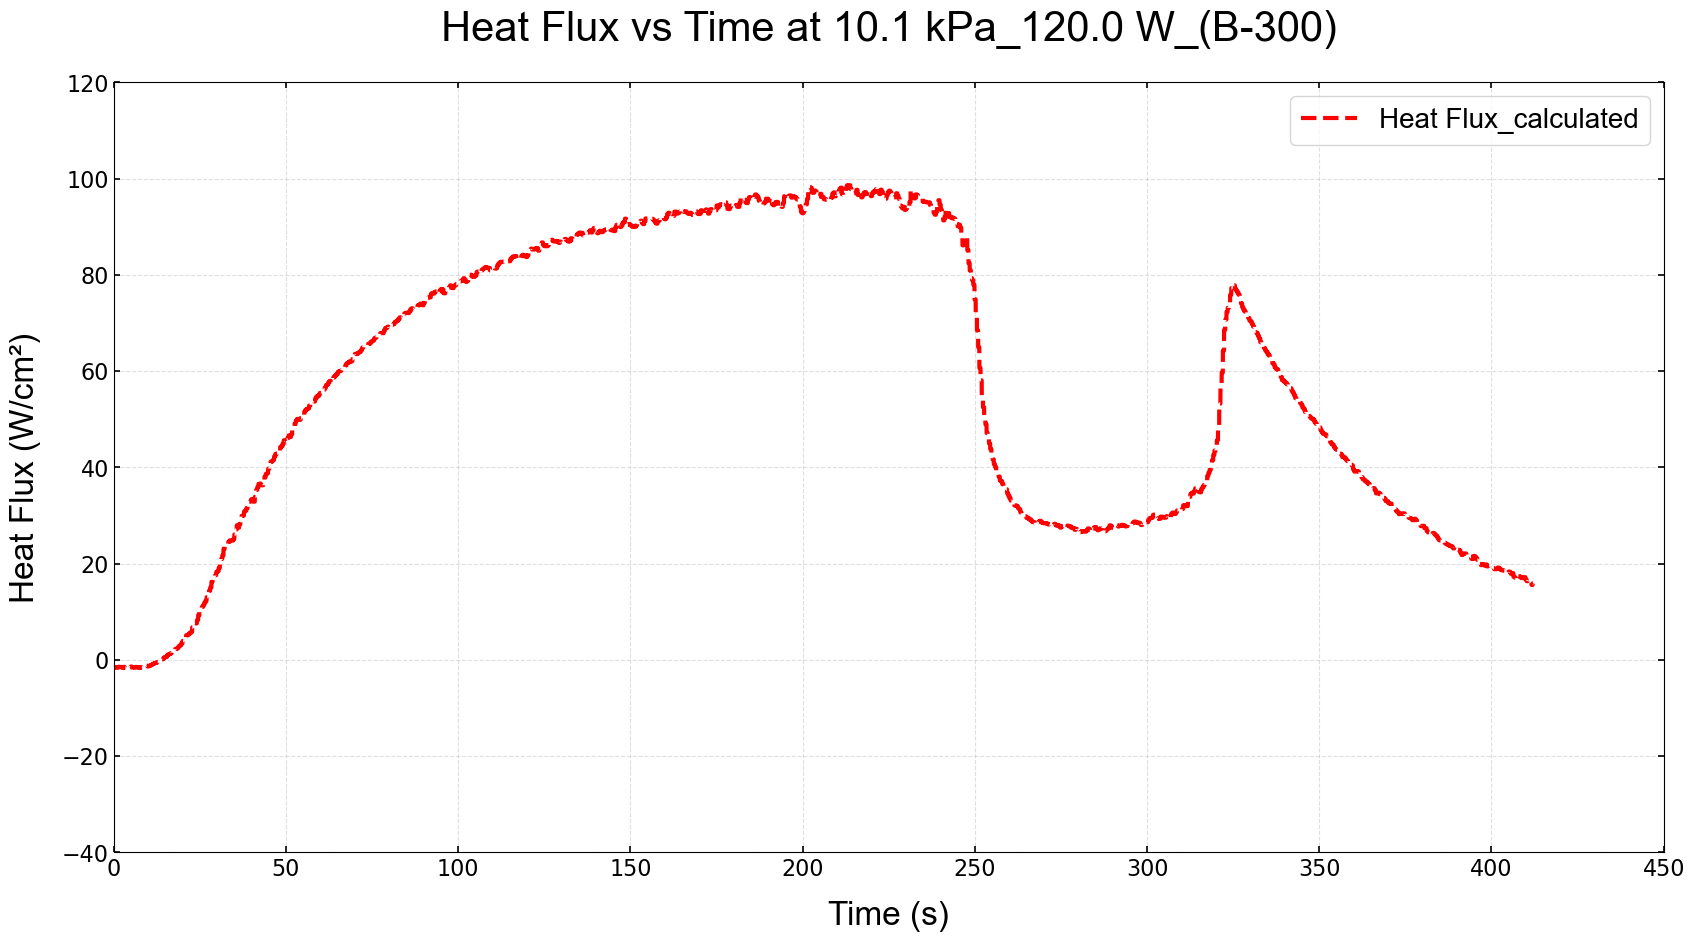

In [686]:
# Create a figure with two subplots
plt.figure(figsize=(20, 10))


# Plot each temperature sensor with progressively lighter shades
plt.plot(time_temp, q, color='red', linewidth=3, linestyle='--', label="Heat Flux_calculated")

# Set axis limits
#plt.xlim(time_temp.min(), 100)
#plt.xlim(time.min(), time.max())  # X-axis from min to max time

ax = plt.gca()

tmin = float(np.nanmin(time_temp))
tmax = float(np.nanmax(time_temp))

## x-axis ticks ##
x_tick_start = x_step_time * np.floor(tmin / x_step_time)
x_tick_end   = x_step_time * np.ceil(tmax / x_step_time)
if x_tick_start >= tmin:
    x_tick_start -= 0
if x_tick_end <= tmax:
    x_tick_end += x_step_time

# set new axis limits and ticks
ax.set_xlim(x_tick_start, x_tick_end)
ax.set_xticks(np.arange(x_tick_start, x_tick_end + x_step_time, x_step_time))



y_tick_start = y_step_q * np.floor(ymin_q / y_step_q)
y_tick_end   = y_step_q * np.ceil(ymax_q / y_step_q)
if y_tick_start >= ymin_q:
    y_tick_start -= y_step_q
if y_tick_end <= ymax_q:
    y_tick_end += y_step_q

# set new y-limits and ticks
ax.set_ylim(y_tick_start, y_tick_end)
ax.set_yticks(np.arange(y_tick_start-y_step_q, y_tick_end +2*y_step_q, y_step_q))

# Labels and title
plt.xlabel("Time (s)", fontsize=24, fontname='Arial', labelpad=15)
plt.ylabel("Heat Flux (W/cm²)", fontsize=24, fontname='Arial', labelpad=15)
plt.title(f"Heat Flux vs Time at {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=30, pad=30, fontname='Arial')

# Add a legend
plt.legend(prop={'family':'Arial','size':20}, loc='upper right')

# Apply these tick positions to the x-axis
plt.xticks(fontsize=16)  # Increase x-axis tick size
plt.yticks(fontsize=16)  # Increase y-axis tick size
#plt.xticks(tick_positions)
# Show the grid and plot
plt.grid(True, linestyle='--', alpha=0.4)

ax = plt.gca()
ax.tick_params(axis='both', which='both', direction='in',top=True, right=True, width=1.2, length=4)

# Save figure (use a tuple)
saved_figures.append((f"5_Heat Flux VS Time_{pressure_mean_kPa}kPa_B-{boiling_id}", plt.gcf()))

plt.show()


In [694]:
#'''
def _as_np(x):
    return np.asarray(x.values if isinstance(x, pd.Series) else x, dtype=float)

def _moving_avg(x, win):
    win = max(1, int(win))
    if win == 1: 
        return x.copy()
    k = np.ones(win, dtype=float) / win
    return np.convolve(x, k, mode="same")

def first_two_peaks_after_t0(time_series, q_array,
                             t0=50.0,
                             smooth_sec=1.0,
                             min_gap_s=10.0,
                             local_win_s=20.0,
                             k_sigma=4.0,
                             max_relax=3,
                             lookahead_s=10.0,       # NEW: skip if higher peak within this
                             drop_window_s=10.0,     # NEW: must drop within this window
                             drop_min_abs=5.0,       # NEW: absolute drop threshold (W/cm^2)
                             drop_min_rel=0.03,      # NEW: relative drop threshold (fraction of peak)
                             neg_frac_thresh=0.6,    # NEW: ≥60% of slopes in window negative
                             half_width_s=None):
    """
    Pick first TWO valid peaks (CHF then NBR) after t>=t0.
    A candidate is valid iff:
      (A) No higher peak occurs within lookahead_s seconds after it, and
      (B) The curve drops within drop_window_s seconds after it by at least
          max(drop_min_abs, drop_min_rel * peak), and the window is mostly decreasing.
    """

    t = _as_np(time_series)
    q = _as_np(q_array)

    # sanitize & sort
    m = np.isfinite(t) & np.isfinite(q)
    t, q = t[m], q[m]
    if t.size < 5: raise ValueError("Not enough data.")
    o = np.argsort(t)
    t, q = t[o], q[o]

    # smoothing (used for detection; values reported from raw q)
    dt = np.median(np.diff(t))
    win = max(1, int(round(smooth_sec / max(dt, 1e-9))))
    qs = _moving_avg(q, win)

    # derivatives
    dq  = np.gradient(qs, t)
    d2q = np.gradient(dq,  t)

    # candidates: +→0/− and concave down, after t0
    sign = np.sign(dq)
    sc = (sign[:-1] > 0) & (sign[1:] <= 0)
    cand = np.where(np.r_[False, sc])[0]
    cand = cand[(t[cand] >= t0)]
    cand = cand[d2q[cand] < 0]

    # helpers
    def enforce_gap(idxs):
        out, last_t = [], -np.inf
        for i in sorted(idxs, key=lambda k: t[k]):
            if t[i] - last_t >= min_gap_s:
                out.append(i); last_t = t[i]
        return np.array(out, dtype=int)

    def local_prominence(i):
        L = t[i] - local_win_s; R = t[i] + local_win_s
        left  = (t >= L) & (t <= t[i])
        right = (t >= t[i]) & (t <= R)
        if not left.any() or not right.any(): return 0.0
        base = max(qs[left].min(), qs[right].min())
        return float(qs[i] - base)

    # A) higher peak soon after?
    def fail_lookahead(i, idxs_sorted):
        # idxs_sorted must be time-ascending
        j = np.searchsorted(t[idxs_sorted], t[i] + 1e-12)
        # scan forward while within lookahead_s
        for k in idxs_sorted[j:]:
            if t[k] - t[i] > lookahead_s: break
            if qs[k] > qs[i]: return True
        return False

    # B) must drop within window and mostly downward
    def pass_dropoff(i):
        right = (t > t[i]) & (t <= t[i] + drop_window_s)
        if right.sum() < 3:    # need enough points
            return False
        qseg = qs[right]
        tseg = t[right]
        # magnitude of drop
        drop_needed = max(drop_min_abs, drop_min_rel * abs(qs[i]))
        actual_drop = qs[i] - np.min(qseg)
        # trend: fraction of negative slopes
        slopes = np.diff(qseg) / np.diff(tseg)
        frac_neg = np.mean(slopes < 0)
        return (actual_drop >= drop_needed) and (frac_neg >= neg_frac_thresh)

    # adaptive prominence threshold
    mad = np.median(np.abs(dq - np.median(dq))) if dq.size else 0.0
    noise = 1.4826 * mad
    base_thresh = k_sigma * noise

    chosen = None
    for relax_step in range(max_relax + 1):
        thr = max(0.0, base_thresh * (0.5 ** relax_step))
        peaks = np.array([], dtype=int) if cand.size == 0 else cand[np.array([local_prominence(i) for i in cand]) >= thr]

        # sort by time for the validations
        peaks = np.array(sorted(peaks, key=lambda k: t[k]), dtype=int)

        # apply A and B
        valid = []
        for i in peaks:
            if fail_lookahead(i, peaks):  # overshadowed soon after
                continue
            if not pass_dropoff(i):       # no meaningful drop
                continue
            valid.append(i)

        valid = enforce_gap(valid)

        if valid.size >= 2:
            valid = valid[np.argsort(t[valid])]
            chosen = valid[:2]
            break

    if chosen is None:
        raise RuntimeError("Could not find two valid peaks satisfying look-ahead and drop-off rules.")

    i_chf, i_nbr = int(chosen[0]), int(chosen[1])

    out = {
        "CHF": {"time": float(t[i_chf]), "value": float(q[i_chf]), "index": i_chf},
        "NBR": {"time": float(t[i_nbr]), "value": float(q[i_nbr]), "index": i_nbr},
    }
    if isinstance(half_width_s, (int, float)) and half_width_s > 0:
        t_chf = t[i_chf]; t_nbr = t[i_nbr]
        out["CHF"]["window_mask"] = (t >= t_chf - half_width_s) & (t <= t_chf + half_width_s)
        out["NBR"]["window_mask"] = (t >= t_nbr - half_width_s) & (t <= t_nbr + half_width_s)
    return out




res = first_two_peaks_after_t0(
    time_temp, q,
    t0=50.0,
    smooth_sec=1.0,
    min_gap_s=40,
    local_win_s=10,
    k_sigma=4,
    lookahead_s=10.0,      # skip if higher peak within 10 s
    drop_window_s=20.0,    # must drop within 10 s
    drop_min_abs=5.0,      # e.g., at least 5 W/cm² drop
    drop_min_rel=0.03,     # or at least 3% of peak
    neg_frac_thresh=0.6    # mostly decreasing
)



#smooth_sec (0.5–2.0 s): more if noisy.

#min_gap_s: your expected CHF→NBR time spacing.

#local_win_s: size of the window for local prominence on each side.

#k_sigma: stricter (larger) ignores tiny ripples; the code will relax stepwise if needed—but never uses global extrema.


# === Six variables ===
chf_time  = res["CHF"]["time"]
chf_value = res["CHF"]["value"]
chf_idx   = res["CHF"]["index"]      # location (array index) of CHF

nbr_time  = res["NBR"]["time"]
nbr_value = res["NBR"]["value"]
nbr_idx   = res["NBR"]["index"]      # location (array index) of NBR

# Print nicely
chf_time, chf_value, chf_idx = res["CHF"]["time"], res["CHF"]["value"], res["CHF"]["index"]
nbr_time, nbr_value, nbr_idx = res["NBR"]["time"], res["NBR"]["value"], res["NBR"]["index"]

print(f"CHF -> t={chf_time:.2f}s, q={chf_value:.2f} W/cm², idx={chf_idx}")
print(f"NBR -> t={nbr_time:.2f}s, q={nbr_value:.2f} W/cm², idx={nbr_idx}")
#'''


CHF -> t=231.84s, q=97.49 W/cm², idx=695551
NBR -> t=324.99s, q=77.94 W/cm², idx=974999


In [688]:
## Identifying CHF from Heat Flux graph

In [689]:
'''
def first_major_peak_window(time_series, q_array, half_width_s=50.0):
    """
    Find the two *most prominent* peaks in q(t), choose the earlier one,
    and return a boolean mask for t in [t_peak-50, t_peak+50].
    """
    # Ensure array types
    t = np.asarray(time_series.values if isinstance(time_series, pd.Series) else time_series, dtype=float)
    q = np.asarray(q_array, dtype=float)

    # ---- Try scipy for robust peak finding; fall back to a simple detector if unavailable ----
    try:
        from scipy.signal import find_peaks

        # Estimate sampling interval and set a min separation so small ripples aren't counted as separate peaks
        dt = np.median(np.diff(t)) if len(t) > 1 else 1.0
        min_separation_s = 20.0                 # adjust if your two big peaks are closer/farther
        distance_samples = max(1, int(min_separation_s / max(dt, 1e-9)))

        # Prominence threshold: fraction of overall range (robust to outliers with percentiles)
        q_range = np.nanpercentile(q, 99) - np.nanpercentile(q, 1)
        prom_thresh = max(1e-6, 0.12 * q_range)  # 12% of dynamic range is a good starting point

        peaks, props = find_peaks(q, prominence=prom_thresh, distance=distance_samples)

        if len(peaks) == 0:
            # No peaks found with this threshold; relax and retry once
            peaks, props = find_peaks(q, prominence=0.05 * (q_range if q_range > 0 else 1.0))

        if len(peaks) == 0:
            raise RuntimeError("No peaks detected.")

        # If we have more than two, keep the two most prominent
        prominences = props.get("prominences", np.zeros_like(peaks, dtype=float))
        order = np.argsort(prominences)[::-1]            # descending by prominence
        top = peaks[order[:2]] if len(peaks) >= 2 else peaks[order[:1]]

        # Choose the earlier (smaller time) of the top peaks
        t_peaks = t[top]
        idx_choice = top[np.argmin(t_peaks)]

    except Exception:
        # ---- Simple fallback: local maxima with a height threshold ----
        # Local maxima: q[i-1] < q[i] > q[i+1]
        is_peak = np.r_[False, (q[1:-1] > q[:-2]) & (q[1:-1] > q[2:]), False]
        peak_idx = np.where(is_peak)[0]

        if len(peak_idx) == 0:
            raise RuntimeError("No peaks detected (fallback).")

        # Keep peaks above a height threshold (top ~15% of range)
        q_min, q_max = np.nanmin(q), np.nanmax(q)
        height_thresh = q_min + 0.85 * (q_max - q_min)
        strong = peak_idx[q[peak_idx] >= height_thresh]

        # If fewer than 2 strong peaks, take the highest available
        if len(strong) == 0:
            strong = np.array([peak_idx[np.argmax(q[peak_idx])]])
        elif len(strong) >= 2:
            # pick two highest among strong
            strong = strong[np.argsort(q[strong])[::-1][:2]]

        # earlier of available strong peaks
        idx_choice = strong[np.argmin(t[strong])]

    # ---- Build ± half_width window around the chosen peak ----
    t0 = t[idx_choice]
    window_mask = (t >= t0 - half_width_s) & (t <= t0 + half_width_s)

    return window_mask, t0, idx_choice

# ===== Usage with your variables =====
window_mask, t_peak, idx_peak = first_major_peak_window(time_temp, q, half_width_s=5)

# Now slice:
time_window = time_temp[window_mask].reset_index(drop=True)  # pandas Series
q_window = q[window_mask]                                    # numpy array



plt.figure(figsize=(10,5))
plt.plot(time_temp, q, 'r--', label='Heat Flux')
plt.axvline(t_peak, linestyle=':', label='Chosen peak')
plt.axvspan(t_peak-50, t_peak+50, alpha=0.15, label='±50 s window')
plt.legend(); plt.xlabel("Time (s)"); plt.ylabel("Heat Flux (W/cm²)")

chf_time = t_peak
chf_value = q[idx_peak]

print(f"Chosen peak at t = {t_peak:.2f} s with CHF = {chf_value:.2f} W/cm2 (index {idx_peak}). Window = [{t_peak-50:.2f}, {t_peak+50:.2f}] s.")

'''

'\ndef first_major_peak_window(time_series, q_array, half_width_s=50.0):\n    """\n    Find the two *most prominent* peaks in q(t), choose the earlier one,\n    and return a boolean mask for t in [t_peak-50, t_peak+50].\n    """\n    # Ensure array types\n    t = np.asarray(time_series.values if isinstance(time_series, pd.Series) else time_series, dtype=float)\n    q = np.asarray(q_array, dtype=float)\n\n    # ---- Try scipy for robust peak finding; fall back to a simple detector if unavailable ----\n    try:\n        from scipy.signal import find_peaks\n\n        # Estimate sampling interval and set a min separation so small ripples aren\'t counted as separate peaks\n        dt = np.median(np.diff(t)) if len(t) > 1 else 1.0\n        min_separation_s = 20.0                 # adjust if your two big peaks are closer/farther\n        distance_samples = max(1, int(min_separation_s / max(dt, 1e-9)))\n\n        # Prominence threshold: fraction of overall range (robust to outliers with percen

In [690]:
#'''

def _as_np(x):
    return np.asarray(x.values if isinstance(x, pd.Series) else x, dtype=float)

def top2_with_gap(time_series, q_array, t0=50.0, gap_s=15.0):
    """
    1) Find the maximum q for t >= t0  → CHF
    2) Then find the maximum q for t >= (t_chf + gap_s) → NBR
    Returns dict with times, values, and original indices.
    """
    t = _as_np(time_series)
    q = _as_np(q_array)

    finite = np.isfinite(t) & np.isfinite(q)

    # ---- First (CHF) ----
    mask1 = finite & (t >= t0)
    if mask1.sum() == 0:
        raise RuntimeError("No data points at or after t0.")

    idxs1 = np.where(mask1)[0]
    t1_seg = t[mask1]
    q1_seg = q[mask1]

    q1_max = np.max(q1_seg)
    cands1 = np.where(q1_seg == q1_max)[0]
    # earliest time among equals
    i1_local = cands1[np.argmin(t1_seg[cands1])]
    i1 = int(idxs1[i1_local])

    # ---- Second (NBR) ----
    mask2 = finite & (t >= t[i1] + gap_s)
    if mask2.sum() == 0:
        raise RuntimeError("No data points at least gap_s after the first maximum.")

    idxs2 = np.where(mask2)[0]
    t2_seg = t[mask2]
    q2_seg = q[mask2]

    q2_max = np.max(q2_seg)
    cands2 = np.where(q2_seg == q2_max)[0]
    i2_local = cands2[np.argmin(t2_seg[cands2])]
    i2 = int(idxs2[i2_local])

    return {
        "CHF": {"time": float(t[i1]), "value": float(q[i1]), "index": i1},
        "NBR": {"time": float(t[i2]), "value": float(q[i2]), "index": i2},
    }

# ===== Usage with your variables (time_temp, q) =====
res = top2_with_gap(time_temp, q, t0=50.0, gap_s=15.0)

# Six variables
chf_time  = res["CHF"]["time"]
chf_value = res["CHF"]["value"]
chf_idx   = res["CHF"]["index"]

nbr_time  = res["NBR"]["time"]
nbr_value = res["NBR"]["value"]
nbr_idx   = res["NBR"]["index"]

print(f"CHF -> time = {chf_time:.2f} s, value = {chf_value:.2f} W/cm², index = {chf_idx}")
print(f"NBR -> time = {nbr_time:.2f} s, value = {nbr_value:.2f} W/cm², index = {nbr_idx}")


#'''


CHF -> time = 213.14 s, value = 98.63 W/cm², index = 639450
NBR -> time = 231.34 s, value = 97.57 W/cm², index = 694050


## Plotting CHF point in Heat Flux Graph

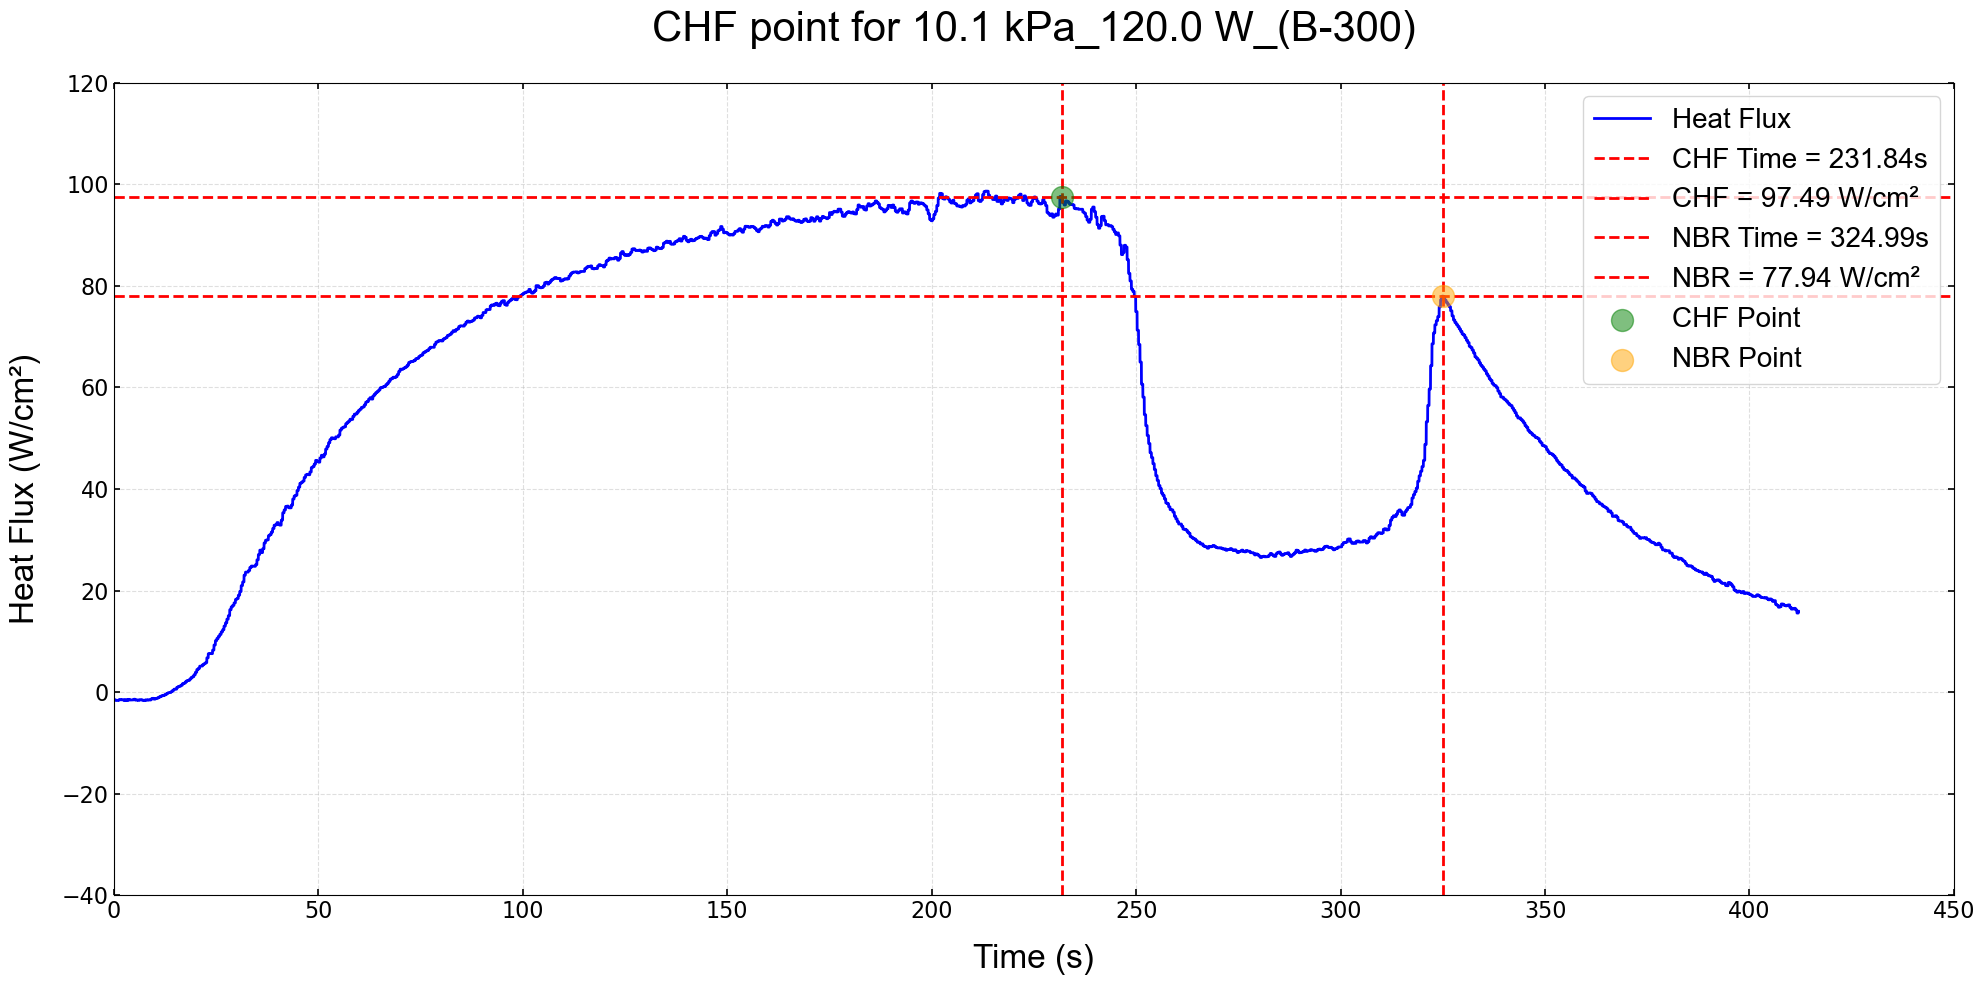

In [696]:
plt.figure(figsize=(20, 10))

# Plot heat flux vs time
plt.plot(time_temp, q, label='Heat Flux', color='blue', linewidth=2)

# Add vertical dashed line at CHF_time
plt.axvline(x=chf_time, color='red', linestyle='--', linewidth=2, label=f'CHF Time = {chf_time:.2f}s')

# Add horizontal dashed line at CHF_value
plt.axhline(y=chf_value, color='red', linestyle='--', linewidth=2, label=f'CHF = {chf_value:.2f} W/cm²')

# Add vertical dashed line at CHF_time
plt.axvline(x=nbr_time, color='red', linestyle='--', linewidth=2, label=f'NBR Time = {nbr_time:.2f}s')

# Add horizontal dashed line at CHF_value
plt.axhline(y=nbr_value, color='red', linestyle='--', linewidth=2, label=f'NBR = {nbr_value:.2f} W/cm²')

# Add a big green dot at the CHF point
plt.scatter(chf_time, chf_value, color='green', s=250, alpha=0.5, label='CHF Point', zorder=5)

# Add a big green dot at the CHF point
plt.scatter(nbr_time, nbr_value, color='orange', s=250, alpha=0.5, label='NBR Point', zorder=5)

# Axis labels and title
plt.xlabel("Time (s)", fontsize=24, fontname='Arial', labelpad=15)
plt.ylabel("Heat Flux (W/cm²)", fontsize=24, fontname='Arial', labelpad=15)
plt.title(f"CHF point for {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=30, pad=30, fontname='Arial')

ax = plt.gca()



x_tick_start = x_step_time * np.floor(tmin / x_step_time)
x_tick_end   = x_step_time * np.ceil(tmax / x_step_time)
if x_tick_start >= tmin:
    x_tick_start -= 0
if x_tick_end <= tmax:
    x_tick_end += x_step_time

# set new axis limits and ticks
ax.set_xlim(x_tick_start, x_tick_end)
ax.set_xticks(np.arange(x_tick_start, x_tick_end + x_step_time, x_step_time))


#ax.set_xlim(250, 300)


y_tick_start = y_step_q * np.floor(ymin_q / y_step_q)
y_tick_end   = y_step_q * np.ceil(ymax_q / y_step_q)
if y_tick_start >= ymin_q:
    y_tick_start -= y_step_q
if y_tick_end <= ymax_q:
    y_tick_end += y_step_q

# set new y-limits and ticks
ax.set_ylim(y_tick_start, y_tick_end)
ax.set_yticks(np.arange(y_tick_start-y_step_q, y_tick_end +2*y_step_q, y_step_q))


plt.xticks(fontsize=16)  # Increase x-axis tick size
plt.yticks(fontsize=16)  # Increase y-axis tick size

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(prop={'family':'Arial','size':20}, loc='upper right')
plt.tight_layout()

ax = plt.gca()
ax.tick_params(axis='both', which='both', direction='in',top=True, right=True, width=1.2, length=4)
#ax.set_xlim(250, 300)
# Save figure (use a tuple)
saved_figures.append((f"6_CHF Point_{pressure_mean_kPa}kPa_B-{boiling_id}", plt.gcf()))


plt.show()



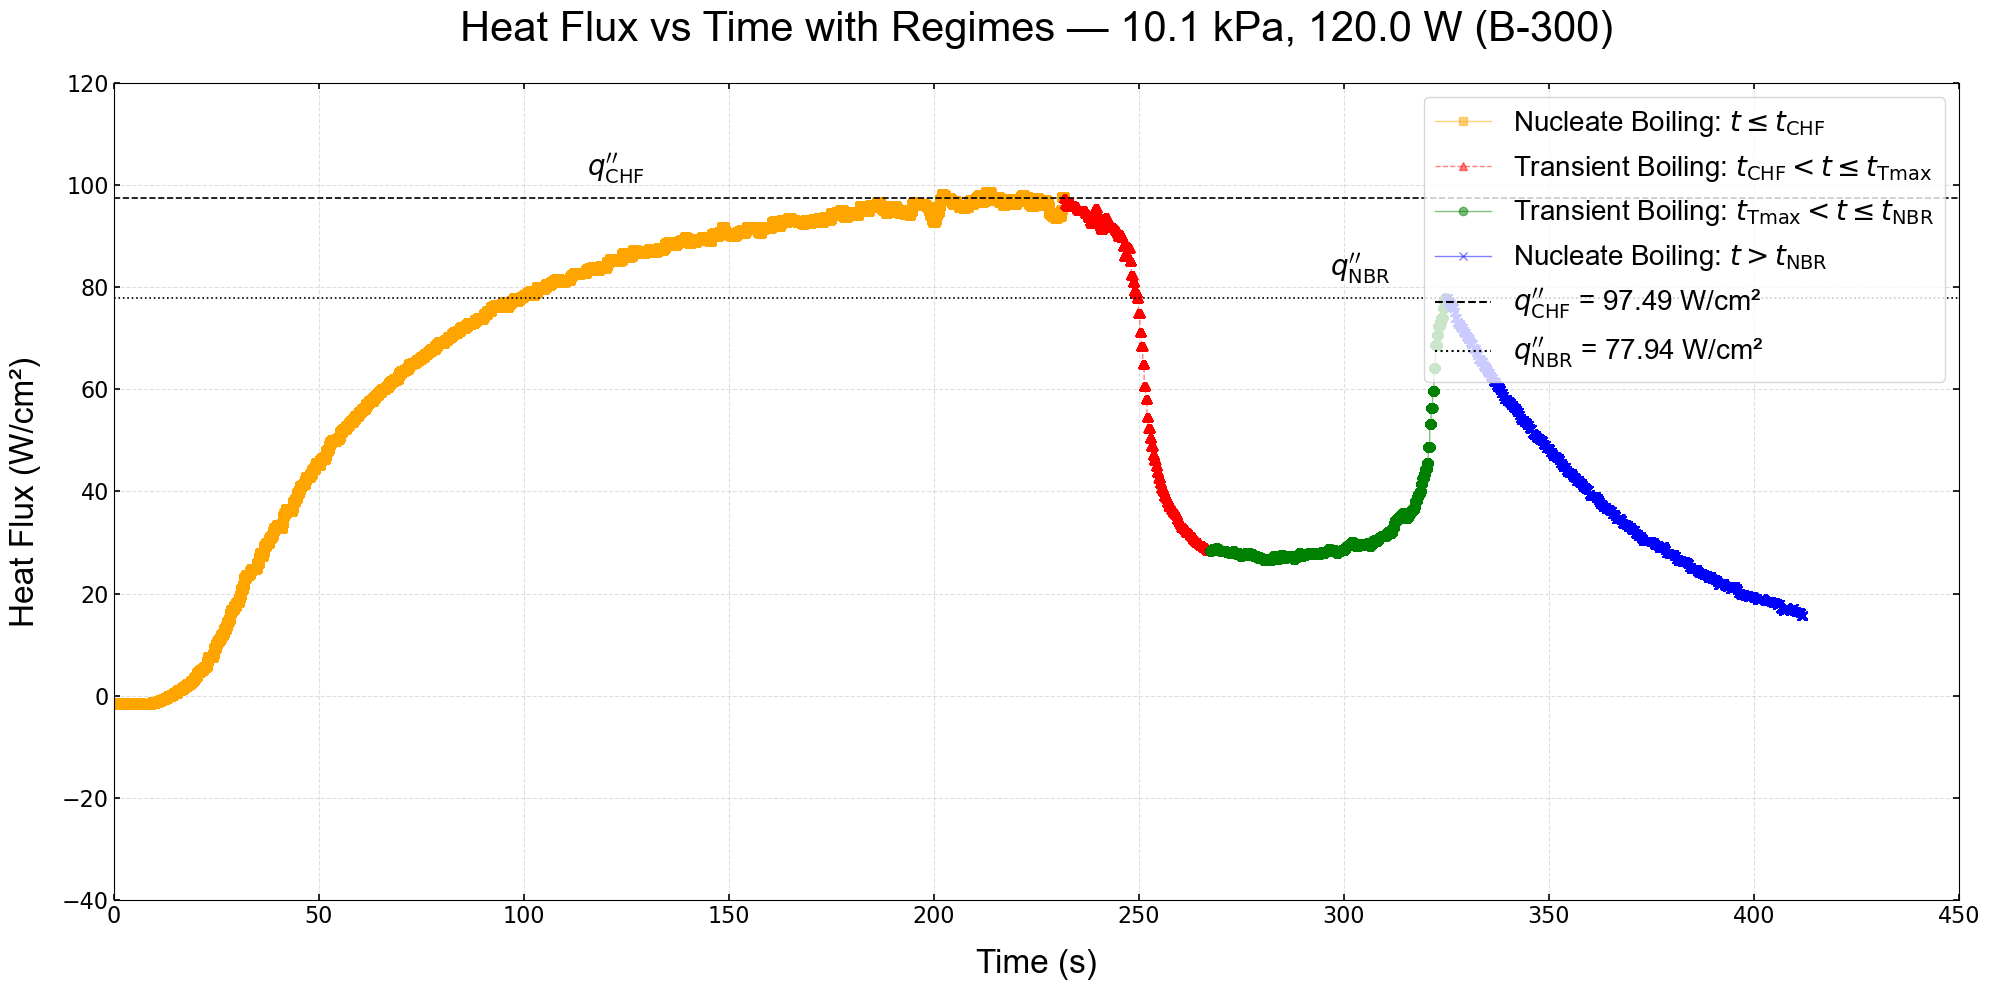

In [697]:
plt.figure(figsize=(20, 10))

# --- Key instants/values ---
t_chf  = float(chf_time)
t_tmax = float(time_at_max_Surface_Temperature)  # already computed earlier
t_nbr  = float(nbr_time)
q_chf  = float(chf_value)
q_nbr  = float(nbr_value)

# --- Four time-regime masks ---
m_nb1 = (time_temp <= t_chf)                              # NB: t ≤ t_CHF
m_tb1 = (time_temp >  t_chf) & (time_temp <= t_tmax)      # TB: t_CHF < t ≤ t_Tmax
m_tb2 = (time_temp >  t_tmax) & (time_temp <= t_nbr)      # TB: t_Tmax < t ≤ t_NBR
m_nb2 = (time_temp >  t_nbr)                              # NB: t > t_NBR

# --- Plot each regime with SAME markers/colors as before ---
if np.any(m_nb1):
    plt.plot(time_temp[m_nb1], q[m_nb1],
             linestyle='-', marker='s', markersize=6, linewidth=1, alpha=0.5,
             color='orange', label=r'Nucleate Boiling: $t \leq t_{\mathrm{CHF}}$')

if np.any(m_tb1):
    plt.plot(time_temp[m_tb1], q[m_tb1],
             linestyle='--', marker='^', markersize=6, linewidth=1, alpha=0.5,
             color='red', label=r'Transient Boiling: $t_{\mathrm{CHF}} < t \leq t_{\mathrm{Tmax}}$')

if np.any(m_tb2):
    plt.plot(time_temp[m_tb2], q[m_tb2],
             linestyle='-', marker='o', markersize=6, linewidth=1, alpha=0.5,
             color='green', label=r'Transient Boiling: $t_{\mathrm{Tmax}} < t \leq t_{\mathrm{NBR}}$')

if np.any(m_nb2):
    plt.plot(time_temp[m_nb2], q[m_nb2],
             linestyle='-', marker='x', markersize=6, linewidth=1, alpha=0.5,
             color='blue', label=r'Nucleate Boiling: $t > t_{\mathrm{NBR}}$')

# --- Reference lines (CHF / NBR / Tmax) ---
#plt.axvline(x=t_chf,  color='black', linestyle='--', linewidth=1.2, label='t_CHF')
#plt.axvline(x=t_tmax, color='black', linestyle='-.', linewidth=1.2, label='t_Tmax')
#plt.axvline(x=t_nbr,  color='black', linestyle=':',  linewidth=1.2, label='t_NBR')

ax = plt.gca()

# Put labels at 3% from the left; change 0.03 → 0.98 for right edge, etc.
xmin, xmax = ax.get_xlim()
xpos = lambda frac: xmin + frac * (xmax - xmin)

# CHF line label (italic q, superscript '', upright CHF subscript)
ax.text(xpos(0.3), q_chf + 2, r"$q^{\prime\prime}_{\mathrm{CHF}}$",fontsize=20, ha='left', va='bottom')

# NBR line label
ax.text(xpos(0.7), q_nbr + 2, r"$q^{\prime\prime}_{\mathrm{NBR}}$",fontsize=20, ha='left', va='bottom')

# Horizontal dashed lines at q''_CHF and q''_nbr (using your chf_value / nbr_value)
ax.axhline(q_chf, linestyle='--', linewidth=1.2, color='black')
ax.axhline(q_nbr, linestyle=':', linewidth=1.2, color='black')

# --- Axis labels and title ---
plt.xlabel("Time (s)", fontsize=24, fontname='Arial', labelpad=15)
plt.ylabel("Heat Flux (W/cm²)", fontsize=24, fontname='Arial', labelpad=15)
plt.title(f"Heat Flux vs Time with Regimes — {pressure_mean_kPa} kPa, {applied_heat_load} W (B-{boiling_id})",
          fontsize=30, pad=30, fontname='Arial')

#ax = plt.gca()

# --- X ticks/limits (keep your logic) ---
x_tick_start = x_step_time * np.floor(tmin / x_step_time)
x_tick_end   = x_step_time * np.ceil (tmax / x_step_time)
if x_tick_start >= tmin:
    x_tick_start -= 0
if x_tick_end <= tmax:
    x_tick_end += x_step_time
ax.set_xlim(x_tick_start, x_tick_end)
ax.set_xticks(np.arange(x_tick_start, x_tick_end + x_step_time, x_step_time))

# --- Y ticks/limits (keep your logic) ---
y_tick_start = y_step_q * np.floor(ymin_q / y_step_q)
y_tick_end   = y_step_q * np.ceil (ymax_q / y_step_q)
if y_tick_start >= ymin_q:
    y_tick_start -= y_step_q
if y_tick_end <= ymax_q:
    y_tick_end += y_step_q
ax.set_ylim(y_tick_start, y_tick_end)
ax.set_yticks(np.arange(y_tick_start - y_step_q, y_tick_end + 2*y_step_q, y_step_q))

# --- Grid / ticks / legend ---
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.4)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, width=1.2, length=4)

# Add legend entries with q'' values (dummy handles)
ax.plot([], [], linestyle='--', color='black',
        label=r"$q^{\prime\prime}_{\mathrm{CHF}}$ = " + f"{q_chf:.2f} W/cm²")
ax.plot([], [], linestyle=':', color='black',
        label=r"$q^{\prime\prime}_{\mathrm{NBR}}$ = " + f"{q_nbr:.2f} W/cm²")

plt.legend(prop={'family':'Arial','size':20}, loc='upper right')
plt.tight_layout()

# Save figure
saved_figures.append((f"6_Boiling Regimes 4_{pressure_mean_kPa}kPa_B-{boiling_id}", plt.gcf()))
plt.show()


In [698]:
raise Exception

Exception: 

#### Heat Loss

Max Heat Flux = 98.63 W/cm² at 213.14 s


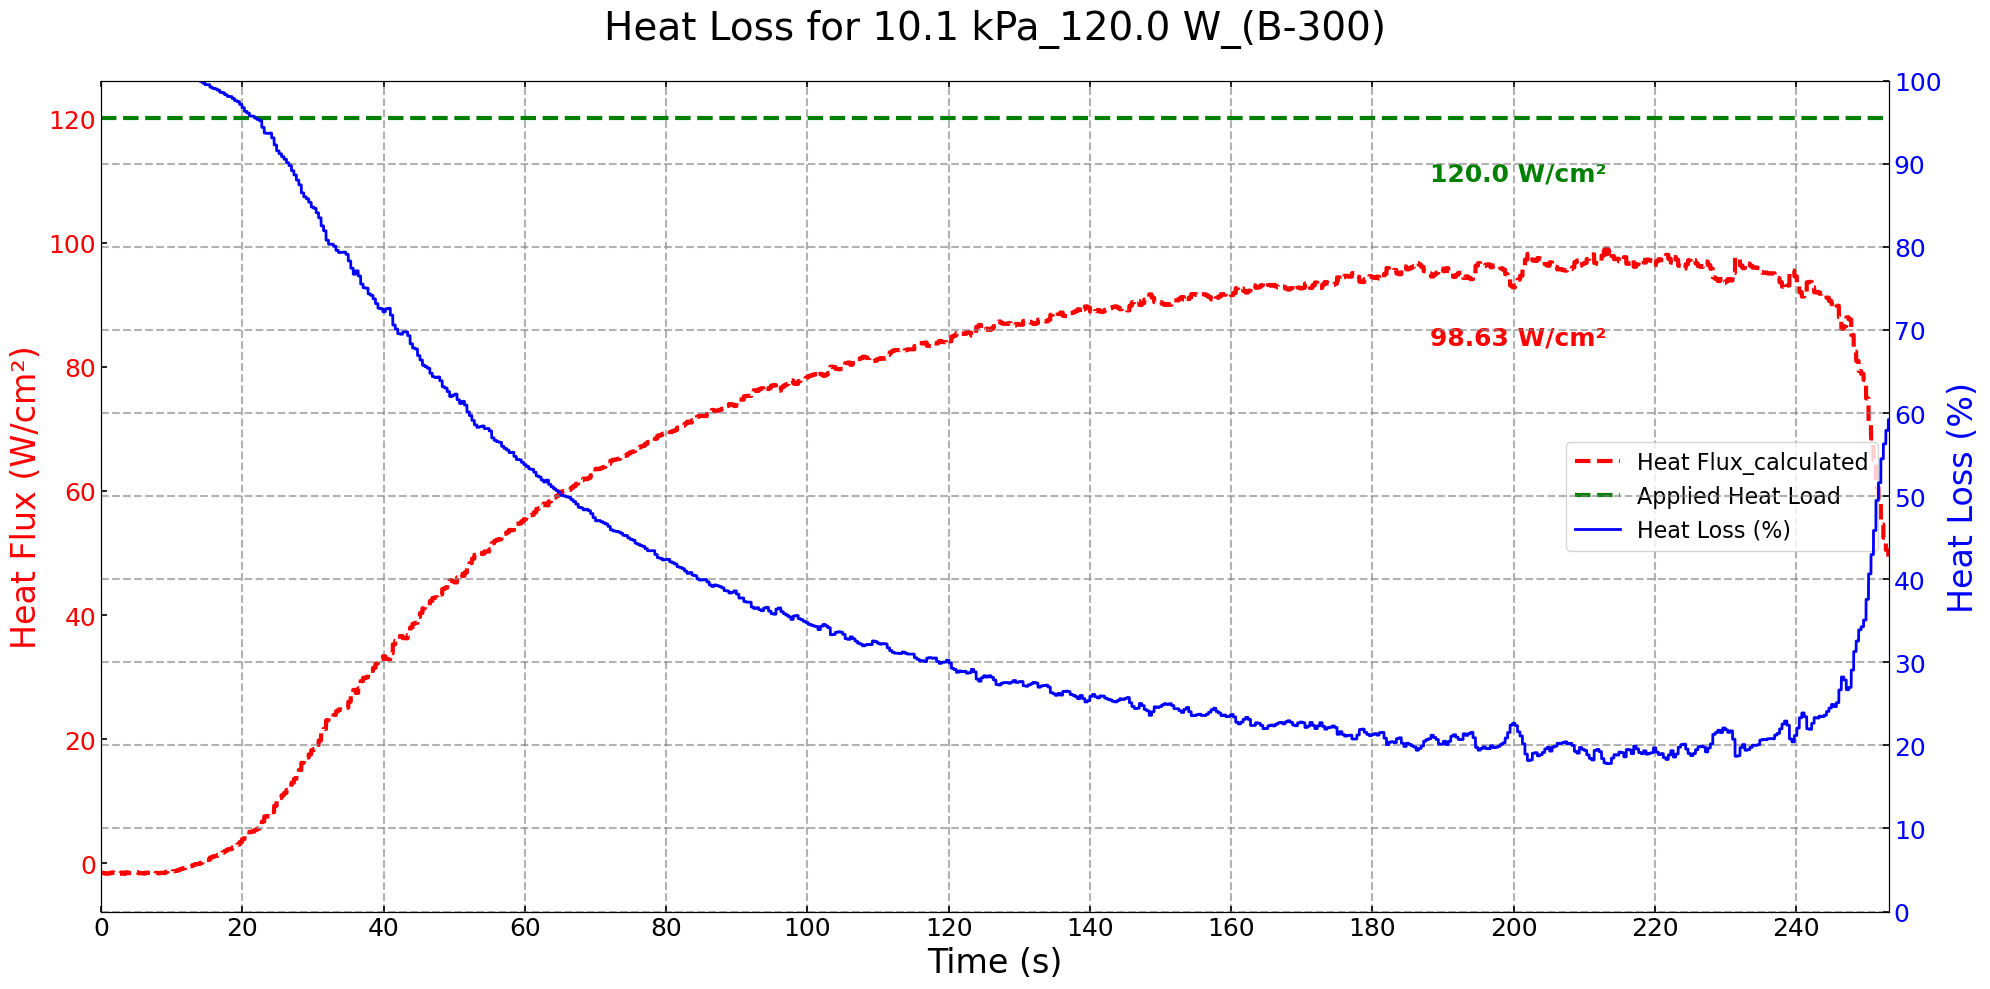

In [699]:
max_q = np.max(q)
time_at_max_q = time_temp[np.argmax(q)]
print(f"Max Heat Flux = {max_q:.2f} W/cm² at {time_at_max_q:.2f} s")

fig, ax1 = plt.subplots(figsize=(20, 10))

# 🔴 Heat Flux
ax1.plot(time_temp, q, color='red', linewidth=3, linestyle='--', label="Heat Flux_calculated")
ax1.set_xlabel("Time (s)", fontsize=24)
ax1.set_ylabel("Heat Flux (W/cm²)", fontsize=24, color='red')
ax1.tick_params(axis='y', labelcolor='red')
# X axis (shared): show ticks on top & bottom, point inward
ax1.tick_params(axis='x', which='both', direction='in', top=True, width=1.2, length=4)

# Left Y (ax1): inward on the left only (avoid right to prevent duplicates with ax2/ax3)
ax1.tick_params(axis='y', which='both', direction='in', left=True, right=False, width=1.2, length=4)

# 🔵 Heat Loss (%)
# Ask the user for applied heat load
#applied_heat_load = float(input("Enter applied heat load (W/cm^2): "))

# Add text slightly below the curve
ax1.text(time_at_max_q, applied_heat_load - 10,   # adjust -15 as offset
         f"{applied_heat_load} W/cm²",
         color='green', fontsize=18, ha='right',fontweight='bold')

ax1.axhline(y=applied_heat_load, color='green', linestyle='--', linewidth=3, label="Applied Heat Load")

heat_loss_percent = (applied_heat_load - q) / applied_heat_load * 100

ax2 = ax1.twinx()
ax2.plot(time_temp, heat_loss_percent, color='blue', linewidth=2, label="Heat Loss (%)")
ax2.set_ylabel("Heat Loss (%)", fontsize=24, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_yticks(np.arange(0, 101, 10))
ax2.set_ylim(0, 100) 

ax1.tick_params(axis='both', labelsize=18)  # Left y-axis + x-axis
ax2.tick_params(axis='y', labelsize=18)     # Right y-axis


ax2.tick_params(axis='y', which='both', direction='in', left=False, right=True, width=1.2, length=4)

# Mark the max point on Heat Flux curve
ax1.plot(time_at_max_q, max_q, 'ro')  # optional: mark the point with a red dot

# Add text slightly below the curve
ax1.text(time_at_max_q, max_q - 15,   # adjust -15 as offset
         f"{max_q:.2f} W/cm²",
         color='red', fontsize=18, ha='right',fontweight='bold')


# X ticks
tick_positions = np.arange(time_temp.min(), time_at_max_q + 50, 20)
ax1.set_xticks(tick_positions)

# Grid
#ax1.grid(True, linestyle='--', color='gray', alpha=0.8, linewidth=1.5)
ax1.grid(False)  # turn off left-y grid
ax2.yaxis.grid(True, linestyle='--', color='gray', alpha=0.6, linewidth=1.5)  # grid from right y-axis ticks
ax1.xaxis.grid(True, linestyle='--', color='gray', alpha=0.6, linewidth=1.5)  # keep vertical x-grid (optional)

plt.title(f"Heat Loss for {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=28, pad=30)

# Force x-axis only until max_q
ax1.set_xlim(time_temp.min(), time_at_max_q+40)


# Collect labels/handles from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# Merge them
ax1.legend(lines1 + lines2, labels1 + labels2, loc='right', fontsize=16)


plt.tight_layout()
plt.show()

### Heat Transfer Coeffient (HTC)

In [700]:
print(
    f"len(time_temp)={len(time_temp)}, "
    f"len(Surface_Temperature)={len(Surface_Temperature)}, "
    f"len(q)={len(q)}, "
    f"len(htc)={len(htc)}"
)

len(time_temp)=1236000, len(Surface_Temperature)=1236000, len(q)=1236000, len(htc)=1236000


In [701]:
# Step 1: Find the cutoff index
cutoff_index = np.argmax(time_temp > chf_time)  # first index where time exceeds CHF time
cutoff_index
# Step 2: Slice arrays up to cutoff
T_surface_cut = Surface_Temperature[:cutoff_index]
q_cut = q[:cutoff_index]
htc_cut = htc[:cutoff_index]
# Wall Superheat
delta_T = Surface_Temperature - T_sat
delta_T_cut = T_surface_cut - T_sat

#### Splitting operations for HTC array

In [702]:
# ===== Configurable window start (seconds) =====
window_start = 30.0   # ← change to 40.0 or 50.0 as needed

# --- Align to CHF sample ---
idx_chf = int(np.nanargmin(np.abs(time_temp - chf_time)))
t_chf_aligned = float(time_temp[idx_chf])
htc_at_chf = float(htc[idx_chf])
print(f"HTC at CHF is {htc_at_chf:.2f} W/cm²·K at t = {t_chf_aligned:.2f} s")

# First sample strictly AFTER CHF (so CHF isn’t duplicated in both slices)
chf_cut = np.searchsorted(time_temp, chf_time, side='right')

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# 1) 0 → CHF   (includes any samples exactly at CHF)
htc_0_to_chf = np.column_stack((time_temp[:chf_cut], htc[:chf_cut]))

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# 2) window_start → CHF  (includes CHF; empty if chf_time < window_start)
mask_ws_chf = (time_temp >= window_start) & (time_temp <= chf_time)
# keep original variable names but use the configurable window_start
htc_ws_to_chf = np.column_stack((time_temp[mask_ws_chf], htc[mask_ws_chf]))
q_ws_to_chf = np.column_stack((time_temp[mask_ws_chf], q[mask_ws_chf]))
tsurf_ws_to_chf = np.column_stack((time_temp[mask_ws_chf], Surface_Temperature[mask_ws_chf]))
wall_superheat_ws_to_chf = np.column_stack((time_temp[mask_ws_chf], delta_T[mask_ws_chf]))

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# 3) CHF → end (strictly after CHF; no overlap)
htc_chf_to_end = np.column_stack((time_temp[chf_cut:], htc[chf_cut:]))

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# 4) CHF+10 s → end (skip first 10 s after CHF)
chf10_cut = np.searchsorted(time_temp, chf_time + 20, side='right')
htc_chfplus10s_to_end = np.column_stack((time_temp[chf10_cut:], htc[chf10_cut:]))

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# 5) window_start → END  (no CHF cutoff)
mask_ws_end = (time_temp >= window_start)
# keep original names but use the configurable window_start
htc_ws_to_end = np.column_stack((time_temp[mask_ws_end], htc[mask_ws_end]))
htc_MAX_ws_to_end = np.nanmax(htc_ws_to_end[:, 1]) if htc_ws_to_end.size else np.nan
htc_MIN_ws_to_end = np.nanmin(htc_ws_to_end[:, 1]) if htc_ws_to_end.size else np.nan
q_ws_to_end = np.column_stack((time_temp[mask_ws_end], q[mask_ws_end]))
tsurf_ws_to_end = np.column_stack((time_temp[mask_ws_end], Surface_Temperature[mask_ws_end]))
wall_superheat_ws_to_end = np.column_stack((time_temp[mask_ws_end], delta_T[mask_ws_end]))

# ---- window_start → CHF ----
if htc_ws_to_chf.size:
    t_ws_to_chf = htc_ws_to_chf[:, 0]
    h_ws_to_chf = htc_ws_to_chf[:, 1]

    htc_MAX_ws_to_chf = np.nanmax(h_ws_to_chf)
    time_MAX_ws_to_chf = t_ws_to_chf[np.nanargmax(h_ws_to_chf)]

    htc_MIN_ws_to_chf = np.nanmin(h_ws_to_chf)
    time_MIN_ws_to_chf = t_ws_to_chf[np.nanargmin(h_ws_to_chf)]

    print(f"{window_start:.0f}→CHF  | MAX HTC = {htc_MAX_ws_to_chf:.2f} W/cm²·K at t = {time_MAX_ws_to_chf:.2f} s")
    print(f"{window_start:.0f}→CHF  | MIN HTC = {htc_MIN_ws_to_chf:.2f} W/cm²·K at t = {time_MIN_ws_to_chf:.2f} s")
else:
    print(f"{window_start:.0f}→CHF  | empty slice")

# ---- CHF+10 s → end ----
if htc_chfplus10s_to_end.size:
    t_chf_to_end = htc_chfplus10s_to_end[:, 0]
    h_chf_to_end = htc_chfplus10s_to_end[:, 1]

    htc_MAX_chf_to_end = np.nanmax(h_chf_to_end)
    time_MAX_chf_to_end = t_chf_to_end[np.nanargmax(h_chf_to_end)]

    htc_MIN_chf_to_end = np.nanmin(h_chf_to_end)
    time_MIN_chf_to_end = t_chf_to_end[np.nanargmin(h_chf_to_end)]

    print(f"CHF→end (+10 s) | MAX HTC = {htc_MAX_chf_to_end:.2f} W/cm²·K at t = {time_MAX_chf_to_end:.2f} s")
    print(f"CHF→end (+10 s) | MIN HTC = {htc_MIN_chf_to_end:.2f} W/cm²·K at t = {time_MIN_chf_to_end:.2f} s")
else:
    print("CHF→end (+10 s) | empty slice")

# ---- Global comparisons ----
max_list, min_list = [], []

if htc_ws_to_chf.size:
    max_list.append((f"{window_start:.0f}→CHF", htc_MAX_ws_to_chf, time_MAX_ws_to_chf))
    min_list.append((f"{window_start:.0f}→CHF", htc_MIN_ws_to_chf, time_MIN_ws_to_chf))

# (use the +10s slice since those stats were computed)
if htc_chfplus10s_to_end.size:
    max_list.append(("CHF (+10 s)→end", htc_MAX_chf_to_end, time_MAX_chf_to_end))
    min_list.append(("CHF (+10 s)→end", htc_MIN_chf_to_end, time_MIN_chf_to_end))

if max_list:
    seg_max, val_max, t_max = max(max_list, key=lambda x: x[1])
    print(f"GLOBAL MAX: {val_max:.2f} W/cm²·K at t = {t_max:.2f} s ({seg_max})")
else:
    print("GLOBAL MAX: no data")

if min_list:
    seg_min, val_min, t_min = min(min_list, key=lambda x: x[1])
    print(f"GLOBAL MIN: {val_min:.2f} W/cm²·K at t = {t_min:.2f} s ({seg_min})")
else:
    print("GLOBAL MIN: no data")

HTC at CHF is 3.30 W/cm²·K at t = 231.84 s
30→CHF  | MAX HTC = 4.06 W/cm²·K at t = 92.40 s
30→CHF  | MIN HTC = 1.73 W/cm²·K at t = 30.10 s
CHF→end (+10 s) | MAX HTC = 3.50 W/cm²·K at t = 330.39 s
CHF→end (+10 s) | MIN HTC = 0.35 W/cm²·K at t = 280.34 s
GLOBAL MAX: 4.06 W/cm²·K at t = 92.40 s (30→CHF)
GLOBAL MIN: 0.35 W/cm²·K at t = 280.34 s (CHF (+10 s)→end)


In [703]:
htc_MIN_ws_to_end 
htc_MAX_ws_to_end 

# Y step
if (htc_MAX_ws_to_end - htc_MIN_ws_to_end) > 3:
    x_step_htc = 1
    y_step_htc = 1
else:
    x_step_htc = 0.5
    y_step_htc = 0.5
print(f"y_step_htc chosen = {y_step_htc} W/cm²·K (Δq range = {htc_MAX_ws_to_end - htc_MIN_ws_to_end:.2f} W/cm²·K)")

y_step_htc chosen = 1 W/cm²·K (Δq range = 3.72 W/cm²·K)


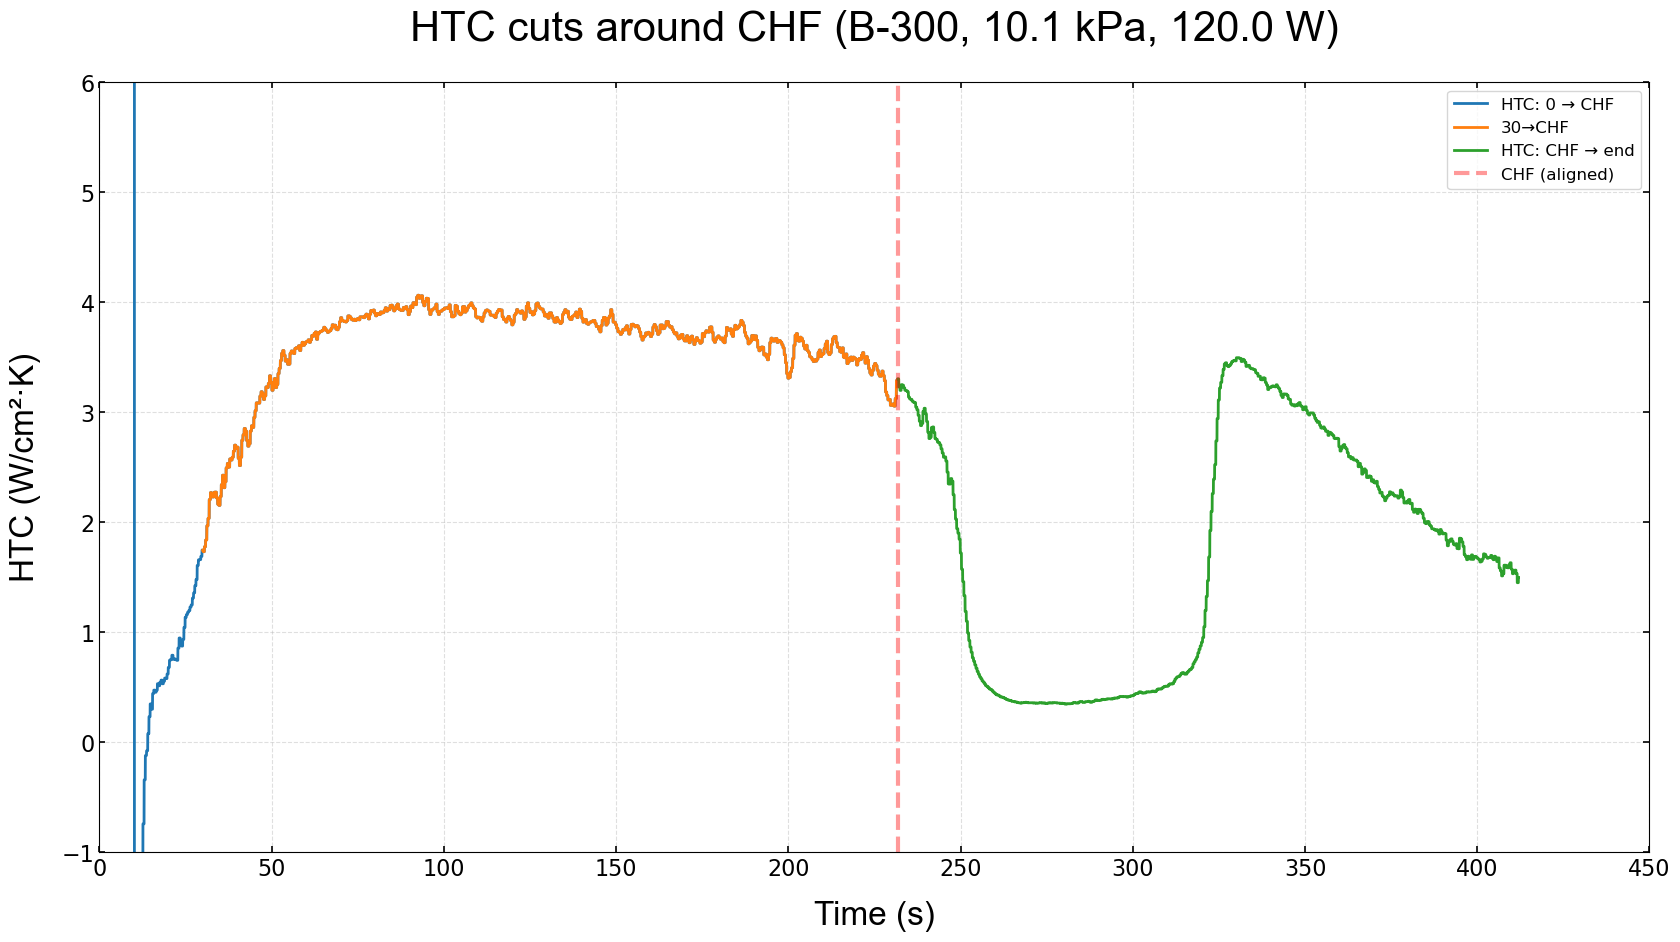

50

In [704]:
plt.figure(figsize=(20, 10))

# Plot each cut with a distinct style/color
if htc_0_to_chf.size:
    plt.plot(htc_0_to_chf[:,0], htc_0_to_chf[:,1],color='tab:blue', linewidth=2, label='HTC: 0 → CHF')

if htc_ws_to_chf.size:
    plt.plot(htc_ws_to_chf[:,0], htc_ws_to_chf[:,1],color='tab:orange', linewidth=2, label=f"{window_start:.0f}→CHF")

if htc_chf_to_end.size:
    plt.plot(htc_chf_to_end[:,0], htc_chf_to_end[:,1],color='tab:green', linewidth=2, label='HTC: CHF → end')

# Optional: vertical line at CHF (nearest sampled)
idx_chf = int(np.nanargmin(np.abs(time_temp - chf_time)))
t_chf_aligned = float(time_temp[idx_chf])
plt.axvline(t_chf_aligned, linestyle='--', linewidth=3, color='red', alpha=0.4, label='CHF (aligned)')

# Labels, title, legend
plt.xlabel("Time (s)", fontsize=24, fontname='Arial', labelpad=15)
plt.ylabel("HTC (W/cm²·K)", fontsize=24, fontname='Arial', labelpad=15)
plt.title(f"HTC cuts around CHF (B-{boiling_id}, {pressure_mean_kPa} kPa, {applied_heat_load} W)", fontsize=30, pad=30, fontname='Arial')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)

ax = plt.gca()

x_tick_start = x_step_time * np.floor(tmin / x_step_time)
x_tick_end   = x_step_time * np.ceil(tmax / x_step_time)
if x_tick_start >= tmin:
    x_tick_start -= 0
if x_tick_end <= tmax:
    x_tick_end += x_step_time

# set new axis limits and ticks
ax.set_xlim(x_tick_start, x_tick_end)
ax.set_xticks(np.arange(x_tick_start, x_tick_end + x_step_time, x_step_time))

# ---- Y-axis: integer ticks from (val_min - 1) to (val_max + 1) ----
y_bottom = int(np.floor(val_min)) - 1
y_top    = int(np.ceil(val_max)) + 1

# Guard against a zero-height range
if y_bottom >= y_top:
    y_bottom -= 1
    y_top    += 1

plt.ylim(y_bottom, y_top)
plt.yticks(np.arange(y_bottom, y_top + 1, 1))

plt.xticks(fontsize=16)  # Increase x-axis tick size
plt.yticks(fontsize=16)  # Increase y-axis tick size

ax = plt.gca()
ax.tick_params(axis='both', which='both', direction='in',top=True, right=True, width=1.2, length=4)

plt.show()

x_step_time


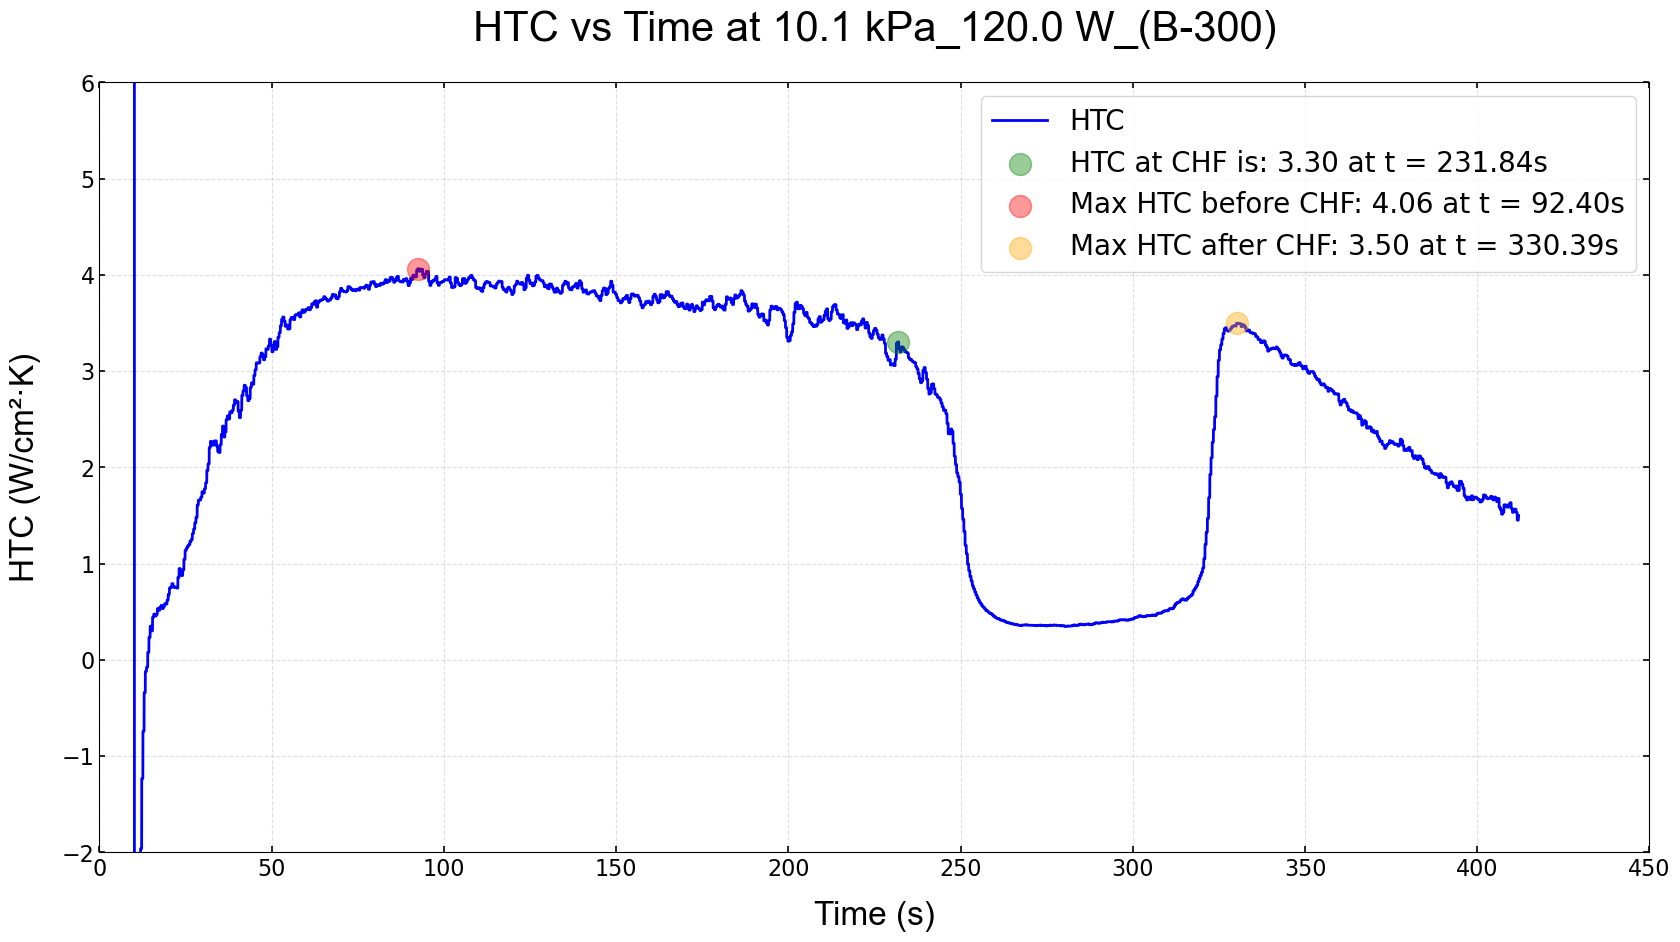

In [705]:
# --- Plot ---
plt.figure(figsize=(20, 10))

# HTC curve
plt.plot(time_temp, htc, color='blue', linewidth=2, label="HTC")

# Scatter at CHF (green) with value in legend
label_chf = f"HTC at CHF is: {htc_at_chf:.2f} at t = {t_chf_aligned:.2f}s"


plt.scatter(t_chf_aligned, htc_at_chf, color='green', s = 250, alpha=0.4,zorder=5, label=label_chf)

# Scatter at HTC_max (orange) with value in legend (only if computed)
label_max = f"Max HTC before CHF: {htc_MAX_ws_to_chf:.2f} at t = {time_MAX_ws_to_chf:.2f}s"
plt.scatter(time_MAX_ws_to_chf, htc_MAX_ws_to_chf, color='red', s = 250, alpha=0.4,zorder=6, label=label_max)
    
# Scatter at HTC_max (orange) with value in legend (only if computed)
label_max = f"Max HTC after CHF: {htc_MAX_chf_to_end:.2f} at t = {time_MAX_chf_to_end:.2f}s"
plt.scatter(time_MAX_chf_to_end, htc_MAX_chf_to_end, color='orange', s = 250, alpha=0.4,zorder=6, label=label_max)

# Axes, ticks, grid
#plt.xlim(time_temp.min(), time_temp.max())
plt.xlabel("Time (s)", fontsize=24, labelpad=15, fontname='Arial')
plt.ylabel("HTC (W/cm²·K)", fontsize=24, labelpad=15, fontname='Arial')
plt.title(f"HTC vs Time at {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=30, pad=30, fontname='Arial')

ax = plt.gca()



x_tick_start = x_step_time * np.floor(tmin / x_step_time)
x_tick_end   = x_step_time * np.ceil(tmax / x_step_time)
if x_tick_start >= tmin:
    x_tick_start -= 0
if x_tick_end <= tmax:
    x_tick_end += x_step_time

# set new axis limits and ticks
ax.set_xlim(x_tick_start, x_tick_end)
ax.set_xticks(np.arange(x_tick_start, x_tick_end + x_step_time, x_step_time))



## y-axis ticks ##
y_tick_start = y_step_htc * np.floor(htc_MIN_ws_to_end / y_step_htc)
y_tick_end   = y_step_htc * np.ceil(htc_MAX_ws_to_end / y_step_htc)
if y_tick_start >= htc_MIN_ws_to_end:
    y_tick_start -= y_step_htc
if y_tick_end <= htc_MAX_ws_to_end:
    y_tick_end += y_step_htc

# set new y-limits and ticks
ax.set_ylim(y_tick_start-y_step_htc, y_tick_end)
ax.set_yticks(np.arange(y_tick_start-2*y_step_htc, y_tick_end +2*y_step_htc, y_step_htc))


# set new y-limits and ticks
#ax.set_ylim(0, y_tick_end)
#ax.set_yticks(np.arange(0, y_tick_end +2*y_step_htc, y_step_htc))

plt.xticks(fontsize=16)  # Increase x-axis tick size
plt.yticks(fontsize=16)  # Increase y-axis tick size

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=20, loc='upper right')

ax = plt.gca()
ax.tick_params(axis='both', which='both', direction='in',top=True, right=True, width=1.2, length=4)

# Save
saved_figures.append((f"7_HTC VS Time_{pressure_mean_kPa}kPa_B-{boiling_id}", plt.gcf()))
plt.show()


## Super-imposition of Heat Flux, HTC & Surface Temperature

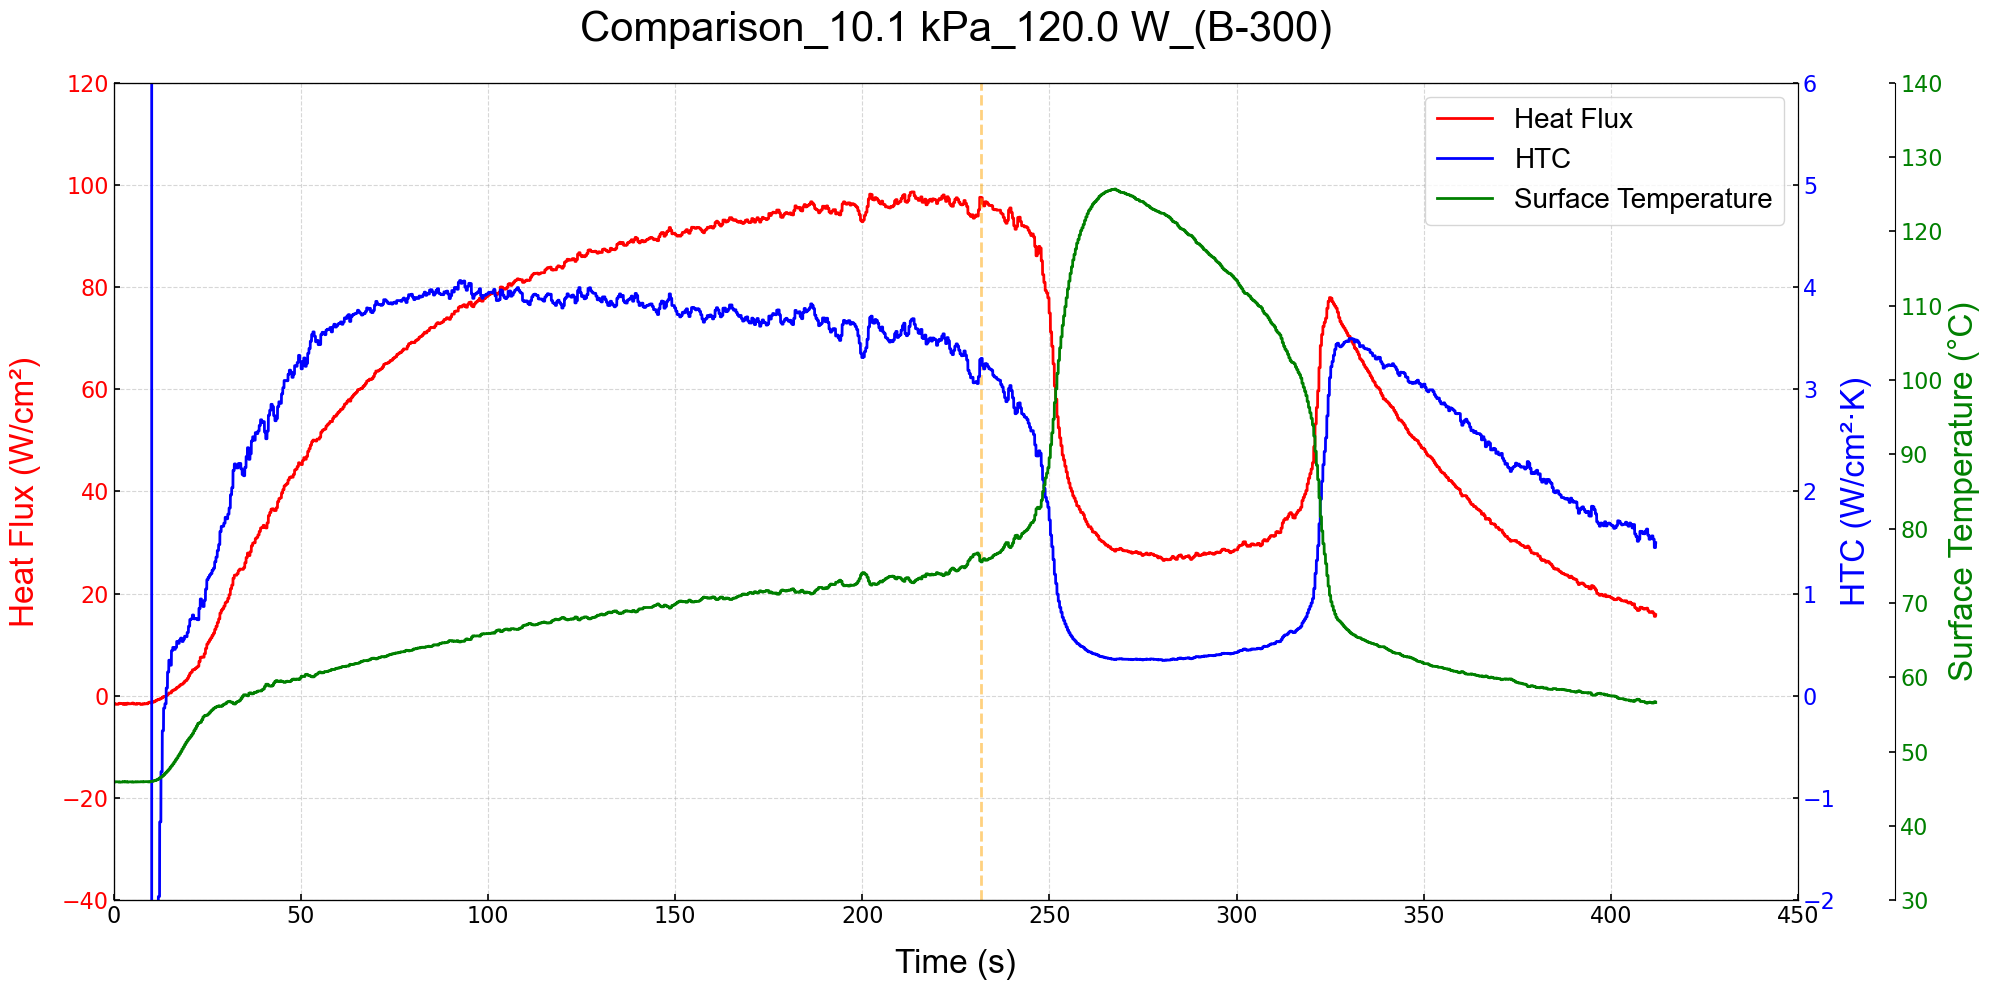

In [706]:
fig, ax1 = plt.subplots(figsize=(20, 10))

# --- 🔴 Left Y-axis: Heat Flux ---
ax1.set_xlabel('Time (s)', fontsize=24, fontname='Arial', labelpad=15)
ax1.set_ylabel('Heat Flux (W/cm²)', color='red', fontsize=24, fontname='Arial', labelpad=15)
l1, = ax1.plot(time_temp, q, color='red', label='Heat Flux', linewidth=2)
ax1.tick_params(axis='x', labelcolor='black', labelsize=16)
ax1.tick_params(axis='y', labelcolor='red', labelsize=16)


# Add a vertical orange line at CHF time with transparency
ax1.axvline(
    x=chf_time, 
    color='orange', 
    linestyle='--', 
    linewidth=2, 
    alpha=0.5,         # Transparency
    label='CHF Time'
)



# --- 🔵 Second Y-axis (right): HTC ---
ax2 = ax1.twinx()
ax2.set_ylabel('HTC (W/cm²·K)', color='blue', fontsize=24, fontname='Arial')
l2, = ax2.plot(time_temp, htc, color='blue', label='HTC', linewidth=2)
ax2.tick_params(axis='y', labelcolor='blue', labelsize=16)
ax2.tick_params(axis='y', which='both', direction='in', left=False, right=True, width=1.2)

# Center the HTC axis around the HTC value at CHF 

ax2.set_ylim(y_bottom , y_top)
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))  # force integer ticks

# --- 🟢 Third Y-axis (right): Surface Temperature ---
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 70))  # Move third axis outward
ax3.set_ylabel('Surface Temperature (°C)', color='green', fontsize=24, fontname='Arial')
l3, = ax3.plot(time_temp, Surface_Temperature, color='green', label='Surface Temperature', linewidth=2)
ax3.tick_params(axis='y', labelcolor='green', labelsize=16)
ax3.tick_params(axis='y', which='both', direction='in', left=False, right=True, width=1.2, length=4)

# Title and Grid
plt.title(f"Comparison_{pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=30, pad=30, fontname='Arial')
ax1.grid(True, linestyle='--', alpha=0.5)

# Combine legends from all three axes
lines = [l1, l2, l3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right',prop={'family': 'Arial', 'size': 20},frameon=True)

# X-axis limits
ax = plt.gca()


## x-axis ticks ##
x_tick_start = x_step_time * np.floor(tmin / x_step_time)
x_tick_end   = x_step_time * np.ceil(tmax / x_step_time)
if x_tick_start >= tmin:
    x_tick_start -= 0
if x_tick_end <= tmax:
    x_tick_end += x_step_time

# set new axis limits and ticks
ax1.set_xlim(x_tick_start, x_tick_end)
ax1.set_xticks(np.arange(x_tick_start, x_tick_end + x_step_time, x_step_time))


## y-axis ticks ##
y_tick_start = y_step_q * np.floor(ymin_q / y_step_q)
y_tick_end   = y_step_q * np.ceil(ymax_q / y_step_q)
if y_tick_start >= ymin_q:
    y_tick_start -= y_step_q
if y_tick_end <= ymax_q:
    y_tick_end += y_step_q

# set new y-limits and ticks
ax1.set_ylim(y_tick_start, y_tick_end)
ax1.set_yticks(np.arange(y_tick_start-y_step_q, y_tick_end +2*y_step_q, y_step_q))


## y-axis ticks ##
y_tick_start = y_step_htc * np.floor(htc_MIN_ws_to_end / y_step_htc)
y_tick_end   = y_step_htc * np.ceil(htc_MAX_ws_to_end / y_step_htc)
if y_tick_start >= htc_MIN_ws_to_end:
    y_tick_start -= y_step_htc
if y_tick_end <= htc_MAX_ws_to_end:
    y_tick_end += y_step_htc

# set new y-limits and ticks
ax2.set_ylim(y_tick_start-y_step_htc, y_tick_end)
ax2.set_yticks(np.arange(y_tick_start-2*y_step_htc, y_tick_end +2*y_step_htc, y_step_htc))

# Only bottom x-ticks
ax1.tick_params(axis='x', which='both',bottom=True, top=False,direction='in', width=1.2, length=4)

# Only left y-ticks
ax1.tick_params(axis='y', which='both',left=True, right=False,direction='in', width=1.2, length=4)

y_tick_start = y_step_temp * np.floor(ymin_Temp / y_step_temp)
y_tick_end   = y_step_temp * np.ceil(ymax_Temp / y_step_temp)
if y_tick_start >= ymin_Temp:
    y_tick_start -= y_step_temp
if y_tick_end <= ymax_Temp:
    y_tick_end += y_step_temp

# set new y-limits and ticks
ax3.set_ylim(y_tick_start, y_tick_end)
ax3.set_yticks(np.arange(y_tick_start-y_step_temp, y_tick_end +1*y_step_temp, y_step_temp))
    
plt.tight_layout()

# Save figure (use a tuple)
saved_figures.append((f"8_Comparison_{pressure_mean_kPa}kPa_B-{boiling_id}", plt.gcf()))

plt.show()


## Pressure Analysis

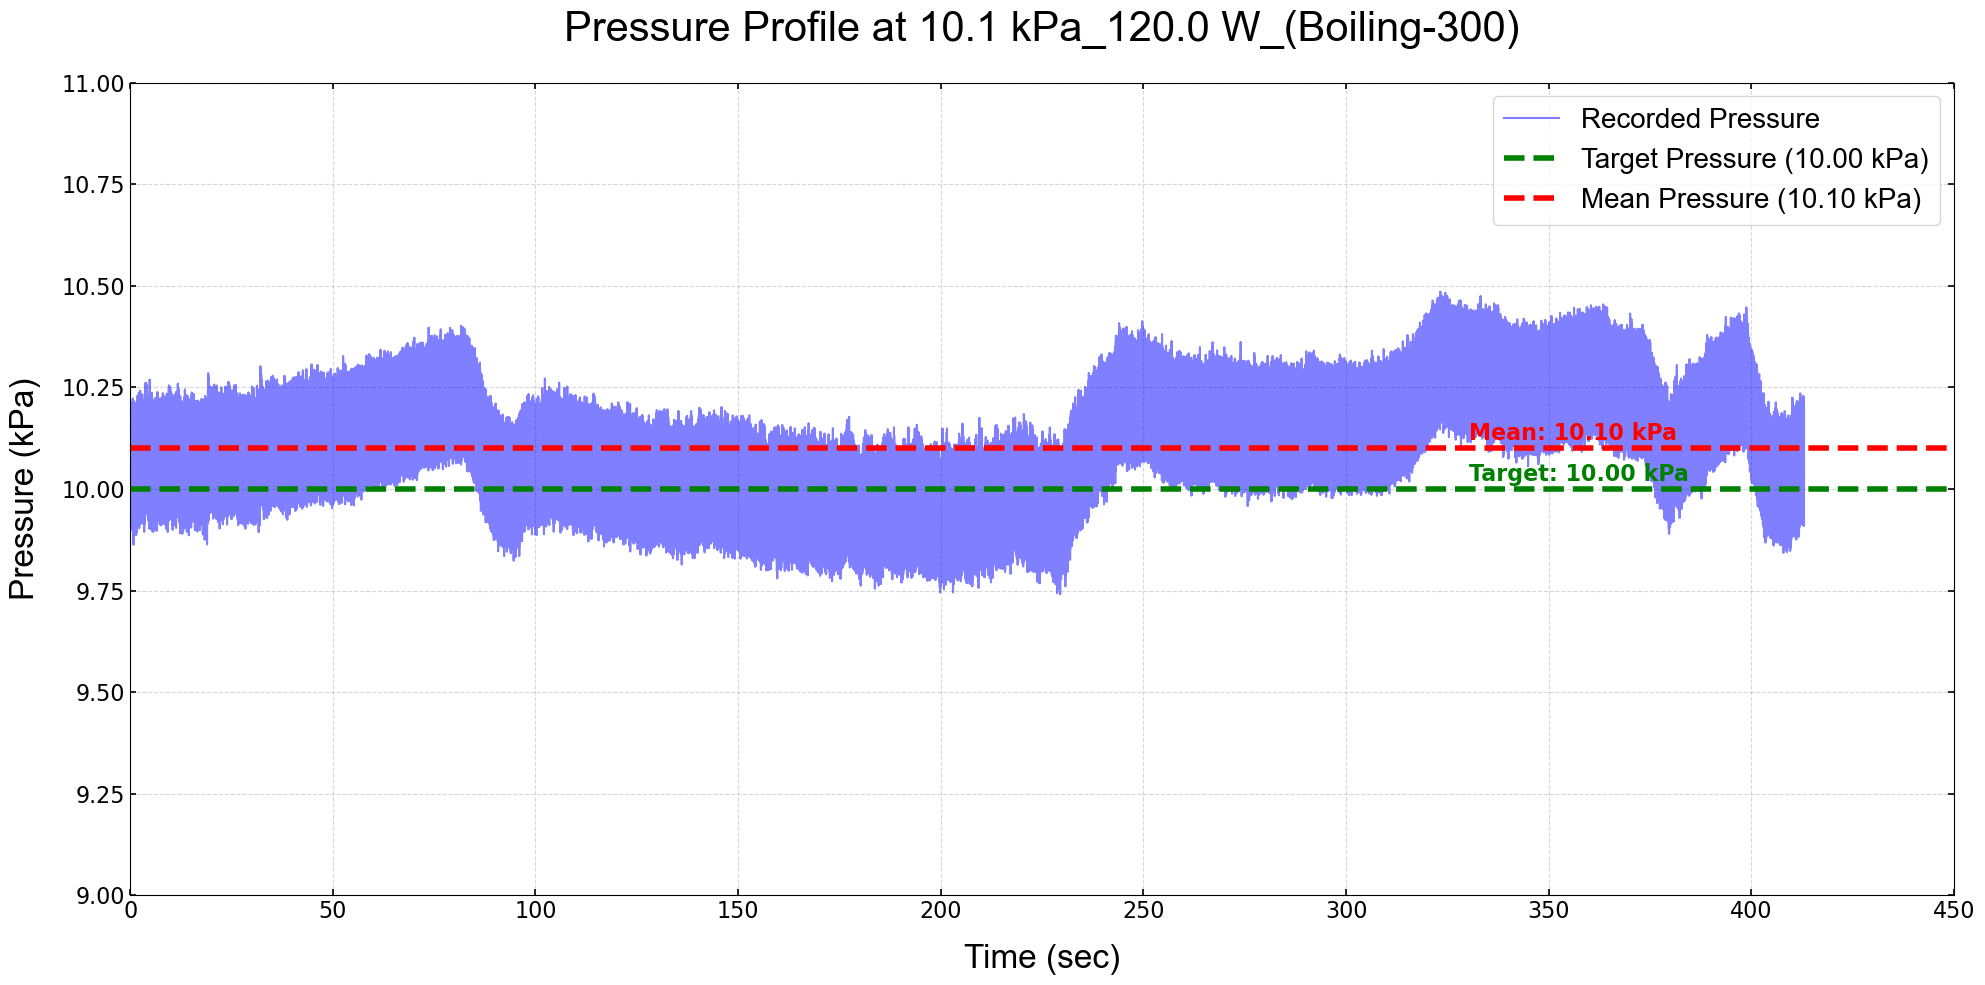

In [707]:
# --- First plot: Pressure vs Time ---
plt.figure(figsize=(20, 10))

# Recorded Pressure line
plt.plot(time_press, pressure, label='Recorded Pressure', color='blue',alpha = 0.5)

# Horizontal lines with labels for legend
plt.axhline(y=Target_pressure_kPa, color='green', linestyle='--', linewidth=4, label=f"Target Pressure ({Target_pressure_kPa:.2f} kPa)")
plt.axhline(y=pressure_mean_kPa, color='red', linestyle='--', linewidth=4, label=f"Mean Pressure ({pressure_mean_kPa:.2f} kPa)")

# Label position settings
x_pos_press = time_press.max() * 0.80  # 80% of max time
offset = (pressure.max() - pressure.min()) * 0.01  # 1% of range for spacing

# Place text ABOVE the dotted lines
plt.text(x_pos_press, Target_pressure_kPa + offset,
         f"Target: {Target_pressure_kPa:.2f} kPa",
         color='green', fontsize=16, va='bottom', ha='left', fontweight='bold')

plt.text(x_pos_press, pressure_mean_kPa + offset,
         f"Mean: {pressure_mean_kPa:.2f} kPa",
         color='red', fontsize=16, va='bottom', ha='left', fontweight='bold')

# X-axis from min to max time
plt.xlim(time_temp.min(), time_temp.max())
plt.ylim(pressure.min()-1, pressure.max()+1)

# Labels and Title
plt.xlabel('Time (sec)', fontsize=24,fontname='Arial', labelpad=15)
plt.ylabel('Pressure (kPa)', fontsize=24,fontname='Arial', labelpad=15)
plt.title(f"Pressure Profile at {pressure_mean_kPa} kPa_{applied_heat_load} W_(Boiling-{boiling_id})", fontsize=30, pad=30,fontname='Arial')

# Legend for all three
plt.legend(prop={'family':'Arial','size':20}, loc='upper right') 

plt.grid(True, linestyle='--', alpha=0.5)

ax = plt.gca()

tmin = float(np.nanmin(time_press))
tmax = float(np.nanmax(time_press))

## x-axis ticks ##
x_tick_start = x_step_time * np.floor(tmin / x_step_time)
x_tick_end   = x_step_time * np.ceil(tmax / x_step_time)
if x_tick_start >= tmin:
    x_tick_start -= 0
if x_tick_end <= tmax:
    x_tick_end += x_step_time

# set new axis limits and ticks
ax.set_xlim(x_tick_start, x_tick_end)
ax.set_xticks(np.arange(x_tick_start, x_tick_end + x_step_time, x_step_time))

# ---- Y-axis ticks based on mean pressure ----
# Use your existing mean value
m = float(pressure_mean_kPa)                 # e.g., 97.65
m_nearest = int(np.rint(m))                  # nearest integer → 98

y_bottom_pressure = m_nearest - 1                     # 2 below
y_top_pressure    = m_nearest +1                     # 2 above

ax.set_ylim(y_bottom_pressure, y_top_pressure)                 # 'ax' = the pressure plot axis
ax.set_yticks(np.arange(y_bottom_pressure, y_top_pressure+0.25, 0.25))  # integer ticks only

plt.xticks(fontsize=16)  # Increase x-axis tick size
plt.yticks(fontsize=16)  # Increase y-axis tick size

plt.tight_layout()

ax = plt.gca()


# Ticks pointing inward on all sides, thicker & a bit longer
ax.tick_params(axis='both', which='both',direction='in', top=True, right=True,width=1.2, length=4)

# Save figure (use a tuple)
saved_figures.append((f"9_Pressure Control_{pressure_mean_kPa}kPa_B-{boiling_id}", plt.gcf()))

plt.show()


##  Root Mean Square Error (RMSE)

Relative to a reference value (usually your target pressure):

$$
\text{RMSE} = \sqrt{ \frac{1}{N} \sum_{i=1}^N \left( P_i - P_{\text{target}} \right)^2 }
$$

- Measures the typical error between the actual signal and the target.  
- Includes both **bias** (offset from target) and **random fluctuations**.  

---

##  Standard Deviation ($\sigma$)

Relative to the mean of the data:

$$
\sigma = \sqrt{ \frac{1}{N-1} \sum_{i=1}^N \left( P_i - \overline{P} \right)^2 }
$$

where  

$$
\overline{P} = \frac{1}{N} \sum_{i=1}^N P_i
$$

- Measures how much the values spread around their mean.  


In [708]:

from scipy import stats

if 'Pressure' in dataframes:
    df_press = dataframes['Pressure']
    pressure = df_press['Pressure (kPa)'].values

    # --- Stats ---
    mean_val = np.mean(pressure)
    median_val = np.median(pressure)
    std_val = np.std(pressure, ddof=1)   # sample std
    var_val = np.var(pressure, ddof=1)   # sample variance
    min_val = np.min(pressure)
    max_val = np.max(pressure)
    range_val = max_val - min_val
    skew_val = stats.skew(pressure)
    kurt_val = stats.kurtosis(pressure)
    percentiles = np.percentile(pressure, [5, 25, 50, 75, 95])
    rms_val = np.sqrt(np.mean(pressure**2))

        # --- Bias & RMSE relative to target ---
    bias_val = mean_val - Target_pressure_kPa
    rmse_val = np.sqrt(np.mean((pressure - Target_pressure_kPa)**2))

    # --- Print results ---
    print("\n📊 Pressure Statistics:")
    print(f"Mean: {mean_val:.3f} kPa")
    print(f"Median: {median_val:.3f} kPa")
    print(f"Standard Deviation: {std_val:.3f}") 
    print(f"Variance: {var_val:.3f}")
    print(f"Min: {min_val:.3f} | Max: {max_val:.3f} | Range: {range_val:.3f}")
    print(f"Skewness: {skew_val:.3f}")
    print(f"Kurtosis: {kurt_val:.3f}")
    print(f"Percentiles (5,25,50,75,95): {percentiles}")
    print(f"RMS: {rms_val:.3f}")
    print(f"Bias (Mean - Target): {bias_val:.3f} kPa")
    print(f"RMSE vs Target: {rmse_val:.3f} kPa")


📊 Pressure Statistics:
Mean: 10.105 kPa
Median: 10.105 kPa
Standard Deviation: 0.119
Variance: 0.014
Min: 9.741 | Max: 10.486 | Range: 0.745
Skewness: 0.020
Kurtosis: -0.685
Percentiles (5,25,50,75,95): [ 9.908966 10.014086 10.104559 10.194979 10.301393]
RMS: 10.105
Bias (Mean - Target): 0.105 kPa
RMSE vs Target: 0.159 kPa


### Saturation Temperature

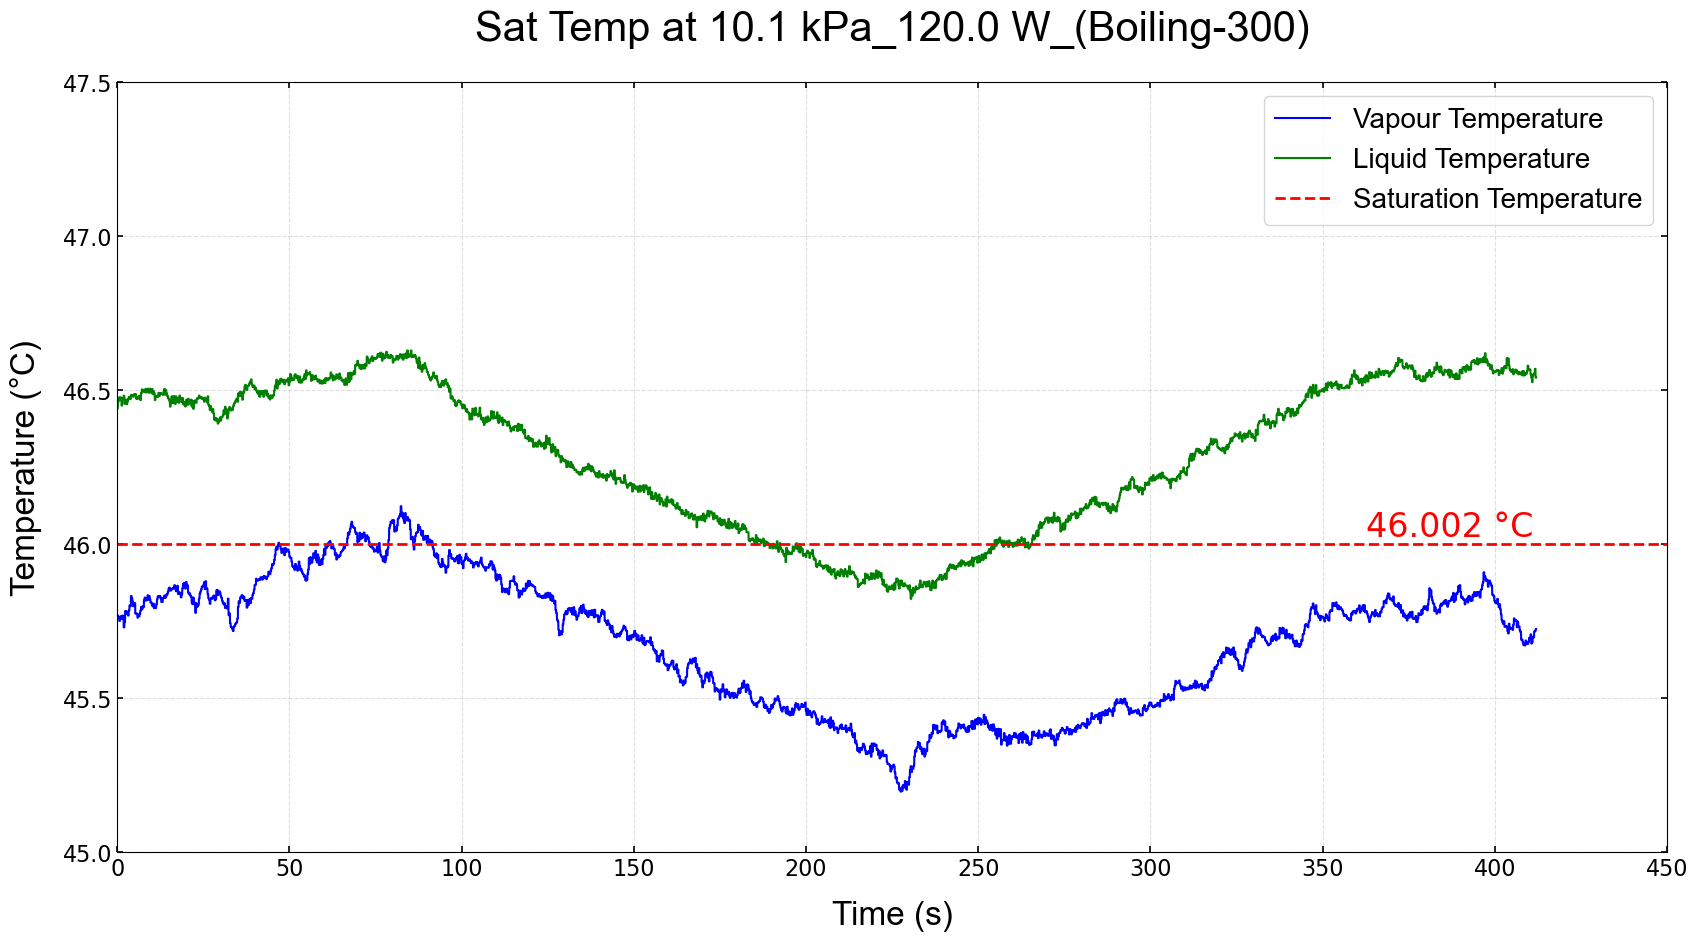

In [709]:
plt.figure(figsize=(20, 10))

# Plot vapor and liquid temperature vs. time
plt.plot(time_temp, T_vapour, color='blue', linewidth=1.5, label='Vapour Temperature')
plt.plot(time_temp, T_liquid, color='green', linewidth=1.5, label='Liquid Temperature')

# Draw a horizontal line at T_sat with a legend label showing the pressure
plt.axhline(
    y=T_sat,
    color='red',
    linestyle='--',  # Dotted/dashed line
    linewidth=2,
    label="Saturation Temperature"
)

# Set axis limits
plt.xlim(time_temp.min(), time_temp.max())  # X-axis from min to max time
# Find the overall min and max from Vap_T and Liq_T
Temp_fluid_min_value = np.min([T_vapour.min(), T_liquid.min()])
Temp_fluid_max_value = np.max([T_vapour.max(), T_liquid.max()])

plt.ylim(Temp_fluid_min_value-1, Temp_fluid_max_value+1)  # Y-axis range (adjust as needed)

# Axis labels, legend, and title
plt.xlabel("Time (s)", fontsize=24, labelpad=15, fontname='Arial')
plt.ylabel("Temperature (°C)", fontsize=24, labelpad=15, fontname='Arial')
plt.title(f"Sat Temp at {pressure_mean_kPa} kPa_{applied_heat_load} W_(Boiling-{boiling_id})", fontsize=30, pad=30, fontname='Arial')

ax = plt.gca()

## x-axis ticks ##
x_tick_start = x_step_time * np.floor(tmin / x_step_time)
x_tick_end   = x_step_time * np.ceil(tmax / x_step_time)
if x_tick_start >= tmin:
    x_tick_start -= 0
if x_tick_end <= tmax:
    x_tick_end += x_step_time

# set new axis limits and ticks
ax.set_xlim(x_tick_start, x_tick_end)
ax.set_xticks(np.arange(x_tick_start, x_tick_end + x_step_time, x_step_time))

## y-axis ticks ##
ymin_raw = float(Temp_fluid_min_value)
ymax_raw = float(Temp_fluid_max_value)

# multiples of 10 strictly before/after the data bounds
y_tick_start = 0.5 * np.floor(ymin_raw / 0.5)
y_tick_end   = 0.5 * np.ceil(ymax_raw / 0.5)
if y_tick_start >= ymin_raw:
    y_tick_start -= 0.5
if y_tick_end <= ymax_raw:
    y_tick_end += 0.5

# set new y-limits and ticks
ax.set_ylim(y_tick_start, y_tick_end)
ax.set_yticks(np.arange(y_tick_start, y_tick_end + 1, 0.5))

plt.legend(prop={'family':'Arial','size':20}, loc='upper right') 

# Place text on the plot to display the numeric T_sat value
# Adjust x-position/time for best placement; here we use 88% of the max time
x_pos = 0.88 * time_temp.max()
plt.text(x_pos, T_sat, f"{T_sat:.3f} °C", color='red', fontsize=24,
         ha='left', va='bottom')


plt.xticks(fontsize=16)  # Increase x-axis tick size
plt.yticks(fontsize=16)  # Increase y-axis tick size

plt.grid(True, linestyle='--', alpha=0.4)


ax = plt.gca()
# Ticks pointing inward on all sides, thicker & a bit longer
ax.tick_params(axis='both', which='both',direction='in', top=True, right=True,width=1.2, length=4)

# Save figure (use a tuple)
saved_figures.append((f"10_Sat Temp_{pressure_mean_kPa}kPa B-{boiling_id}", plt.gcf()))

plt.show()

# Boiling Curve Analysis

In [710]:
# Step 1: Find the cutoff index
cutoff_index = np.argmax(time_temp > chf_time)  # first index where time exceeds CHF time

# Step 2: Slice arrays up to cutoff
T_surface_cut = Surface_Temperature[:cutoff_index]
q_cut = q[:cutoff_index]
htc_cut = htc[:cutoff_index]
# Wall Superheat
delta_T = Surface_Temperature - T_sat
delta_T_cut = T_surface_cut - T_sat

#### Heat flux VS (Surface Temperature & Wall Superheat)

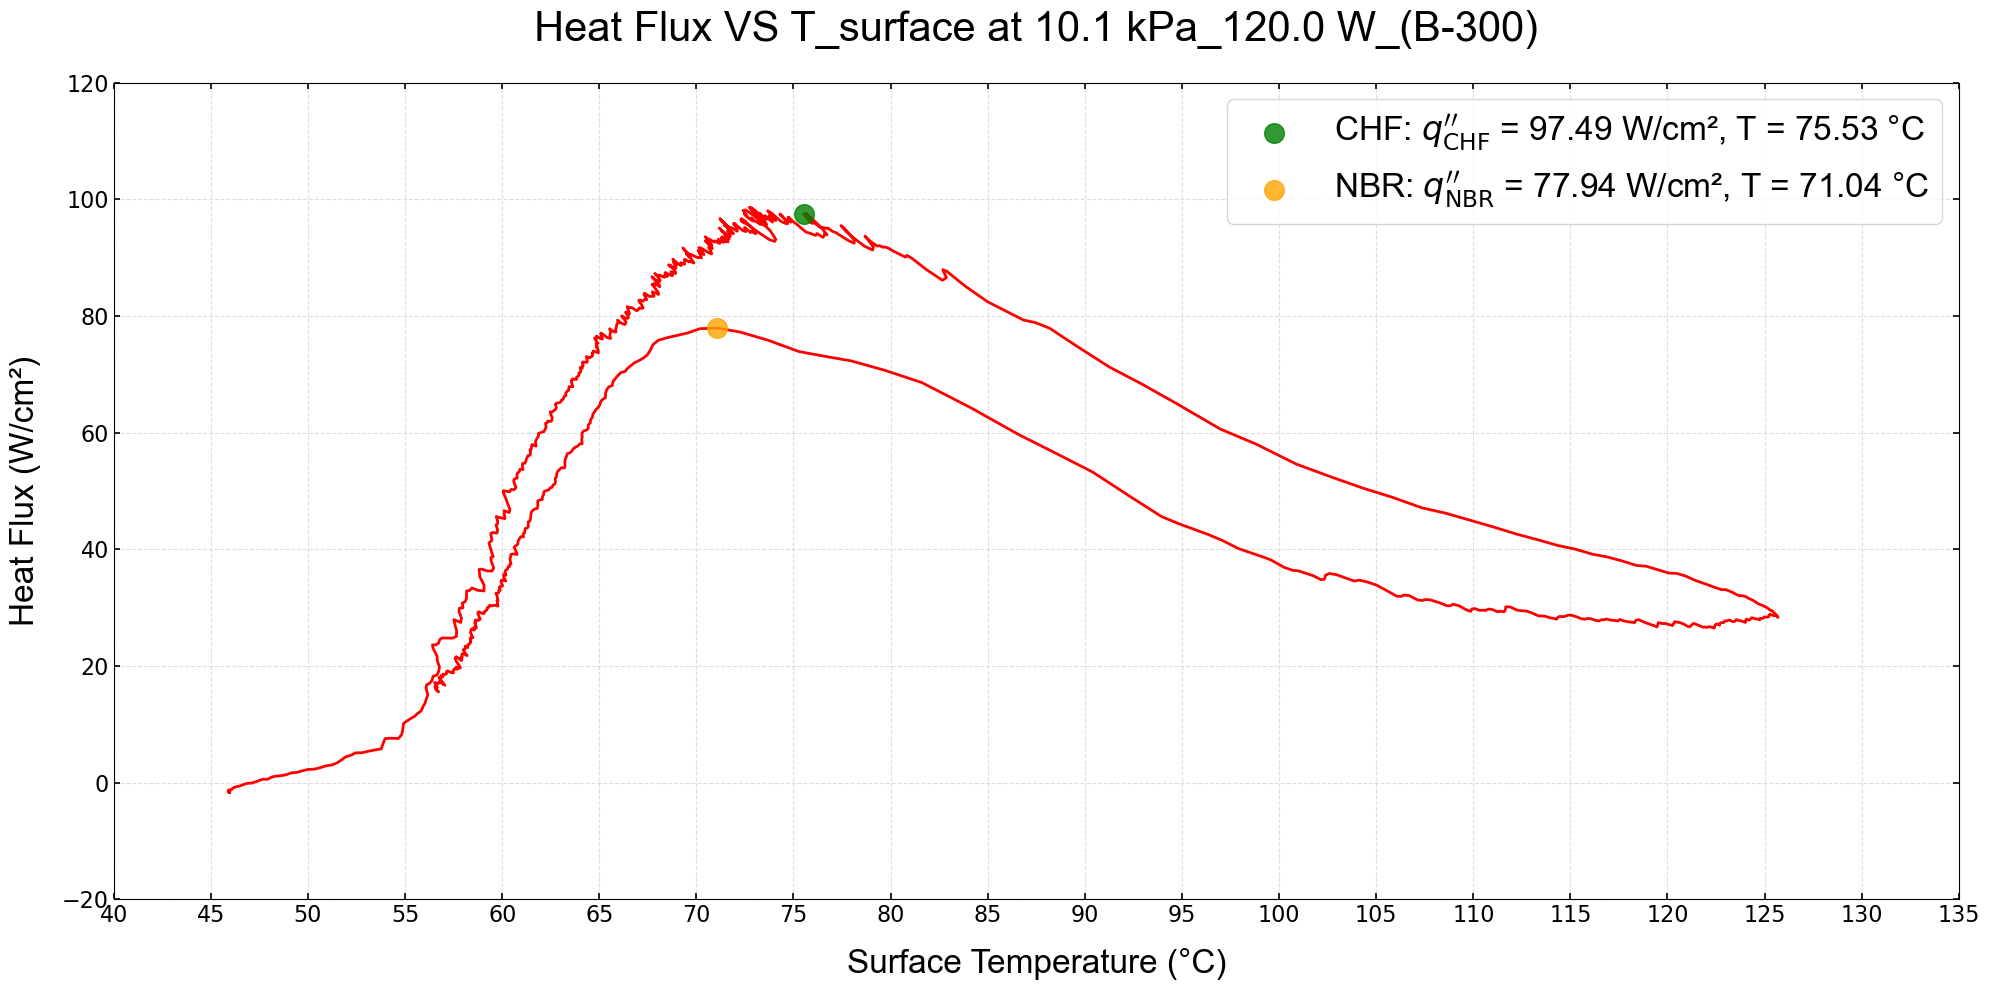

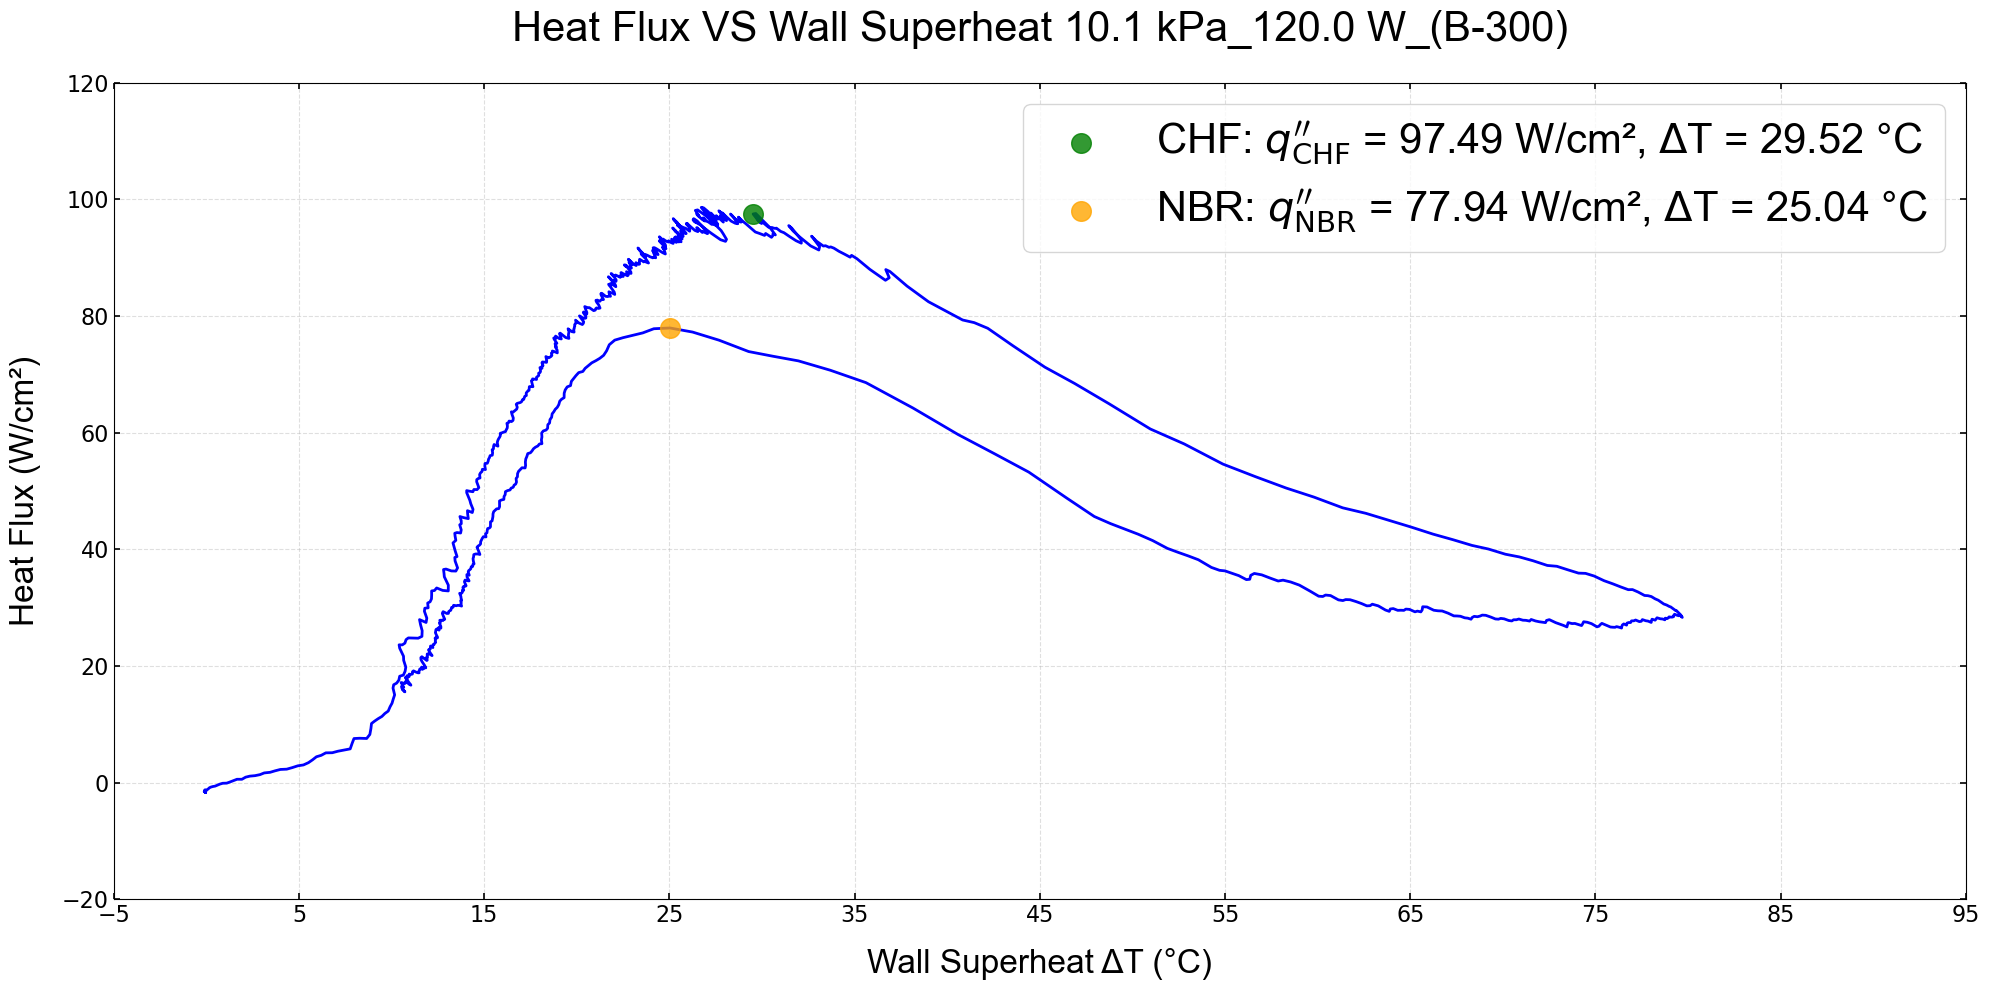

In [711]:
# ---------- Figure 1: Heat Flux vs Surface Temperature ----------
fig1, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(Surface_Temperature, q, color='red', linewidth=2)
ax1.set_xlabel("Surface Temperature (°C)", fontsize=24, fontname='Arial', labelpad=15)
ax1.set_ylabel("Heat Flux (W/cm²)", fontsize=24, fontname='Arial', labelpad=15)
ax1.set_title(f"Heat Flux VS T_surface at {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=30, pad=30, fontname='Arial')
ax1.grid(True, linestyle='--', alpha=0.4)

# index of time closest to CHF
idx_1 = int(np.nanargmin(np.abs(time_temp - chf_time)))
idx_2 = int(np.nanargmin(np.abs(time_temp - nbr_time)))

Tsurf_chf = float(Surface_Temperature[idx_1])   # x-value
q_chf = chf_value                     # y-value

Tsurf_nbr = float(Surface_Temperature[idx_2])   # x-value
q_nbr = nbr_value                    # y-value

# On your T_surf vs q plot:
plt.scatter(Tsurf_chf, q_chf, s=200, color='green', alpha=0.8, zorder=5,label = fr"CHF: $q_{{\mathrm{{CHF}}}}^{{\prime\prime}}$ = {q_chf:.2f} W/cm², T = {Tsurf_chf:.2f} °C")
plt.scatter(Tsurf_nbr, q_nbr, s=200, color='orange', alpha=0.8, zorder=5,label = fr"NBR: $q_{{\mathrm{{NBR}}}}^{{\prime\prime}}$ = {q_nbr:.2f} W/cm², T = {Tsurf_nbr:.2f} °C")

#### x-axis Ticks ####
x_tick_start = x_step_Surface_Temperature * np.floor(ymin_Surface_Temperature / x_step_Surface_Temperature)
x_tick_end   = x_step_Surface_Temperature * np.ceil(ymax_Surface_Temperature / x_step_Surface_Temperature)
if x_tick_start >= ymin_Surface_Temperature:
    x_tick_start -= ymin_Surface_Temperature
if x_tick_end <= ymax_Surface_Temperature:
    x_tick_end += ymax_Surface_Temperature

# set new axis limits and ticks
ax1.set_xlim(x_tick_start, x_tick_end)
ax1.set_xticks(np.arange(x_tick_start - 1* x_step_Surface_Temperature, x_tick_end + 2*x_step_Surface_Temperature, x_step_Surface_Temperature))

#### y-axis Ticks ####
y_tick_start = y_step_q * np.floor(ymin_q / y_step_q)
y_tick_end   = y_step_q * np.ceil(ymax_q / y_step_q)
if y_tick_start >= ymin_q:
    y_tick_start -= y_step_q
if y_tick_end <= ymax_q:
    y_tick_end += y_step_q

# set new y-limits and ticks
ax1.set_ylim(y_tick_start, y_tick_end)
ax1.set_yticks(np.arange(y_tick_start, y_tick_end +2*y_step_q, y_step_q))

# set new y-limits and ticks
#ax1.set_ylim(0, 200)
#ax1.set_yticks(np.arange(0, 210, y_step_q))

ax1 = plt.gca()

# Ticks pointing inward on all sides, thicker & a bit longer
ax1.tick_params(axis='both', which='both',direction='in', top=True, right=True,width=1.2, length=4)

plt.xticks(fontsize=16)  # Increase x-axis tick size
plt.yticks(fontsize=16)  # Increase y-axis tick size

plt.legend(prop={'family':'Arial','size':24}, loc='upper right')

plt.tight_layout()
saved_figures.append((f"11_Heat Flux_vs_Surface Temperature_{pressure_mean_kPa}kPa_{applied_heat_load} W_B-{boiling_id}", fig1))
plt.show()






# ---------- Figure 2: Heat Flux vs Wall Superheat ----------
fig2, ax2 = plt.subplots(figsize=(20, 10))
ax2.plot(delta_T, q, color='blue', linewidth=2)
ax2.set_xlabel("Wall Superheat ΔT (°C)", fontsize=24, fontname='Arial', labelpad=15)
ax2.set_ylabel("Heat Flux (W/cm²)", fontsize=24, fontname='Arial', labelpad=15)
ax2.set_title(f"Heat Flux VS Wall Superheat {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=30, pad=30, fontname='Arial')
ax2.grid(True, linestyle='--', alpha=0.4)



# index of time closest to CHF
idx_1 = int(np.nanargmin(np.abs(time_temp - chf_time)))
idx_2 = int(np.nanargmin(np.abs(time_temp - nbr_time)))

Twall_chf = float(delta_T[idx_1])   # x-value
q_chf = chf_value                     # y-value

Twall_nbr = float(delta_T[idx_2])   # x-value
q_nbr = nbr_value                    # y-value

# On your T_surf vs q plot:
plt.scatter(Twall_chf, q_chf, s=200, color='green', alpha=0.8, zorder=5,label = fr"CHF: $q_{{\mathrm{{CHF}}}}^{{\prime\prime}}$ = {q_chf:.2f} W/cm², $\Delta$T = {Twall_chf:.2f} °C")
plt.scatter(Twall_nbr, q_nbr, s=200, color='orange', alpha=0.8, zorder=5,label = fr"NBR: $q_{{\mathrm{{NBR}}}}^{{\prime\prime}}$ = {q_nbr:.2f} W/cm², $\Delta$T = {Twall_nbr:.2f} °C")


#### x-axis Ticks ####
x_tick_start = x_step_Wall_Superheat * np.floor(ymin_Wall_Superheat / x_step_Wall_Superheat)
x_tick_end   = x_step_Wall_Superheat * np.ceil(ymax_Wall_Superheat / x_step_Wall_Superheat)
if x_tick_start >= ymin_Wall_Superheat:
    x_tick_start -= ymin_Wall_Superheat
if x_tick_end <= ymax_Wall_Superheat:
    x_tick_end += ymax_Wall_Superheat

# set new axis limits and ticks
#ax2.set_xlim(x_tick_start, x_tick_end)
#ax2.set_xticks(np.arange(x_tick_start - 1*x_step_Wall_Superheat, x_tick_end + 2*x_step_Wall_Superheat, x_step_Wall_Superheat))

# set new axis limits and ticks
ax2.set_xlim(-5, x_tick_end)
ax2.set_xticks(np.arange(-5, x_tick_end + 2*x_step_Wall_Superheat, x_step_Wall_Superheat))

#### y-axis Ticks ####
y_tick_start = y_step_q * np.floor(ymin_q / y_step_q)
y_tick_end   = y_step_q * np.ceil(ymax_q / y_step_q)
if y_tick_start >= ymin_q:
    y_tick_start -= y_step_q
if y_tick_end <= ymax_q:
    y_tick_end += y_step_q

# set new y-limits and ticks
ax2.set_ylim(y_tick_start, y_tick_end)
ax2.set_yticks(np.arange(y_tick_start, y_tick_end +2*y_step_q, y_step_q))

# set new y-limits and ticks
#ax2.set_ylim(0, 90)
#ax2.set_yticks(np.arange(0, 100, y_step_q))

ax2 = plt.gca()

# Ticks pointing inward on all sides, thicker & a bit longer
ax2.tick_params(axis='both', which='both',direction='in', top=True, right=True,width=1.2, length=4)

plt.xticks(fontsize=16)  # Increase x-axis tick size
plt.yticks(fontsize=16)  # Increase y-axis tick size

plt.legend(prop={'family':'Arial','size':30}, loc='upper right')

plt.tight_layout()
saved_figures.append((f"12_Heat Flux_vs_Wall Superheat_{pressure_mean_kPa}kPa_B-{boiling_id}", fig2))
plt.show()


In [712]:
raise exception

NameError: name 'exception' is not defined

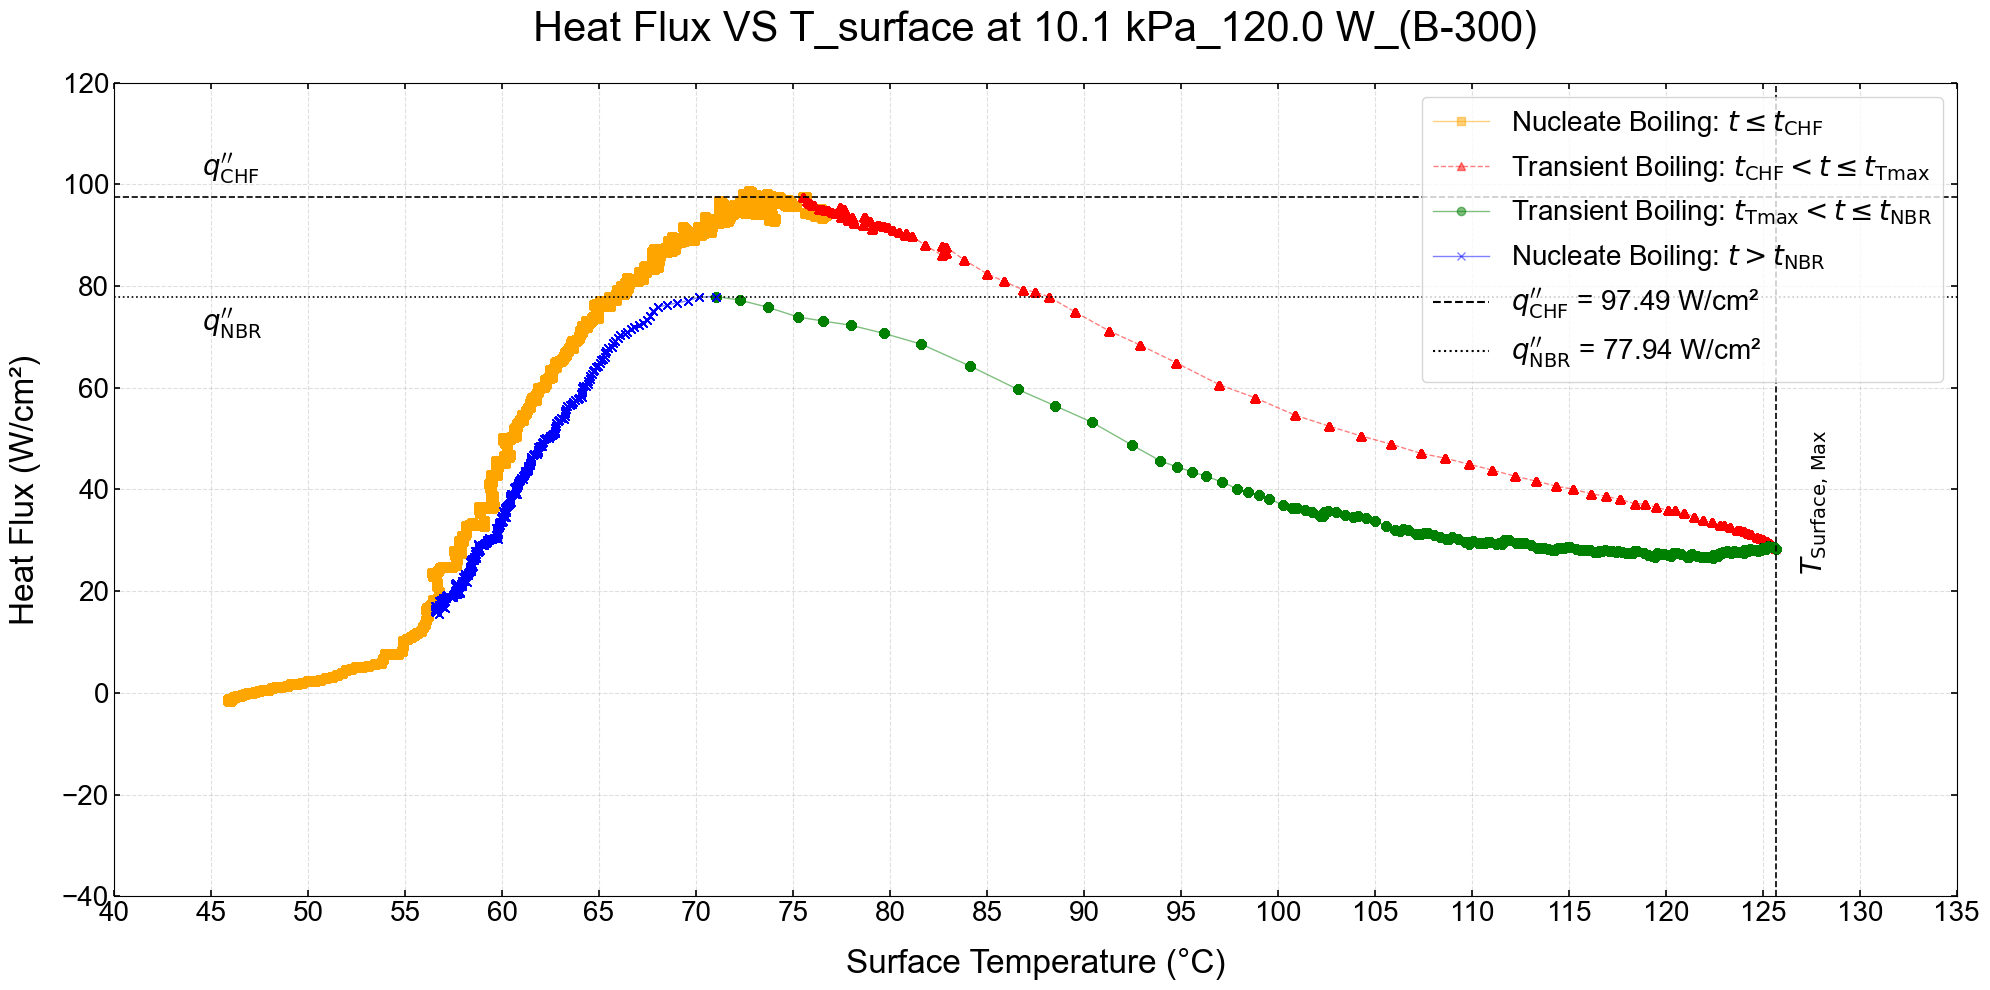

Max Surface Temperature = 125.69 °C at 267.39 s
CHF -> t=231.84s, q=97.49 W/cm², idx=695551
NBR -> t=324.99s, q=77.94 W/cm², idx=974999


In [713]:
# ---------- Key values using YOUR variable names ----------
idx = int(np.nanargmin(np.abs(time_temp - chf_time)))   # closest to CHF (you already had this)
T_chf = float(Surface_Temperature[idx])                  # Ts at CHF (x)
q_chf = float(chf_value)                                 # q at CHF (use your chf_value)
q_nbr = float(nbr_value)                                 # q at NBR (use your nbr_value)

max_Surface_Temperature = float(np.nanmax(Surface_Temperature))
time_at_max_Surface_Temperature = float(time_temp[np.nanargmax(Surface_Temperature)])

# Time instants (your names)
t_chf  = float(chf_time)
t_tmax = float(time_at_max_Surface_Temperature)
t_nbr  = float(nbr_time)

# Masks for the four regimes (NB/TB) based on your time variables
m_nb1 = (time_temp <= t_chf)                              # NB: t ≤ t_CHF
m_tb1 = (time_temp > t_chf) & (time_temp <= t_tmax)       # TB: t_CHF < t ≤ t_tmax
m_tb2 = (time_temp > t_tmax) & (time_temp <= t_nbr)       # TB: t_tmax < t ≤ t_nbr
m_nb2 = (time_temp > t_nbr)                               # NB: t > t_nbr

# ---------- Figure 1: Heat Flux vs Surface Temperature ----------
fig1, ax1 = plt.subplots(figsize=(20, 10))

# Plot each regime with markers like the example
if np.any(m_nb1):
    ax1.plot(Surface_Temperature[m_nb1], q[m_nb1],
             linestyle='-', marker='s', markersize=6, linewidth=1, alpha = 0.5,
             color='orange', label = r'Nucleate Boiling: $t \leq t_{\mathrm{CHF}}$')

if np.any(m_tb1):
    ax1.plot(Surface_Temperature[m_tb1], q[m_tb1],
             linestyle='--', marker='^', markersize=6, linewidth=1, alpha = 0.5,
             color='red', label = r'Transient Boiling: $t_{\mathrm{CHF}} < t \leq t_{\mathrm{Tmax}}$')

if np.any(m_tb2):
    ax1.plot(Surface_Temperature[m_tb2], q[m_tb2],
             linestyle='-', marker='o', markersize=6, linewidth=1, alpha = 0.5,
             color='green', label = r'Transient Boiling: $t_{\mathrm{Tmax}} < t \leq t_{\mathrm{NBR}}$')

if np.any(m_nb2):
    ax1.plot(Surface_Temperature[m_nb2], q[m_nb2],
             linestyle='-', marker='x', markersize=6, linewidth=1, alpha = 0.5,
             color='blue', label = r'Nucleate Boiling: $t > t_{\mathrm{NBR}}$')

# Labels, title, grid
ax1.set_xlabel("Surface Temperature (°C)", fontsize=24, fontname='Arial', labelpad=15)
ax1.set_ylabel("Heat Flux (W/cm²)", fontsize=24, fontname='Arial', labelpad=15)
ax1.set_title(f"Heat Flux VS T_surface at {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})",fontsize=30, pad=30, fontname='Arial')
ax1.grid(True, linestyle='--', alpha=0.4)

# Put labels at 3% from the left; change 0.03 → 0.98 for right edge, etc.
xmin, xmax = ax1.get_xlim()
xpos = lambda frac: xmin + frac * (xmax - xmin)

# CHF line label (italic q, superscript '', upright CHF subscript)
ax1.text(xpos(0.03), q_chf + 2, r"$q^{\prime\prime}_{\mathrm{CHF}}$",fontsize=20, ha='left', va='bottom')

# NBR line label
ax1.text(xpos(0.03), q_nbr - 2, r"$q^{\prime\prime}_{\mathrm{NBR}}$",fontsize=20, ha='left', va='top')

# Horizontal dashed lines at q''_CHF and q''_nbr (using your chf_value / nbr_value)
ax1.axhline(q_chf, linestyle='--', linewidth=1.2, color='black')
ax1.axhline(q_nbr, linestyle=':', linewidth=1.2, color='black')
'''
# Labels for those lines
xmin_current, xmax_current = ax1.get_xlim()
ax1.text(xmin_current, q_chf + 2, "q''_CHF", fontsize=16, va='bottom')
ax1.text(xmin_current, q_nbr + 2, "q''_nbr", fontsize=16, va='bottom')
'''
# Mark CHF point
#ax1.scatter(T_chf, q_chf, s=100, color='green', alpha=0.6, zorder=5,label=f"CHF: q={chf_value:.2f} W/cm², T={T_chf:.2f} °C")

# Vertical dashed line at T_s,max (using your max_Surface_Temperature)
# Dotted vertical line (as you had)
ax1.axvline(max_Surface_Temperature, linestyle='--', linewidth=1.2, color='black')

# --- Control the vertical position here (0 = bottom, 1 = top) ---
ymin_current, ymax_current = ax1.get_ylim()
y_frac = 0.40                      # try 0.95 (near top), 0.50 (middle), etc.
y_pos = ymin_current + y_frac * (ymax_current - ymin_current)

# Optional tiny horizontal nudge off the line (data units); set to 0 to sit on the line
x_shift = 2

# Label: T with upright subscript "Surface, Max"
ax1.text(max_Surface_Temperature + x_shift, y_pos,r"$T_{\mathrm{Surface,\,Max}}$",fontsize=20, rotation=90, ha='center', va='center')

#### x-axis Ticks ####
x_tick_start = x_step_Surface_Temperature * np.floor(ymin_Surface_Temperature / x_step_Surface_Temperature)
x_tick_end   = x_step_Surface_Temperature * np.ceil(ymax_Surface_Temperature / x_step_Surface_Temperature)
if x_tick_start >= ymin_Surface_Temperature:
    x_tick_start -= ymin_Surface_Temperature
if x_tick_end <= ymax_Surface_Temperature:
    x_tick_end += ymax_Surface_Temperature

# set new axis limits and ticks
ax1.set_xlim(x_tick_start, x_tick_end)
ax1.set_xticks(np.arange(x_tick_start - 1*x_step_Surface_Temperature, x_tick_end + 2*x_step_Surface_Temperature, x_step_Surface_Temperature))


#### y-axis Ticks ####
y_tick_start = y_step_q * np.floor(ymin_q / y_step_q)
y_tick_end   = y_step_q * np.ceil(ymax_q / y_step_q)
if y_tick_start >= ymin_q:
    y_tick_start -= y_step_q
if y_tick_end <= ymax_q:
    y_tick_end += y_step_q

# set new y-limits and ticks
ax1.set_ylim(y_tick_start, y_tick_end)
ax1.set_yticks(np.arange(y_tick_start-y_step_q, y_tick_end +2*y_step_q, y_step_q))

# Ticks pointing inward on all sides
ax1.tick_params(axis='both', which='both', direction='in', top=True, right=True, width=1.2, length=4)
plt.xticks(fontsize=20,fontname='Arial')
plt.yticks(fontsize=20,fontname='Arial')

ax1.plot([], [], linestyle='--', color='black',label=r"$q^{\prime\prime}_{\mathrm{CHF}}$ = " + f"{q_chf:.2f} W/cm²")
ax1.plot([], [], linestyle=':', color='black',label=r"$q^{\prime\prime}_{\mathrm{NBR}}$ = " + f"{q_nbr:.2f} W/cm²")

                      
# Legend
plt.legend(prop={'family':'Arial','size':20}, loc='upper right')

plt.tight_layout()
saved_figures.append((f"13_Heat Flux_vs_Surface Temperature_{pressure_mean_kPa}kPa_{applied_heat_load} W_B-{boiling_id}", fig1))
plt.show()

# ---- Corrected prints using your variable names ----
print(f"Max Surface Temperature = {max_Surface_Temperature:.2f} °C at {time_at_max_Surface_Temperature:.2f} s")
print(f"CHF -> t={chf_time:.2f}s, q={chf_value:.2f} W/cm², idx={chf_idx}")
print(f"NBR -> t={nbr_time:.2f}s, q={nbr_value:.2f} W/cm², idx={nbr_idx}")


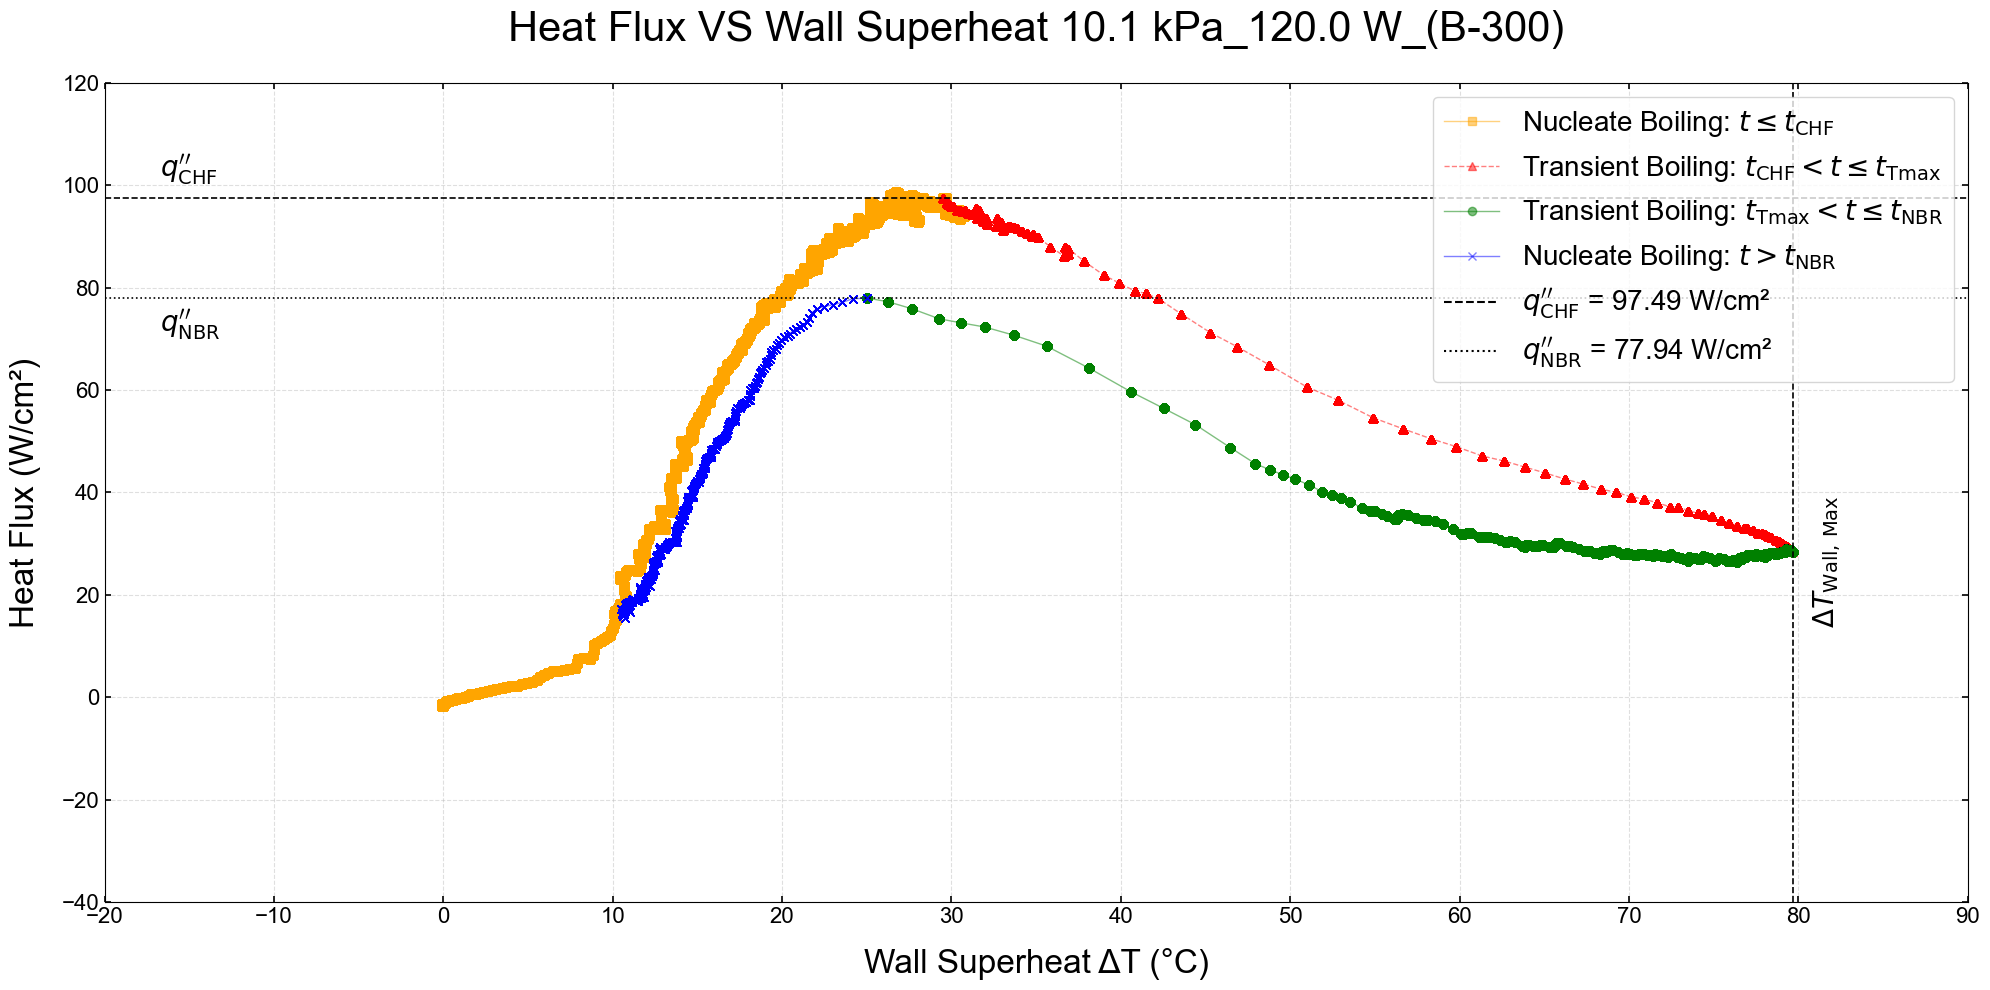

In [714]:
# ---------- Figure 2: Heat Flux vs Wall Superheat ----------
fig2, ax2 = plt.subplots(figsize=(20, 10))

# Reuse time-based masks (same logic as Fig 1)
m_nb1 = (time_temp <= chf_time)                                  # NB: t ≤ t_CHF
m_tb1 = (time_temp > chf_time) & (time_temp <= time_at_max_Surface_Temperature)   # TB: t_CHF < t ≤ t_Tmax
m_tb2 = (time_temp > time_at_max_Surface_Temperature) & (time_temp <= nbr_time)   # TB: t_Tmax < t ≤ t_NBR
m_nb2 = (time_temp > nbr_time)                                   # NB: t > t_NBR

# Plot each regime with the same markers/colors/alpha as Fig 1
if np.any(m_nb1):
    ax2.plot(delta_T[m_nb1], q[m_nb1],
             linestyle='-', marker='s', markersize=6, linewidth=1, alpha=0.5,
             color='orange', label=r'Nucleate Boiling: $t \leq t_{\mathrm{CHF}}$')

if np.any(m_tb1):
    ax2.plot(delta_T[m_tb1], q[m_tb1],
             linestyle='--', marker='^', markersize=6, linewidth=1, alpha=0.5,
             color='red', label=r'Transient Boiling: $t_{\mathrm{CHF}} < t \leq t_{\mathrm{Tmax}}$')

if np.any(m_tb2):
    ax2.plot(delta_T[m_tb2], q[m_tb2],
             linestyle='-', marker='o', markersize=6, linewidth=1, alpha=0.5,
             color='green', label=r'Transient Boiling: $t_{\mathrm{Tmax}} < t \leq t_{\mathrm{NBR}}$')

if np.any(m_nb2):
    ax2.plot(delta_T[m_nb2], q[m_nb2],
             linestyle='-', marker='x', markersize=6, linewidth=1, alpha=0.5,
             color='blue', label=r'Nucleate Boiling: $t > t_{\mathrm{NBR}}$')

# Labels, title, grid
ax2.set_xlabel("Wall Superheat ΔT (°C)", fontsize=24, fontname='Arial', labelpad=15)
ax2.set_ylabel("Heat Flux (W/cm²)", fontsize=24, fontname='Arial', labelpad=15)
ax2.set_title(
    f"Heat Flux VS Wall Superheat {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})",
    fontsize=30, pad=30, fontname='Arial'
)
ax2.grid(True, linestyle='--', alpha=0.4)

# --- Horizontal dashed lines at q''_CHF and q''_NBR (same as Fig 1) ---
q_chf = float(chf_value)
q_nbr = float(nbr_value)
ax2.axhline(q_chf, linestyle='--', linewidth=1.2, color='black')
ax2.axhline(q_nbr, linestyle=':', linewidth=1.2, color='black')


#### x-axis Ticks ####
x_tick_start = x_step_Wall_Superheat * np.floor(ymin_Wall_Superheat / x_step_Wall_Superheat)
x_tick_end   = x_step_Wall_Superheat * np.ceil(ymax_Wall_Superheat / x_step_Wall_Superheat)
if x_tick_start >= ymin_Wall_Superheat:
    x_tick_start -= ymin_Wall_Superheat
if x_tick_end <= ymax_Wall_Superheat:
    x_tick_end += ymax_Wall_Superheat

# set new axis limits and ticks
ax2.set_xlim(x_tick_start, x_tick_end)
ax2.set_xticks(np.arange(x_tick_start - 1*x_step_Wall_Superheat, x_tick_end + 2*x_step_Wall_Superheat, x_step_Wall_Superheat))

# Place the q'' labels at a fraction across the x-axis (simple control)
xmin_lbl, xmax_lbl = ax2.get_xlim()
xpos2 = lambda frac: xmin_lbl + frac * (xmax_lbl - xmin_lbl)
ax2.text(xpos2(0.03), q_chf + 2, r"$q^{\prime\prime}_{\mathrm{CHF}}$", fontsize=20, ha='left', va='bottom')
ax2.text(xpos2(0.03), q_nbr - 2, r"$q^{\prime\prime}_{\mathrm{NBR}}$", fontsize=20, ha='left', va='top')

# --- Vertical dashed line at max_Wall_Superheat (instead of T_surface,max) ---
max_Wall_Superheat = float(max_Surface_Temperature - T_sat)   # keep this variable name
ax2.axvline(max_Wall_Superheat, linestyle='--', linewidth=1.2, color='black')

# Control vertical label position along the line (0 = bottom, 1 = top)
ymin2, ymax2 = ax2.get_ylim()
y_frac2 = 0.30
y_pos2 = ymin2 + y_frac2 * (ymax2 - ymin2)

# Optional small horizontal nudge from the line (data units)
x_shift2 = 2
ax2.text(max_Wall_Superheat + x_shift2, y_pos2,r"$\Delta T_{\mathrm{Wall,\,Max}}$",fontsize=20, rotation=90, ha='center', va='center')

#### y-axis Ticks ####
y_tick_start = y_step_q * np.floor(ymin_q / y_step_q)
y_tick_end   = y_step_q * np.ceil(ymax_q / y_step_q)
if y_tick_start >= ymin_q:
    y_tick_start -= y_step_q
if y_tick_end <= ymax_q:
    y_tick_end += y_step_q

# set new y-limits and ticks
ax2.set_ylim(y_tick_start, y_tick_end)
ax2.set_yticks(np.arange(y_tick_start-y_step_q, y_tick_end +2*y_step_q, y_step_q))

# Ticks pointing inward on all sides
ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True, width=1.2, length=4)
plt.xticks(fontsize=16, fontname='Arial')
plt.yticks(fontsize=16, fontname='Arial')


ax2.plot([], [], linestyle='--', color='black',label=r"$q^{\prime\prime}_{\mathrm{CHF}}$ = " + f"{q_chf:.2f} W/cm²")
ax2.plot([], [], linestyle=':', color='black',label=r"$q^{\prime\prime}_{\mathrm{NBR}}$ = " + f"{q_nbr:.2f} W/cm²")

# Legend
plt.legend(prop={'family':'Arial','size':20}, loc='upper right')

plt.tight_layout()
saved_figures.append((f"14_Heat Flux_vs_Wall Superheat_{pressure_mean_kPa}kPa_{applied_heat_load} W_B-{boiling_id}", fig2))
plt.show()


#### Heat flux VS (Surface Temperature & Wall Superheat) up to CHF

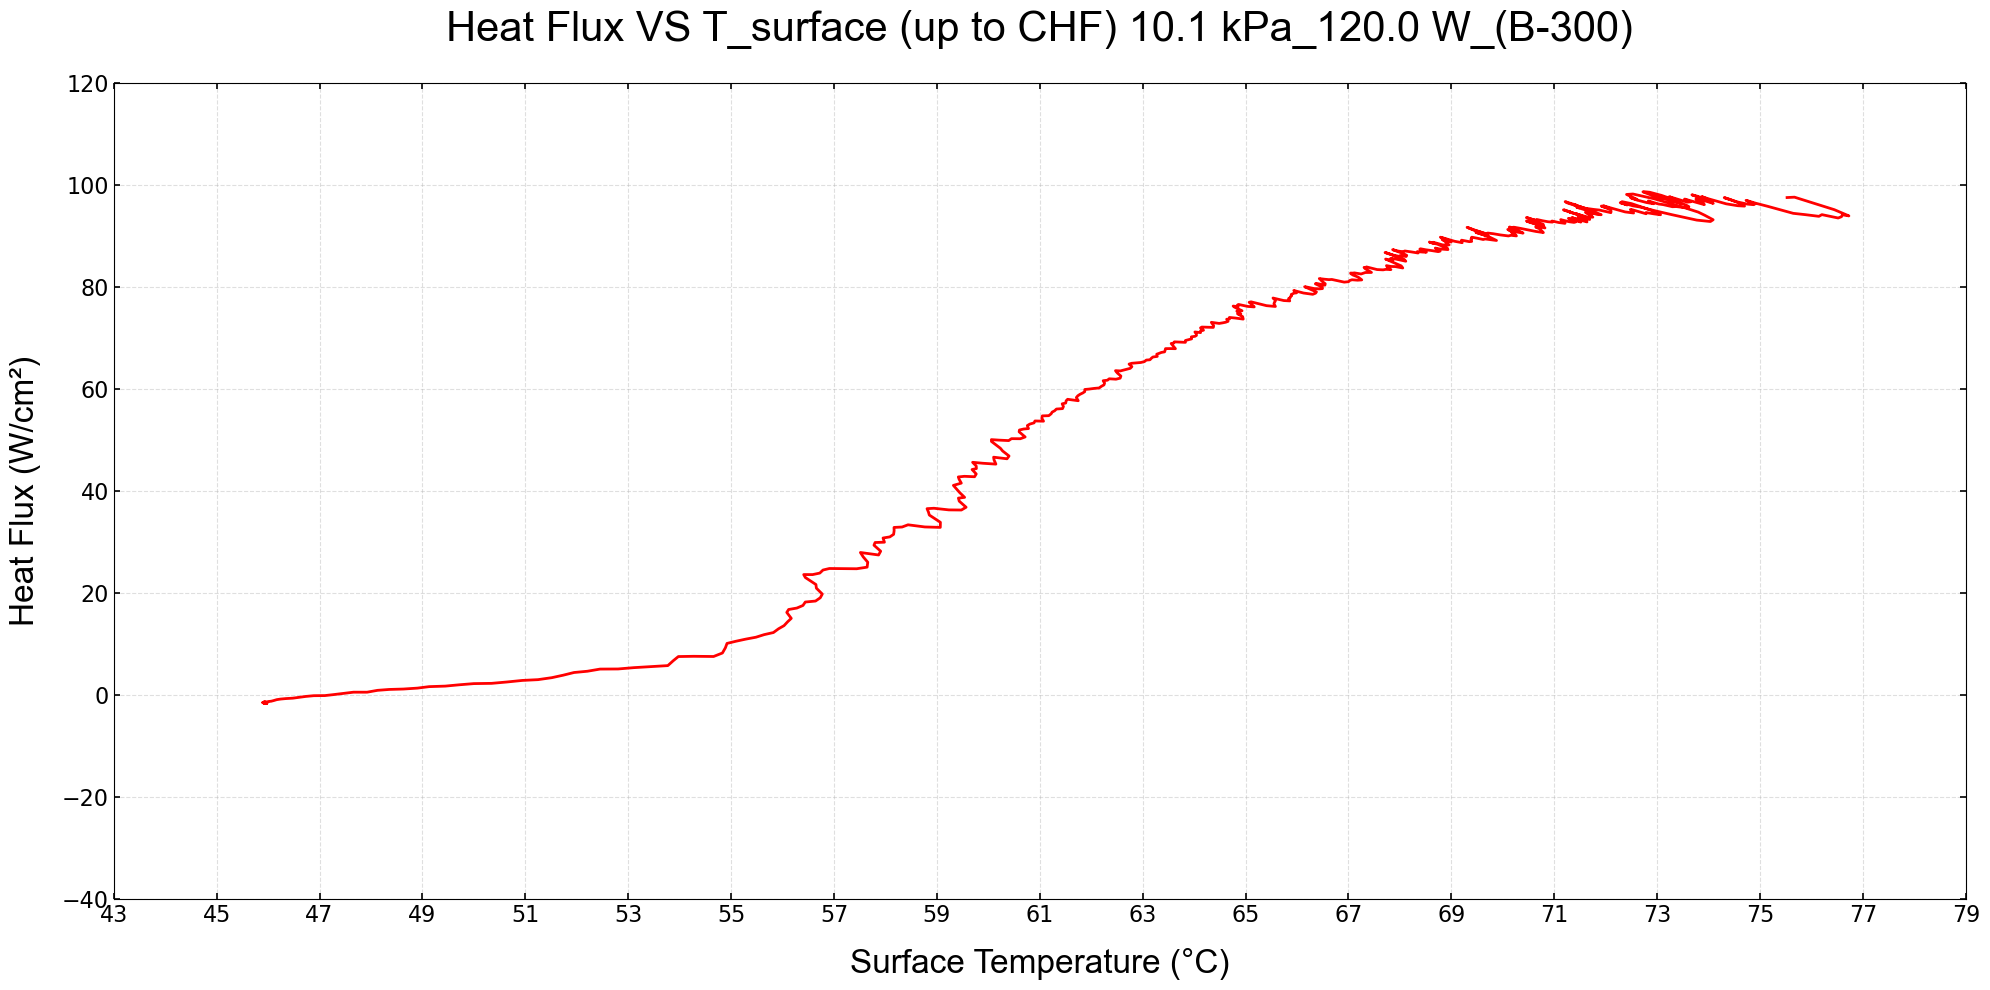

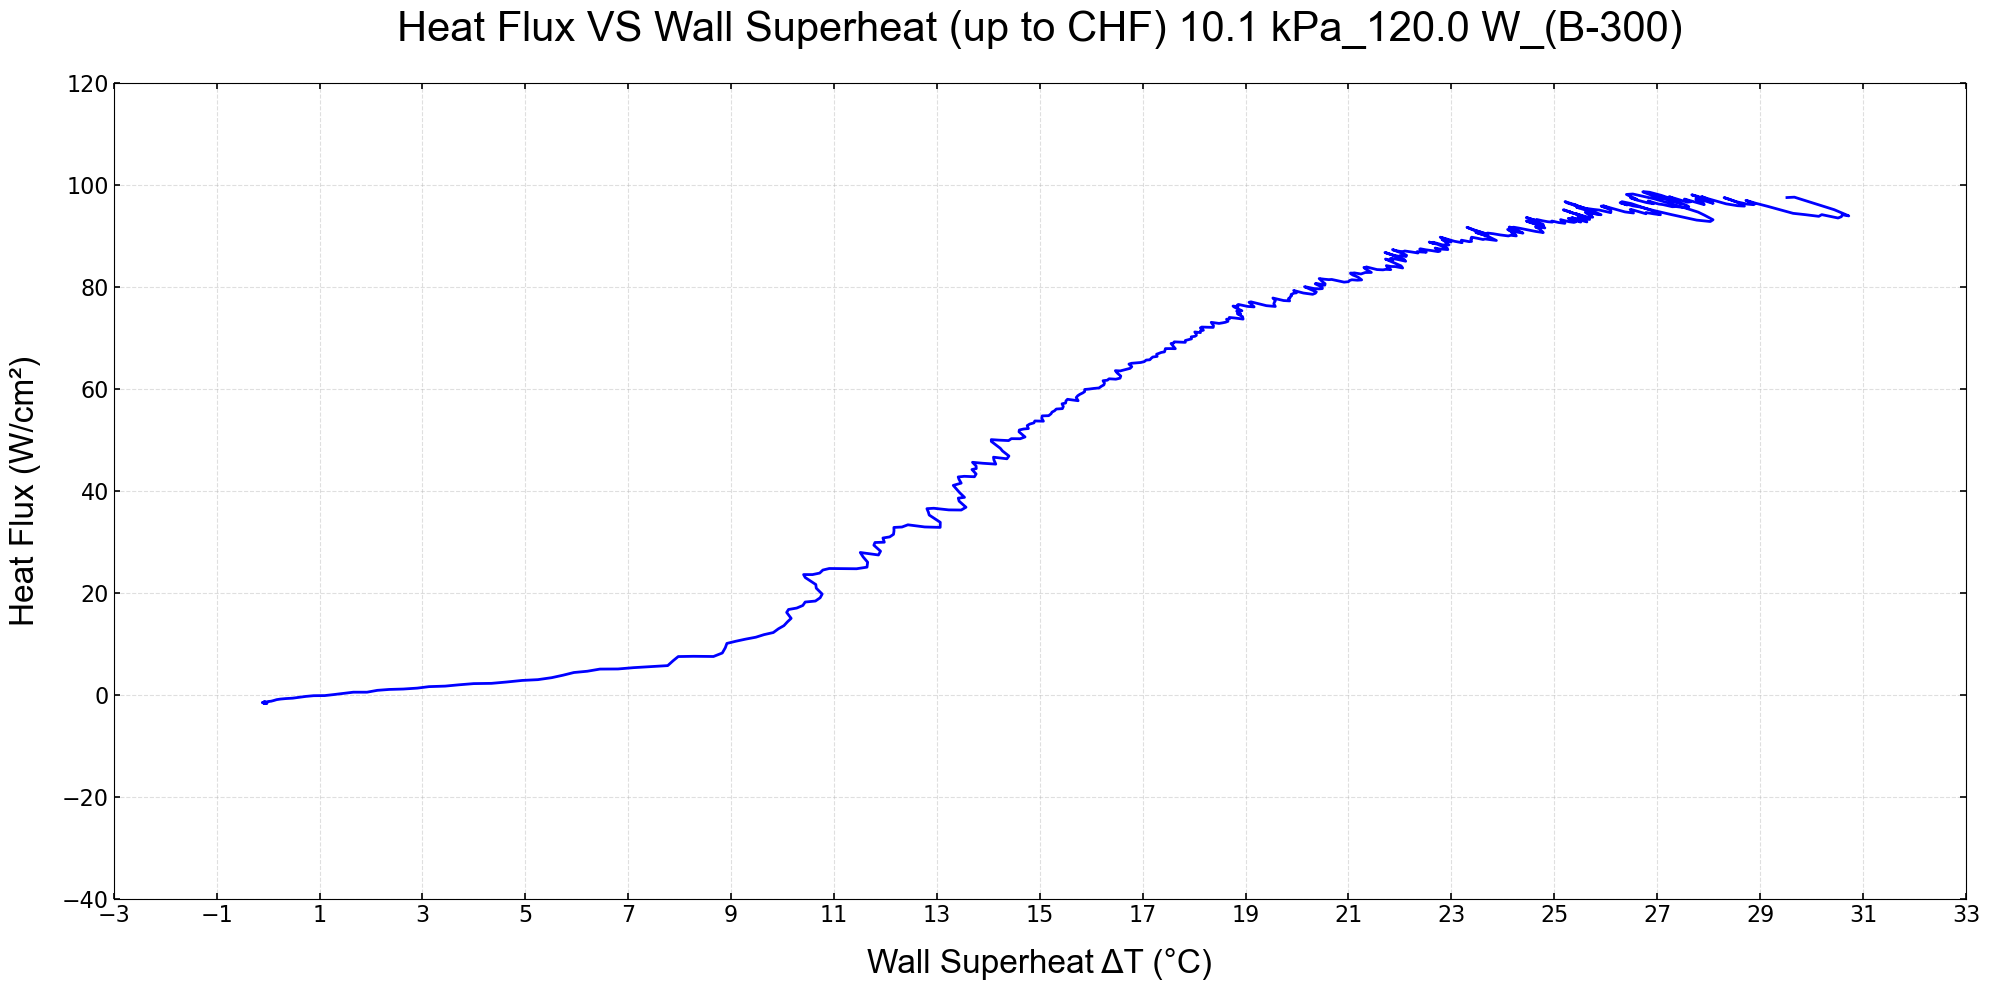

In [715]:
# ---------- Figure 1: Heat Flux vs Surface Temperature ----------
fig1, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(T_surface_cut, q_cut, color='red', linewidth=2)
ax1.set_xlabel("Surface Temperature (°C)", fontsize=24, fontname='Arial', labelpad=15)
ax1.set_ylabel("Heat Flux (W/cm²)", fontsize=24, fontname='Arial', labelpad=15)
ax1.set_title(f"Heat Flux VS T_surface (up to CHF) {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=30, pad=30, fontname='Arial')
ax1.grid(True, linestyle='--', alpha=0.4)

# X ticks (every 5 °C, snapped to endpoints)
step = 2.0
xmin = float(np.nanmin(T_surface_cut))
xmax = float(np.nanmax(T_surface_cut))
x_start = step * np.floor(xmin / step)
x_end   = step * np.ceil(xmax / step)
if x_start >= xmin: x_start -= step
if x_end   <= xmax: x_end   += step
ax1.set_xlim(x_start, x_end)
ax1.set_xticks(np.arange(x_start-1, x_end + step, step))

#### y-axis Ticks ####
y_tick_start = y_step_q * np.floor(ymin_q / y_step_q)
y_tick_end   = y_step_q * np.ceil(ymax_q / y_step_q)
if y_tick_start >= ymin_q:
    y_tick_start -= y_step_q
if y_tick_end <= ymax_q:
    y_tick_end += y_step_q

# set new y-limits and ticks
ax1.set_ylim(y_tick_start, y_tick_end)
ax1.set_yticks(np.arange(y_tick_start-y_step_q, y_tick_end +2*y_step_q, y_step_q))

ax1 = plt.gca()

# Ticks pointing inward on all sides, thicker & a bit longer
ax1.tick_params(axis='both', which='both',direction='in', top=True, right=True,width=1.2, length=4)

plt.xticks(fontsize=16)  # Increase x-axis tick size
plt.yticks(fontsize=16)  # Increase y-axis tick size

#plt.legend(prop={'family':'Arial','size':20}, loc='upper right')

plt.tight_layout()
saved_figures.append((f"15_Heat Flux_vs_Surface Temperature (up to CHF) {pressure_mean_kPa}kPa_{applied_heat_load} W_B-{boiling_id}", fig1))
plt.show()












# ---------- Figure 2: Heat Flux vs Wall Superheat ----------
fig2, ax2 = plt.subplots(figsize=(20, 10))
ax2.plot(delta_T_cut, q_cut, color='blue', linewidth=2)
ax2.set_xlabel("Wall Superheat ΔT (°C)", fontsize=24, fontname='Arial', labelpad=15)
ax2.set_ylabel("Heat Flux (W/cm²)", fontsize=24, fontname='Arial', labelpad=15)
ax2.set_title(f"Heat Flux VS Wall Superheat (up to CHF) {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=30, pad=30, fontname='Arial')
ax2.grid(True, linestyle='--', alpha=0.4)

# X ticks (every 5 °C, snapped to endpoints)
xmin2 = float(np.nanmin(delta_T_cut))
xmax2 = float(np.nanmax(delta_T_cut))
x_start2 = step * np.floor(xmin2 / step)
x_end2   = step * np.ceil(xmax2 / step)
if x_start2 >= xmin2: x_start2 -= step
if x_end2   <= xmax2: x_end2   += step
ax2.set_xlim(x_start2, x_end2)
ax2.set_xticks(np.arange(x_start2-1, x_end2 + step, step))

#### y-axis Ticks ####
y_tick_start = y_step_q * np.floor(ymin_q / y_step_q)
y_tick_end   = y_step_q * np.ceil(ymax_q / y_step_q)
if y_tick_start >= ymin_q:
    y_tick_start -= y_step_q
if y_tick_end <= ymax_q:
    y_tick_end += y_step_q

# set new y-limits and ticks
ax2.set_ylim(y_tick_start, y_tick_end)
ax2.set_yticks(np.arange(y_tick_start-y_step_q, y_tick_end +2*y_step_q, y_step_q))

ax2 = plt.gca()

# Ticks pointing inward on all sides, thicker & a bit longer
ax2.tick_params(axis='both', which='both',direction='in', top=True, right=True,width=1.2, length=4)

plt.xticks(fontsize=16)  # Increase x-axis tick size
plt.yticks(fontsize=16)  # Increase y-axis tick size

#plt.legend(prop={'family':'Arial','size':20}, loc='upper right')

plt.tight_layout()
saved_figures.append((f"16_Heat Flux_vs_Wall Superheat (up to CHF) {pressure_mean_kPa}kPa_B-{boiling_id}", fig2))
plt.show()

In [716]:
tsurf_ws_to_end

array([[ 30.00025   ,  56.4423709 ],
       [ 30.000583  ,  56.4423709 ],
       [ 30.000917  ,  56.4423709 ],
       ...,
       [411.9887    ,  56.61022302],
       [411.989033  ,  56.61022302],
       [411.989367  ,  56.61022302]])

In [717]:
htc_ws_to_end

array([[ 30.00025   ,   1.74742963],
       [ 30.000583  ,   1.74742963],
       [ 30.000917  ,   1.74742963],
       ...,
       [411.9887    ,   1.49928874],
       [411.989033  ,   1.49928874],
       [411.989367  ,   1.49928874]])

#### HTC VS (Surface Temperature & Wall Superheat)

CHF -> t=231.84s, q=97.49 W/cm², htc=3.30 W/cm²·K, idx=695551
NBR -> t=324.99s, q=77.94 W/cm², htc=3.11 W/cm²·K, idx=974999


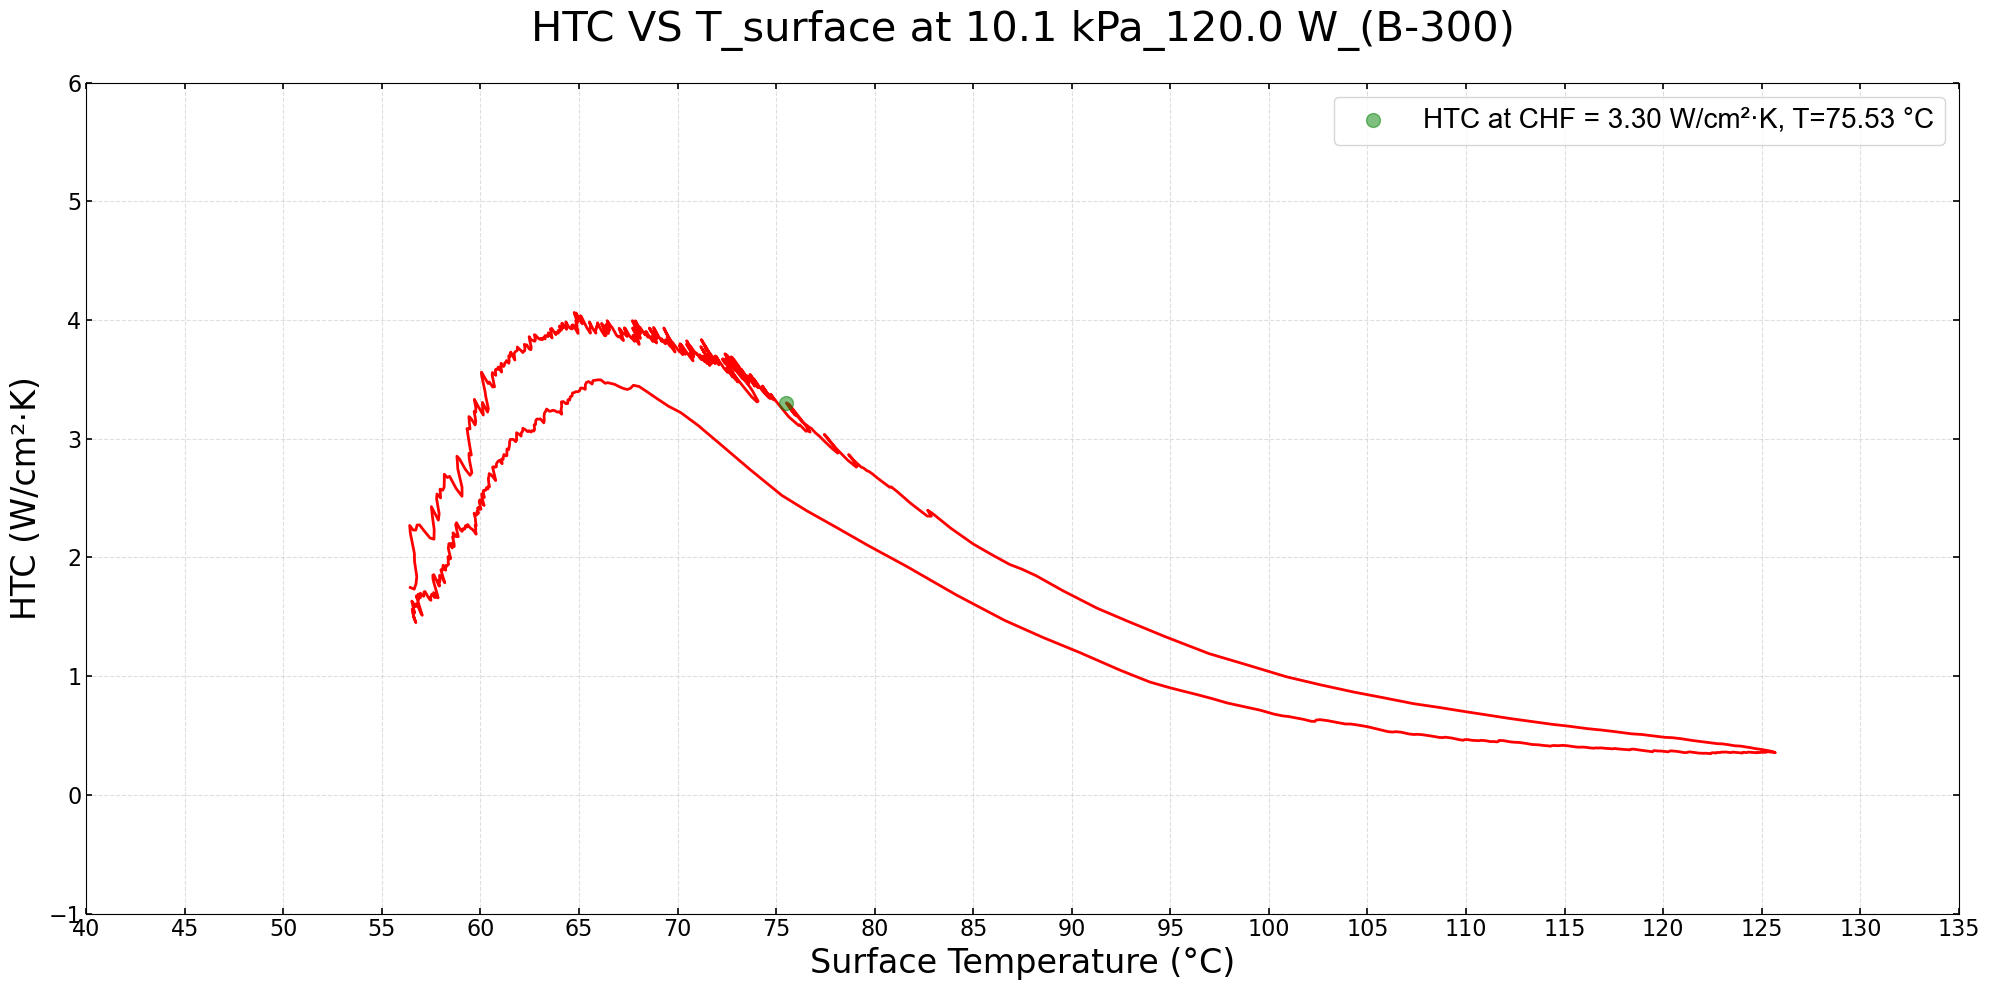

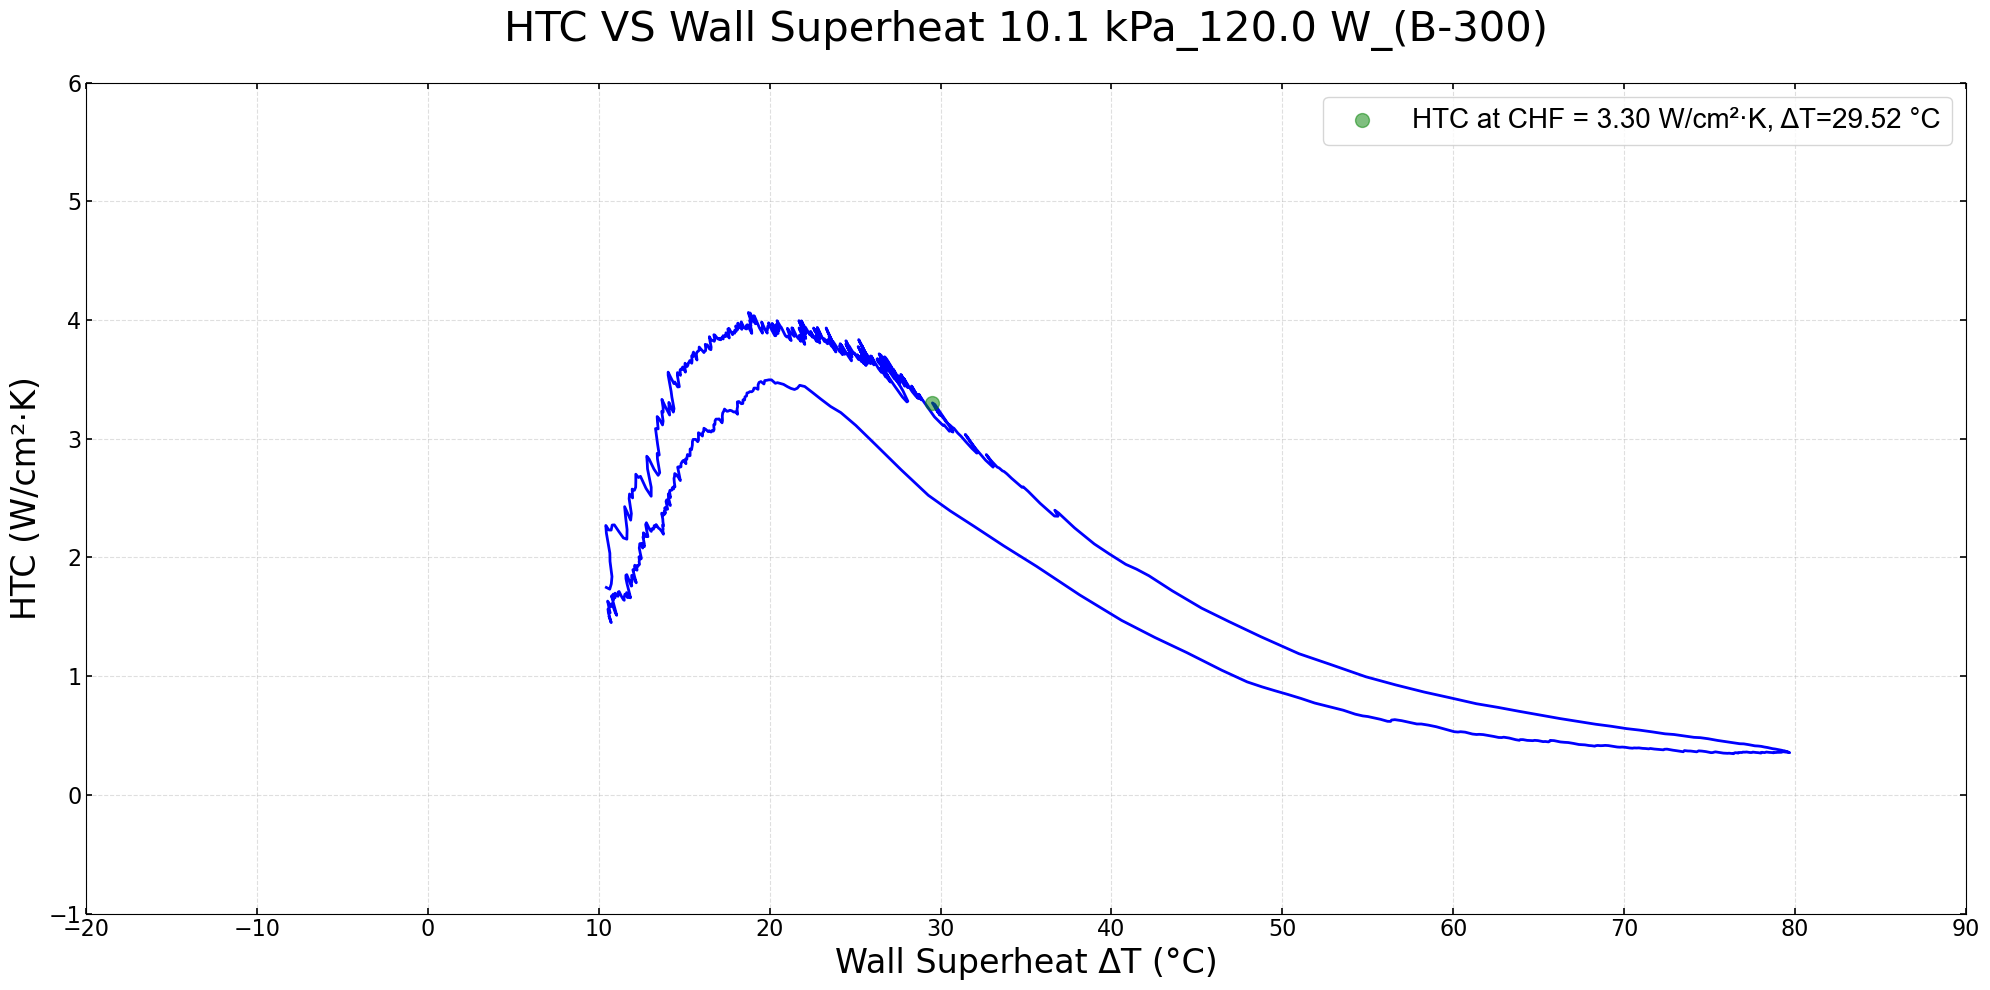

In [718]:
# If you already have chf_idx and nbr_idx:
htc_at_chf = float(htc[chf_idx])
htc_at_nbr = float(htc[nbr_idx])

print(f"CHF -> t={chf_time:.2f}s, q={chf_value:.2f} W/cm², htc={htc_at_chf:.2f} W/cm²·K, idx={chf_idx}")
print(f"NBR -> t={nbr_time:.2f}s, q={nbr_value:.2f} W/cm², htc={htc_at_nbr:.2f} W/cm²·K, idx={nbr_idx}")



# ---- Y-axis: integer ticks from (val_min - 1) to (val_max + 1) ----
y_bottom = int(np.floor(htc_MIN_ws_to_end)) 
y_top    = int(np.ceil(htc_MAX_ws_to_end)) 

# Guard against a zero-height range
if y_bottom >= y_top:
    y_bottom -= 1
    y_top    += 1

# ---------- Figure 1: Heat Flux vs Surface Temperature ----------
fig1, ax1 = plt.subplots(figsize=(20, 10))
#ax1.plot(Surface_Temperature, htc, color='red', linewidth=2)
ax1.plot(tsurf_ws_to_end[:, 1], htc_ws_to_end[:, 1], color='red', linewidth=2)
ax1.set_xlabel("Surface Temperature (°C)", fontsize=24)
ax1.set_ylabel("HTC (W/cm²·K)", fontsize=24)
ax1.set_title(f"HTC VS T_surface at {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=30, pad=30)
ax1.grid(True, linestyle='--', alpha=0.4)

# index of time closest to CHF
idx = int(np.nanargmin(np.abs(time_temp - chf_time)))

T_chf = float(Surface_Temperature[idx])   # x-value
htc_chf = float(htc[idx])                     # y-value

# On your T_surf vs q plot:
plt.scatter(T_chf, htc_chf, s=100, color='green', alpha=0.5, zorder=5,label=f"HTC at CHF = {htc_at_chf:.2f} W/cm²·K, T={T_chf:.2f} °C")

#### x-axis Ticks ####

#### x-axis Ticks ####
x_tick_start = x_step_Surface_Temperature * np.floor(ymin_Surface_Temperature / x_step_Surface_Temperature)
x_tick_end   = x_step_Surface_Temperature * np.ceil(ymax_Surface_Temperature / x_step_Surface_Temperature)
if x_tick_start >= ymin_Surface_Temperature:
    x_tick_start -= ymin_Surface_Temperature
if x_tick_end <= ymax_Surface_Temperature:
    x_tick_end += ymax_Surface_Temperature

# set new axis limits and ticks
ax1.set_xlim(x_tick_start, x_tick_end)
ax1.set_xticks(np.arange(x_tick_start - + x_step_Surface_Temperature, x_tick_end + 2*x_step_Surface_Temperature, x_step_Surface_Temperature))

y_tick_start = y_step_htc * np.floor(htc_MIN_ws_to_end / y_step_htc)
y_tick_end   = y_step_htc * np.ceil(htc_MAX_ws_to_end / y_step_htc)
if y_tick_start >= htc_MIN_ws_to_end:
    y_tick_start -= y_step_htc
if y_tick_end <= htc_MAX_ws_to_end:
    y_tick_end += y_step_htc

# set new y-limits and ticks
ax1.set_ylim(y_tick_start-y_step_htc, y_tick_end)
ax1.set_yticks(np.arange(y_tick_start-y_step_htc, y_tick_end +2*y_step_htc, y_step_htc))



ax1 = plt.gca()
# Ticks pointing inward on all sides, thicker & a bit longer
ax1.tick_params(axis='both', which='both',direction='in', top=True, right=True,width=1.2, length=4)

plt.xticks(fontsize=16)  # Increase x-axis tick size
plt.yticks(fontsize=16)  # Increase y-axis tick size

plt.legend(prop={'family':'Arial','size':20}, loc='upper right')

plt.tight_layout()
saved_figures.append((f"17_HTC_vs_Surface Temperature_{pressure_mean_kPa}kPa_{applied_heat_load} W_B-{boiling_id}", fig1))
plt.show()







# ---------- Figure 2: HTC vs Wall Superheat ----------
fig2, ax2 = plt.subplots(figsize=(20, 10))
#ax1.plot(Surface_Temperature, htc, color='red', linewidth=2)
ax2.plot(wall_superheat_ws_to_end[:, 1], htc_ws_to_end[:, 1], color='blue', linewidth=2)
ax2.set_xlabel("Wall Superheat ΔT (°C)", fontsize=24)
ax2.set_ylabel("HTC (W/cm²·K)", fontsize=24)
ax2.set_title(f"HTC VS Wall Superheat {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=30, pad=30)
ax2.grid(True, linestyle='--', alpha=0.4)

# index of time closest to CHF
idx = int(np.nanargmin(np.abs(time_temp - chf_time)))

T_chf = float(delta_T[idx])   # x-value
htc_chf = float(htc[idx])                     # y-value

# On your HTC vs Wall Superheat plot:
plt.scatter(T_chf, htc_chf, s=100, color='green', alpha=0.5, zorder=5,label=f"HTC at CHF = {htc_at_chf:.2f} W/cm²·K, ΔT={T_chf:.2f} °C")

x_tick_start = x_step_Wall_Superheat * np.floor(ymin_Wall_Superheat / x_step_Wall_Superheat)
x_tick_end   = x_step_Wall_Superheat * np.ceil(ymax_Wall_Superheat / x_step_Wall_Superheat)
if x_tick_start >= ymin_Wall_Superheat:
    x_tick_start -= ymin_Wall_Superheat
if x_tick_end <= ymax_Wall_Superheat:
    x_tick_end += ymax_Wall_Superheat

# set new axis limits and ticks
ax2.set_xlim(x_tick_start, x_tick_end)
ax2.set_xticks(np.arange(x_tick_start - + x_step_Wall_Superheat, x_tick_end + 2*x_step_Wall_Superheat, x_step_Wall_Superheat))

y_tick_start = y_step_htc * np.floor(htc_MIN_ws_to_end / y_step_htc)
y_tick_end   = y_step_htc * np.ceil(htc_MAX_ws_to_end / y_step_htc)
if y_tick_start >= htc_MIN_ws_to_end:
    y_tick_start -= y_step_htc
if y_tick_end <= htc_MAX_ws_to_end:
    y_tick_end += y_step_htc

# set new y-limits and ticks
ax2.set_ylim(y_tick_start-y_step_htc, y_tick_end)
ax2.set_yticks(np.arange(y_tick_start-y_step_htc, y_tick_end +2*y_step_htc, y_step_htc))

ax2 = plt.gca()
# Ticks pointing inward on all sides, thicker & a bit longer
ax2.tick_params(axis='both', which='both',direction='in', top=True, right=True,width=1.2, length=4)

plt.xticks(fontsize=16)  # Increase x-axis tick size
plt.yticks(fontsize=16)  # Increase y-axis tick size

plt.legend(prop={'family':'Arial','size':20}, loc='upper right')

plt.tight_layout()
saved_figures.append((f"18_TC_vs_Wall Superheat_{pressure_mean_kPa}kPa_B-{boiling_id}", fig2))
plt.show()


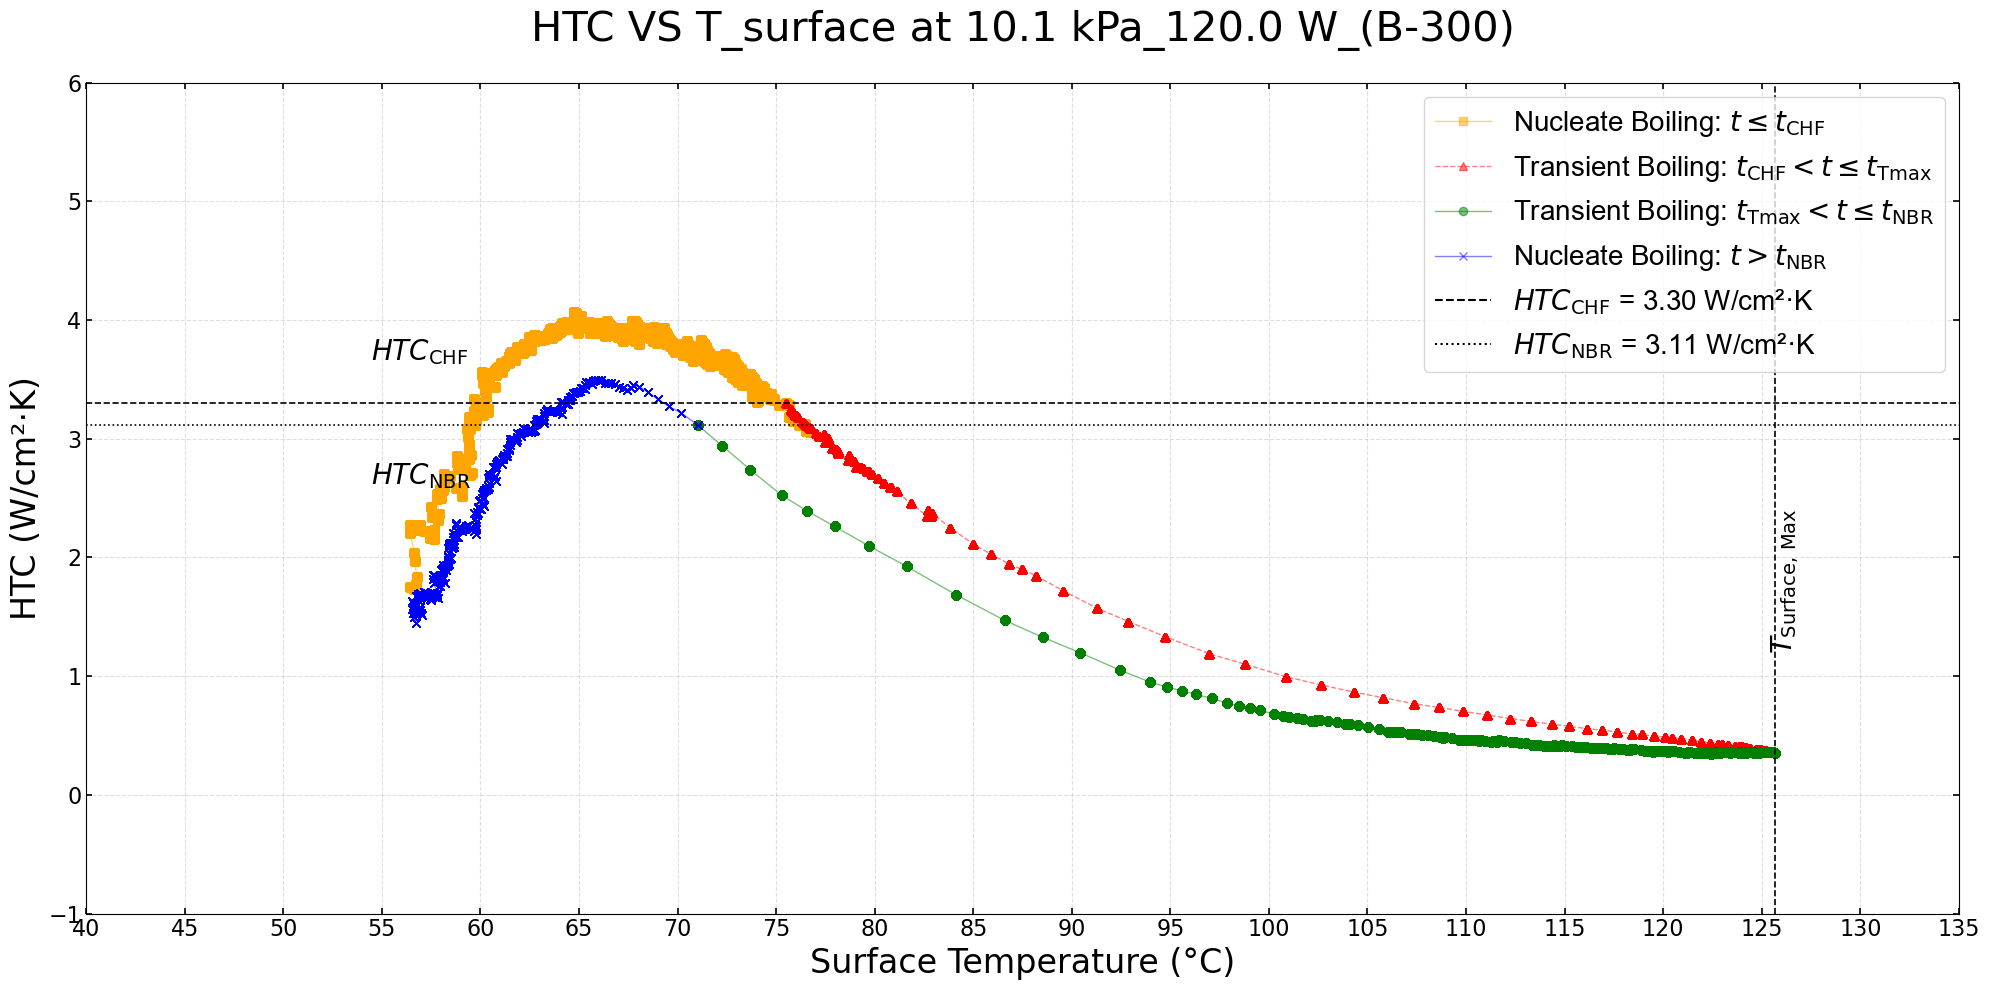

In [719]:
# ---------- HTC vs Surface Temperature (window_start → end, 4 segments) ----------
fig1, ax1 = plt.subplots(figsize=(20, 10))

# Use your already-defined instants
t_chf  = float(chf_time)
t_tmax = float(time_at_max_Surface_Temperature)   # time at T_surface,max
t_nbr  = float(nbr_time)

# Base window mask (time >= window_start)
# (you already computed mask_ws_end earlier; reuse it here)
# mask_ws_end = (time_temp >= window_start)

# Four time-regime masks, restricted to the window
m_nb1_ws = mask_ws_end & (time_temp <= t_chf)                               # NB: t ≤ t_CHF
m_tb1_ws = mask_ws_end & (time_temp >  t_chf) & (time_temp <= t_tmax)       # TB: t_CHF < t ≤ t_Tmax
m_tb2_ws = mask_ws_end & (time_temp >  t_tmax) & (time_temp <= t_nbr)       # TB: t_Tmax < t ≤ t_NBR
m_nb2_ws = mask_ws_end & (time_temp >  t_nbr)                               # NB: t > t_NBR

# Plot each regime (same markers/colors/alpha as before)
if np.any(m_nb1_ws):
    ax1.plot(Surface_Temperature[m_nb1_ws], htc[m_nb1_ws],
             linestyle='-', marker='s', markersize=6, linewidth=1, alpha=0.5,
             color='orange', label=r'Nucleate Boiling: $t \leq t_{\mathrm{CHF}}$')

if np.any(m_tb1_ws):
    ax1.plot(Surface_Temperature[m_tb1_ws], htc[m_tb1_ws],
             linestyle='--', marker='^', markersize=6, linewidth=1, alpha=0.5,
             color='red', label=r'Transient Boiling: $t_{\mathrm{CHF}} < t \leq t_{\mathrm{Tmax}}$')

if np.any(m_tb2_ws):
    ax1.plot(Surface_Temperature[m_tb2_ws], htc[m_tb2_ws],
             linestyle='-', marker='o', markersize=6, linewidth=1, alpha=0.5,
             color='green', label=r'Transient Boiling: $t_{\mathrm{Tmax}} < t \leq t_{\mathrm{NBR}}$')

if np.any(m_nb2_ws):
    ax1.plot(Surface_Temperature[m_nb2_ws], htc[m_nb2_ws],
             linestyle='-', marker='x', markersize=6, linewidth=1, alpha=0.5,
             color='blue', label=r'Nucleate Boiling: $t > t_{\mathrm{NBR}}$')
    

# Put labels at 3% from the left; change 0.03 → 0.98 for right edge, etc.
xmin, xmax = ax1.get_xlim()
xpos = lambda frac: xmin + frac * (xmax - xmin)

# CHF line label (italic q, superscript '', upright CHF subscript)
ax1.text(xpos(0.02), htc_at_chf + 0.3, r"$HTC_{\mathrm{CHF}}$",fontsize=20, ha='left', va='bottom')

# NBR line label
ax1.text(xpos(0.02), htc_at_nbr - 0.3, r"$HTC_{\mathrm{NBR}}$",fontsize=20, ha='left', va='top')

# Horizontal dashed lines at q''_CHF and q''_nbr (using your chf_value / nbr_value)
ax1.axhline(htc_at_chf, linestyle='--', linewidth=1.2, color='black')
ax1.axhline(htc_at_nbr, linestyle=':', linewidth=1.2, color='black')

# Axes labels, title, grid
ax1.set_xlabel("Surface Temperature (°C)", fontsize=24)
ax1.set_ylabel("HTC (W/cm²·K)", fontsize=24)
ax1.set_title(
    f"HTC VS T_surface at {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})",
    fontsize=30, pad=30
)
ax1.grid(True, linestyle='--', alpha=0.4)

# Vertical dashed line at T_s,max (using your max_Surface_Temperature)
# Dotted vertical line (as you had)
ax1.axvline(max_Surface_Temperature, linestyle='--', linewidth=1.2, color='black')

# --- Control the vertical position here (0 = bottom, 1 = top) ---
ymin_current, ymax_current = ax1.get_ylim()
y_frac = 0.40                      # try 0.95 (near top), 0.50 (middle), etc.
y_pos = ymin_current + y_frac * (ymax_current - ymin_current)

# Optional tiny horizontal nudge off the line (data units); set to 0 to sit on the line
x_shift = 0.5

# Label: T with upright subscript "Surface, Max"
ax1.text(max_Surface_Temperature + x_shift, y_pos,r"$T_{\mathrm{Surface,\,Max}}$",fontsize=20, rotation=90, ha='center', va='center')

#### x-axis Ticks ####
x_tick_start = x_step_Surface_Temperature * np.floor(ymin_Surface_Temperature / x_step_Surface_Temperature)
x_tick_end   = x_step_Surface_Temperature * np.ceil(ymax_Surface_Temperature / x_step_Surface_Temperature)
if x_tick_start >= ymin_Surface_Temperature:
    x_tick_start -= ymin_Surface_Temperature
if x_tick_end <= ymax_Surface_Temperature:
    x_tick_end += ymax_Surface_Temperature

# set new axis limits and ticks
ax1.set_xlim(x_tick_start, x_tick_end)
ax1.set_xticks(np.arange(x_tick_start - + x_step_Surface_Temperature, x_tick_end + 2*x_step_Surface_Temperature, x_step_Surface_Temperature))

# Y ticks (use your precomputed window-based bounds)
y_tick_start = y_step_htc * np.floor(htc_MIN_ws_to_end / y_step_htc)
y_tick_end   = y_step_htc * np.ceil(htc_MAX_ws_to_end / y_step_htc)
if y_tick_start >= htc_MIN_ws_to_end:
    y_tick_start -= y_step_htc
if y_tick_end <= htc_MAX_ws_to_end:
    y_tick_end += y_step_htc

# set new y-limits and ticks
ax1.set_ylim(y_tick_start-y_step_htc, y_tick_end)
ax1.set_yticks(np.arange(y_tick_start-y_step_htc, y_tick_end +2*y_step_htc, y_step_htc))

# Ticks inward
ax1.tick_params(axis='both', which='both', direction='in', top=True, right=True, width=1.2, length=4)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax1.plot([], [], linestyle='--', color='black',label=r"$HTC_{\mathrm{CHF}}$ = " + f"{htc_at_chf:.2f} W/cm²·K")
ax1.plot([], [], linestyle=':', color='black',label=r"$HTC_{\mathrm{NBR}}$ = " + f"{htc_at_nbr:.2f} W/cm²·K")

# Legend and show
plt.legend(prop={'family':'Arial','size':20}, loc='upper right')
plt.tight_layout()
saved_figures.append((f"19_HTC_vs_Surface Temperature_{pressure_mean_kPa}kPa_{applied_heat_load} W_B-{boiling_id}", fig1))
plt.show()


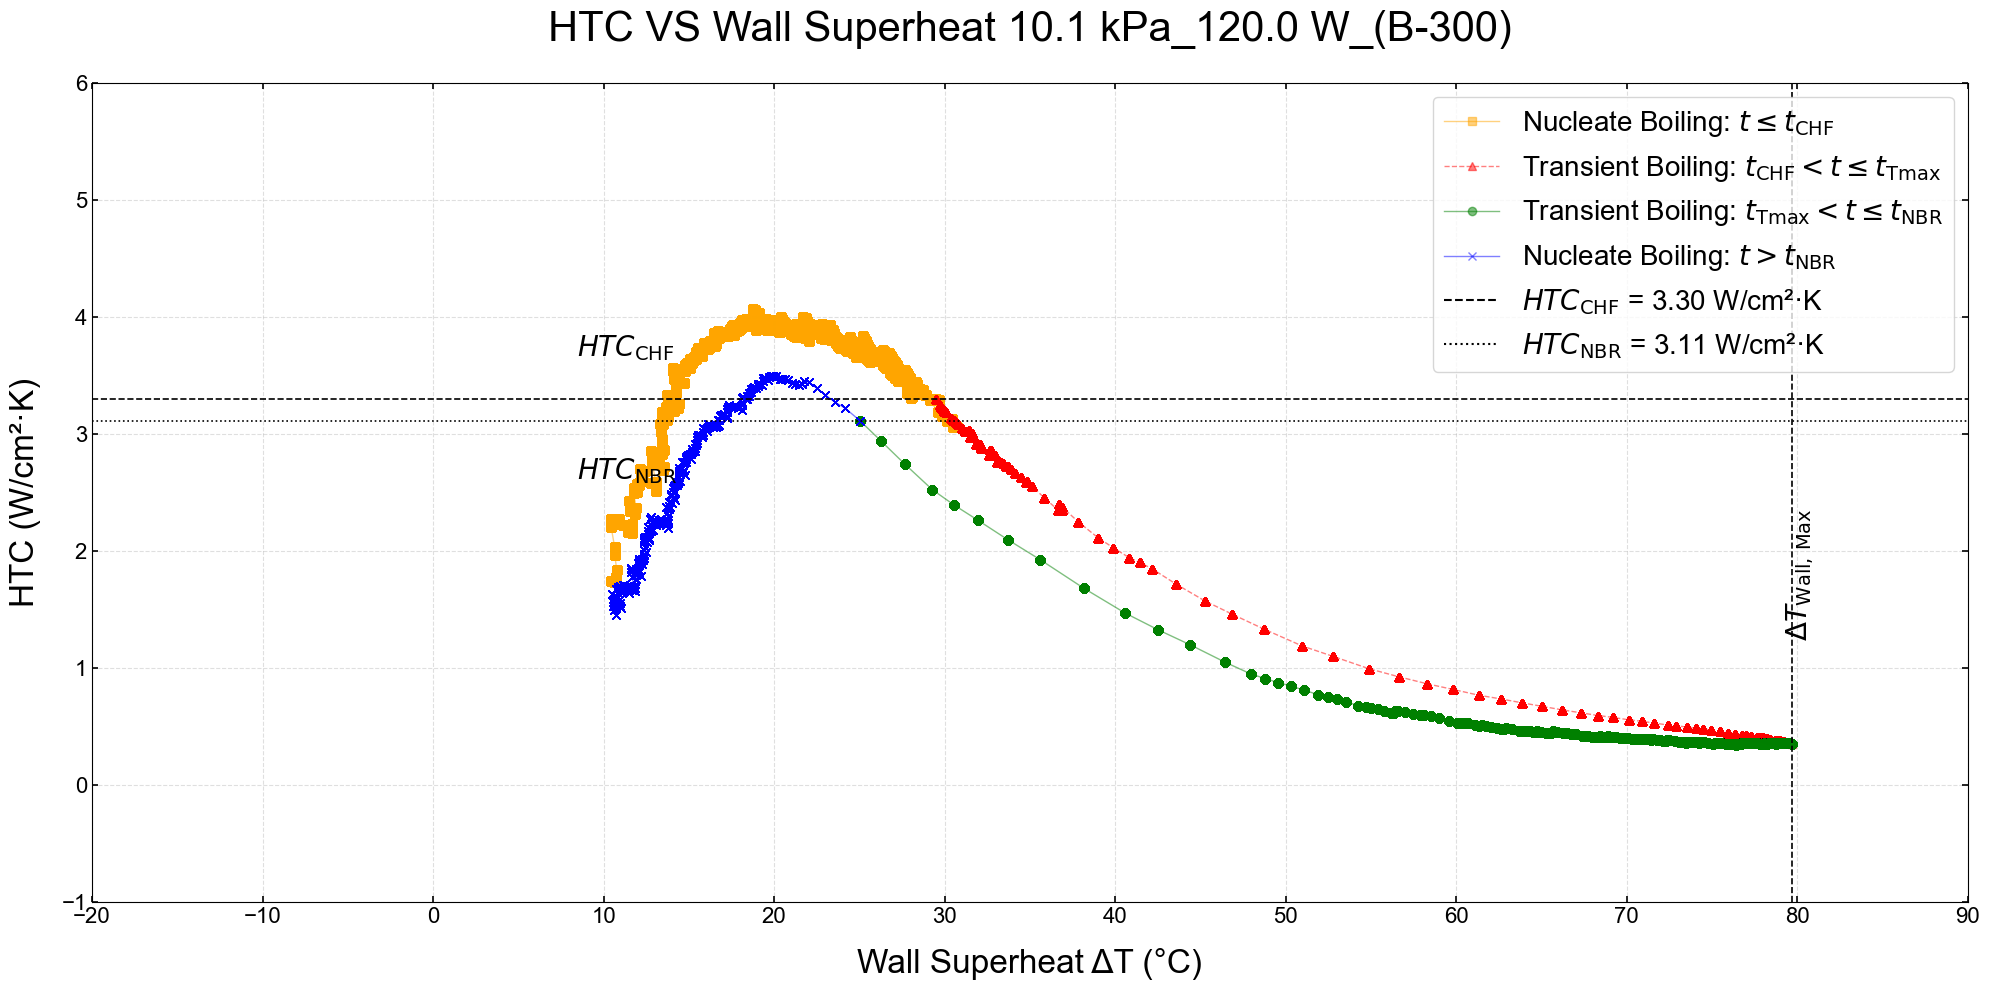

In [720]:
# ---------- HTC vs Wall Superheat (window_start → end, 4 segments) ----------
fig2, ax2 = plt.subplots(figsize=(20, 10))

# Time instants
t_chf  = float(chf_time)
t_tmax = float(time_at_max_Surface_Temperature)   # time at T_surface,max
t_nbr  = float(nbr_time)

# Four time-regime masks, restricted to the window
m_nb1_ws = mask_ws_end & (time_temp <= t_chf)                               # NB: t ≤ t_CHF
m_tb1_ws = mask_ws_end & (time_temp >  t_chf) & (time_temp <= t_tmax)       # TB: t_CHF < t ≤ t_Tmax
m_tb2_ws = mask_ws_end & (time_temp >  t_tmax) & (time_temp <= t_nbr)       # TB: t_Tmax < t ≤ t_NBR
m_nb2_ws = mask_ws_end & (time_temp >  t_nbr)                               # NB: t > t_NBR

# Plot each regime (ΔT vs HTC)
if np.any(m_nb1_ws):
    ax2.plot(delta_T[m_nb1_ws], htc[m_nb1_ws],
             linestyle='-', marker='s', markersize=6, linewidth=1, alpha=0.5,
             color='orange', label=r'Nucleate Boiling: $t \leq t_{\mathrm{CHF}}$')

if np.any(m_tb1_ws):
    ax2.plot(delta_T[m_tb1_ws], htc[m_tb1_ws],
             linestyle='--', marker='^', markersize=6, linewidth=1, alpha=0.5,
             color='red', label=r'Transient Boiling: $t_{\mathrm{CHF}} < t \leq t_{\mathrm{Tmax}}$')

if np.any(m_tb2_ws):
    ax2.plot(delta_T[m_tb2_ws], htc[m_tb2_ws],
             linestyle='-', marker='o', markersize=6, linewidth=1, alpha=0.5,
             color='green', label=r'Transient Boiling: $t_{\mathrm{Tmax}} < t \leq t_{\mathrm{NBR}}$')

if np.any(m_nb2_ws):
    ax2.plot(delta_T[m_nb2_ws], htc[m_nb2_ws],
             linestyle='-', marker='x', markersize=6, linewidth=1, alpha=0.5,
             color='blue', label=r'Nucleate Boiling: $t > t_{\mathrm{NBR}}$')

# Put labels at 3% from the left; change 0.03 → 0.98 for right edge, etc.
xmin, xmax = ax2.get_xlim()
xpos = lambda frac: xmin + frac * (xmax - xmin)

# CHF line label (italic q, superscript '', upright CHF subscript)
ax2.text(xpos(0.02), htc_at_chf + 0.3, r"$HTC_{\mathrm{CHF}}$",fontsize=20, ha='left', va='bottom')

# NBR line label
ax2.text(xpos(0.02), htc_at_nbr - 0.3, r"$HTC_{\mathrm{NBR}}$",fontsize=20, ha='left', va='top')

# Horizontal dashed lines at q''_CHF and q''_nbr (using your chf_value / nbr_value)
ax2.axhline(htc_at_chf, linestyle='--', linewidth=1.2, color='black')
ax2.axhline(htc_at_nbr, linestyle=':', linewidth=1.2, color='black')


# --- Vertical dashed line at max_Wall_Superheat (instead of T_surface,max) ---
max_Wall_Superheat = float(max_Surface_Temperature - T_sat)   # keep this variable name
ax2.axvline(max_Wall_Superheat, linestyle='--', linewidth=1.2, color='black')

# Control vertical label position along the line (0 = bottom, 1 = top)
ymin2, ymax2 = ax2.get_ylim()
y_frac2 = 0.40
y_pos2 = ymin2 + y_frac2 * (ymax2 - ymin2)

# Optional small horizontal nudge from the line (data units)
x_shift2 = 0.5
ax2.text(max_Wall_Superheat + x_shift2, y_pos2,r"$\Delta T_{\mathrm{Wall,\,Max}}$",fontsize=20, rotation=90, ha='center', va='center')

# Axes labels, title, grid
ax2.set_xlabel("Wall Superheat ΔT (°C)", fontsize=24, fontname='Arial', labelpad=15)
ax2.set_ylabel("HTC (W/cm²·K)", fontsize=24, fontname='Arial', labelpad=15)
ax2.set_title(
    f"HTC VS Wall Superheat {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})",
    fontsize=30, pad=30, fontname='Arial'
)
ax2.grid(True, linestyle='--', alpha=0.4)

#### x-axis Ticks ####
x_tick_start = x_step_Wall_Superheat * np.floor(ymin_Wall_Superheat / x_step_Wall_Superheat)
x_tick_end   = x_step_Wall_Superheat * np.ceil(ymax_Wall_Superheat / x_step_Wall_Superheat)
if x_tick_start >= ymin_Wall_Superheat:
    x_tick_start -= ymin_Wall_Superheat
if x_tick_end <= ymax_Wall_Superheat:
    x_tick_end += ymax_Wall_Superheat

# set new axis limits and ticks
ax2.set_xlim(x_tick_start, x_tick_end)
ax2.set_xticks(np.arange(x_tick_start - + x_step_Wall_Superheat, x_tick_end + 2*x_step_Wall_Superheat, x_step_Wall_Superheat))

y_tick_start = y_step_htc * np.floor(htc_MIN_ws_to_end / y_step_htc)
y_tick_end   = y_step_htc * np.ceil(htc_MAX_ws_to_end / y_step_htc)
if y_tick_start >= htc_MIN_ws_to_end:
    y_tick_start -= y_step_htc
if y_tick_end <= htc_MAX_ws_to_end:
    y_tick_end += y_step_htc

# set new y-limits and ticks
ax2.set_ylim(y_tick_start-y_step_htc, y_tick_end)
ax2.set_yticks(np.arange(y_tick_start-y_step_htc, y_tick_end +2*y_step_htc, y_step_htc))

# Ticks inward
ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True, width=1.2, length=4)
plt.xticks(fontsize=16, fontname='Arial')
plt.yticks(fontsize=16, fontname='Arial')


ax2.plot([], [], linestyle='--', color='black',label=r"$HTC_{\mathrm{CHF}}$ = " + f"{htc_at_chf:.2f} W/cm²·K")
ax2.plot([], [], linestyle=':', color='black',label=r"$HTC_{\mathrm{NBR}}$ = " + f"{htc_at_nbr:.2f} W/cm²·K")

# Legend and show
plt.legend(prop={'family':'Arial','size':20}, loc='upper right')
plt.tight_layout()
saved_figures.append((f"20_HTC_vs_Wall Superheat_{pressure_mean_kPa}kPa_{applied_heat_load} W_B-{boiling_id}", fig2))
plt.show()


#### HTC VS (Surface Temperature & Wall Superheat) up to CHF

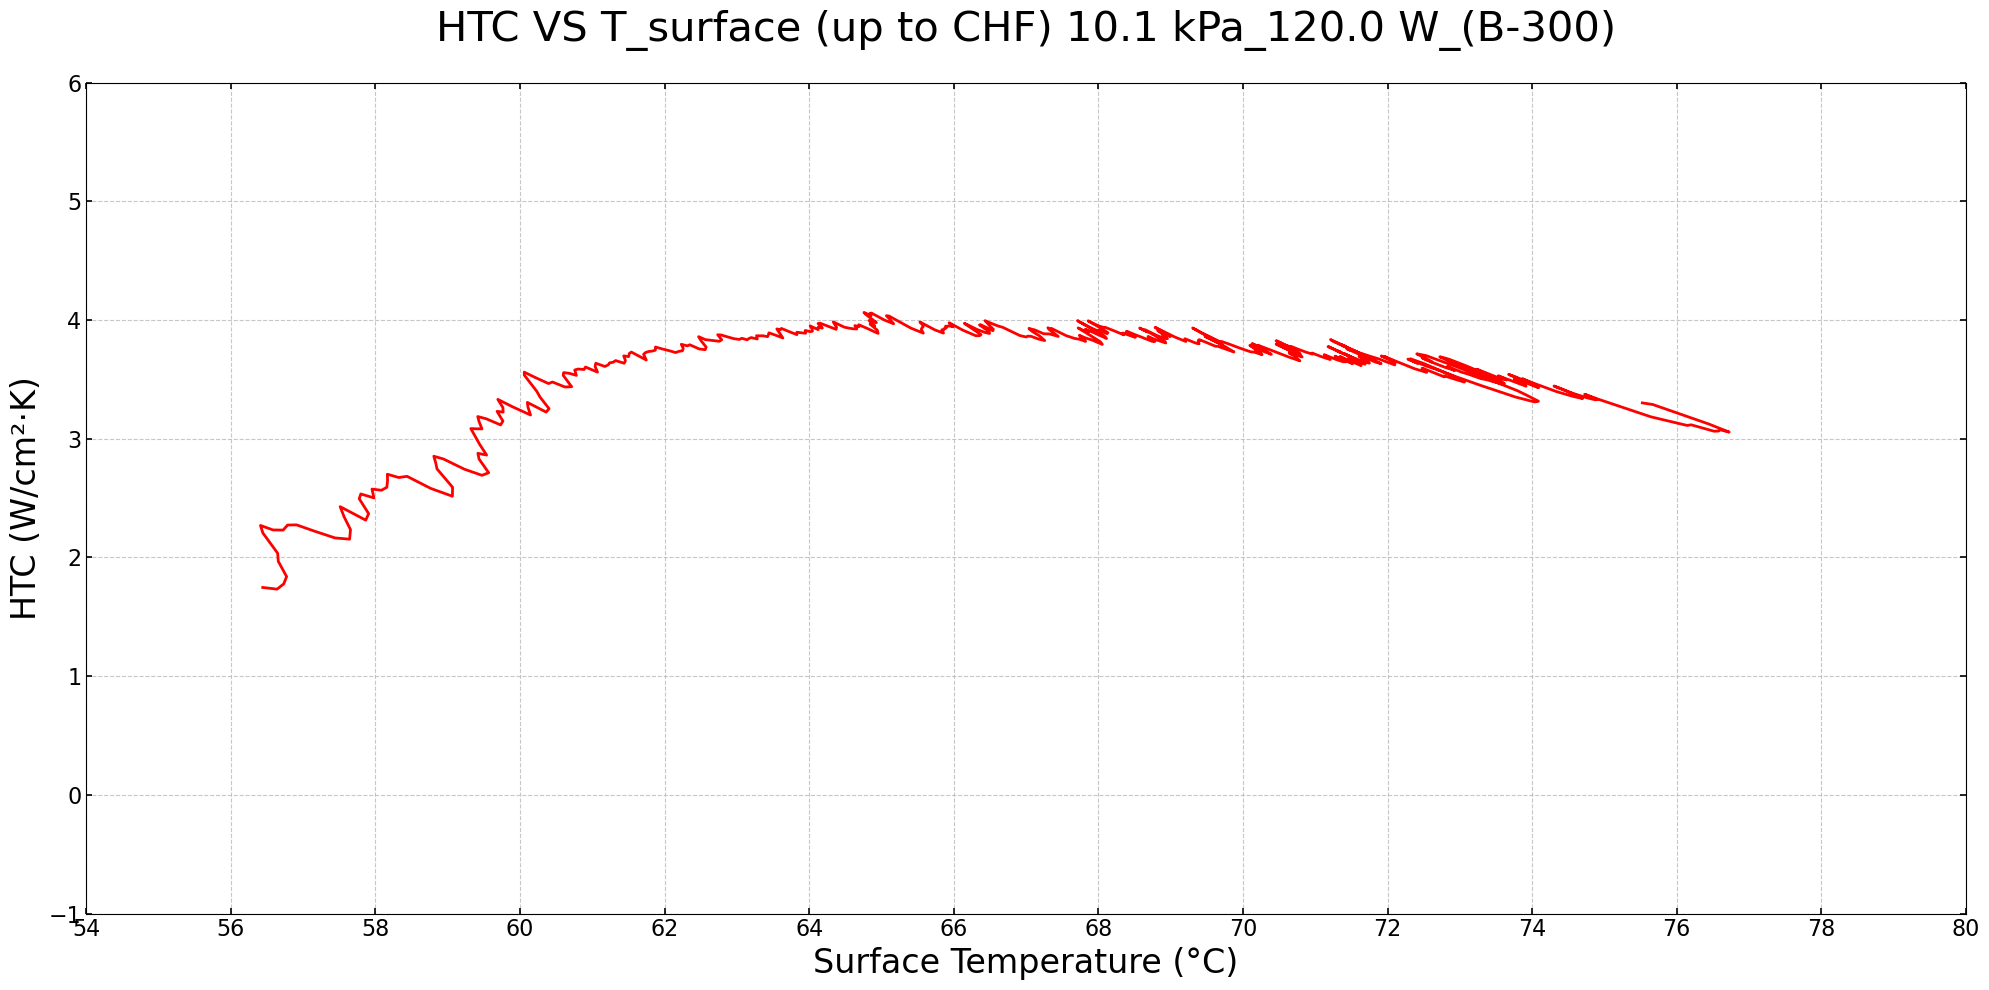

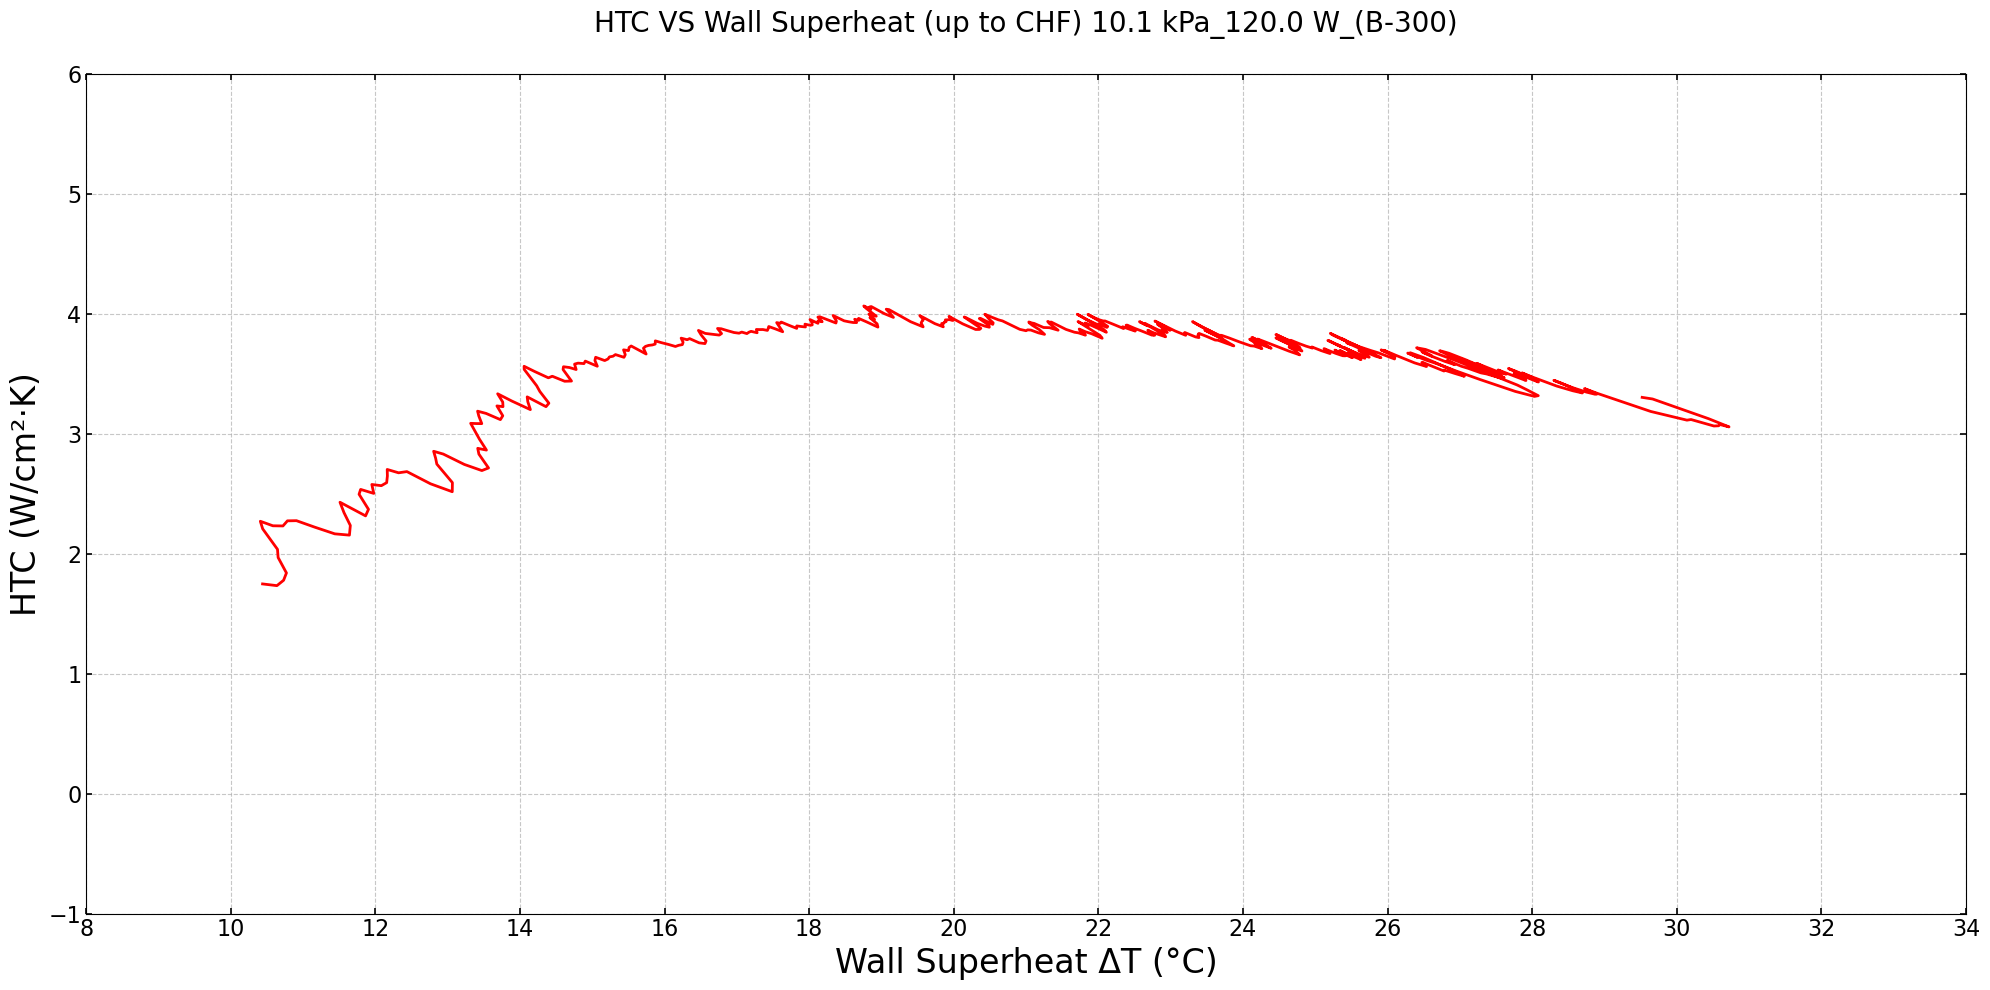

In [721]:
# ---- Y-axis: integer ticks from (val_min - 1) to (val_max + 1) ----
y_bottom = int(np.floor(htc_MIN_ws_to_chf)) 
y_top    = int(np.ceil(htc_MAX_ws_to_chf)) 

# Guard against a zero-height range
if y_bottom >= y_top:
    y_bottom -= 1
    y_top    += 1

# ---------- Figure 1: Heat Flux vs Surface Temperature ----------
fig1, ax1 = plt.subplots(figsize=(20, 10))
#ax1.plot(Surface_Temperature, htc, color='red', linewidth=2)
ax1.plot(tsurf_ws_to_chf[:, 1], htc_ws_to_chf[:, 1], color='red', linewidth=2)
ax1.set_xlabel("Surface Temperature (°C)", fontsize=24)
ax1.set_ylabel("HTC (W/cm²·K)", fontsize=24)
ax1.set_title(f"HTC VS T_surface (up to CHF) {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=30, pad=30)
ax1.grid(True, linestyle='--', alpha=0.7)

#### x-axis Ticks ####
# ---- Surface temperature axis (use the plotted slice) ----
xmin = float(np.nanmin(tsurf_ws_to_chf[:, 1]))
xmax = float(np.nanmax(tsurf_ws_to_chf[:, 1]))

x_step_ws_to_end = 2

x_tick_start = x_step_ws_to_end * np.floor(xmin / x_step_ws_to_end)
x_tick_end   = x_step_ws_to_end * np.ceil (xmax / x_step_ws_to_end)

# pad by *one step*, not by the min/max value
if x_tick_start >= xmin: x_tick_start -= x_step_ws_to_end
if x_tick_end   <= xmax: x_tick_end   += x_step_ws_to_end

ax1.set_xlim(x_tick_start, x_tick_end)
ax1.set_xticks(np.arange(x_tick_start -x_step_ws_to_end, x_tick_end + 2*x_step_ws_to_end,x_step_ws_to_end))

y_tick_start = y_step_htc * np.floor(htc_MIN_ws_to_end / y_step_htc)
y_tick_end   = y_step_htc * np.ceil(htc_MAX_ws_to_end / y_step_htc)
if y_tick_start >= htc_MIN_ws_to_end:
    y_tick_start -= y_step_htc
if y_tick_end <= htc_MAX_ws_to_end:
    y_tick_end += y_step_htc

# set new y-limits and ticks
ax1.set_ylim(y_tick_start-y_step_htc, y_tick_end)
ax1.set_yticks(np.arange(y_tick_start-y_step_htc, y_tick_end +2*y_step_htc, y_step_htc))

ax1 = plt.gca()
# Ticks pointing inward on all sides, thicker & a bit longer
ax1.tick_params(axis='both', which='both',direction='in', top=True, right=True,width=1.2, length=4)

plt.xticks(fontsize=16)  # Increase x-axis tick size
plt.yticks(fontsize=16)  # Increase y-axis tick size

plt.tight_layout()
saved_figures.append((f"21_HTC_vs_Surface Temperature (up to CHF) {pressure_mean_kPa}kPa_B-{boiling_id}", fig1))
plt.show()











# ---------- Figure 2: Heat Flux vs Wall Superheat ----------
fig2, ax2 = plt.subplots(figsize=(20,10))
#ax1.plot(Surface_Temperature, htc, color='red', linewidth=2)
ax2.plot(wall_superheat_ws_to_chf[:, 1], htc_ws_to_chf[:, 1], color='red', linewidth=2)
ax2.set_xlabel("Wall Superheat ΔT (°C)", fontsize=24)
ax2.set_ylabel("HTC (W/cm²·K)", fontsize=24)
ax2.set_title(f"HTC VS Wall Superheat (up to CHF) {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=20, pad=30)
ax2.grid(True, linestyle='--', alpha=0.7)

#### x-axis Ticks ####
xmin2 = float(np.nanmin(wall_superheat_ws_to_chf[:, 1]))
xmax2 = float(np.nanmax(wall_superheat_ws_to_chf[:, 1]))

x_step_ws_to_end = 2

x_tick_start = x_step_ws_to_end * np.floor(xmin2 / x_step_ws_to_end)
x_tick_end   = x_step_ws_to_end * np.ceil (xmax2 / x_step_ws_to_end)

# pad by *one step*, not by the min/max value
if x_tick_start >= xmin2: x_tick_start -= x_step_ws_to_end
if x_tick_end   <= xmax2: x_tick_end   += x_step_ws_to_end

ax2.set_xlim(x_tick_start, x_tick_end)
ax2.set_xticks(np.arange(x_tick_start -x_step_ws_to_end, x_tick_end + 2*x_step_ws_to_end,x_step_ws_to_end))

y_tick_start = y_step_htc * np.floor(htc_MIN_ws_to_end / y_step_htc)
y_tick_end   = y_step_htc * np.ceil(htc_MAX_ws_to_end / y_step_htc)
if y_tick_start >= htc_MIN_ws_to_end:
    y_tick_start -= y_step_htc
if y_tick_end <= htc_MAX_ws_to_end:
    y_tick_end += y_step_htc

# set new y-limits and ticks
ax2.set_ylim(y_tick_start-y_step_htc, y_tick_end)
ax2.set_yticks(np.arange(y_tick_start-y_step_htc, y_tick_end +2*y_step_htc, y_step_htc))

ax2 = plt.gca()
# Ticks pointing inward on all sides, thicker & a bit longer
ax2.tick_params(axis='both', which='both',direction='in', top=True, right=True,width=1.2, length=4)

plt.xticks(fontsize=16)  # Increase x-axis tick size
plt.yticks(fontsize=16)  # Increase y-axis tick size

plt.tight_layout()
saved_figures.append((f"22_HTC_vs_Wall Superheat (up to CHF) {pressure_mean_kPa}kPa_B-{boiling_id}", fig2))
plt.show()

#### Boiling Curve (HTC vs q)

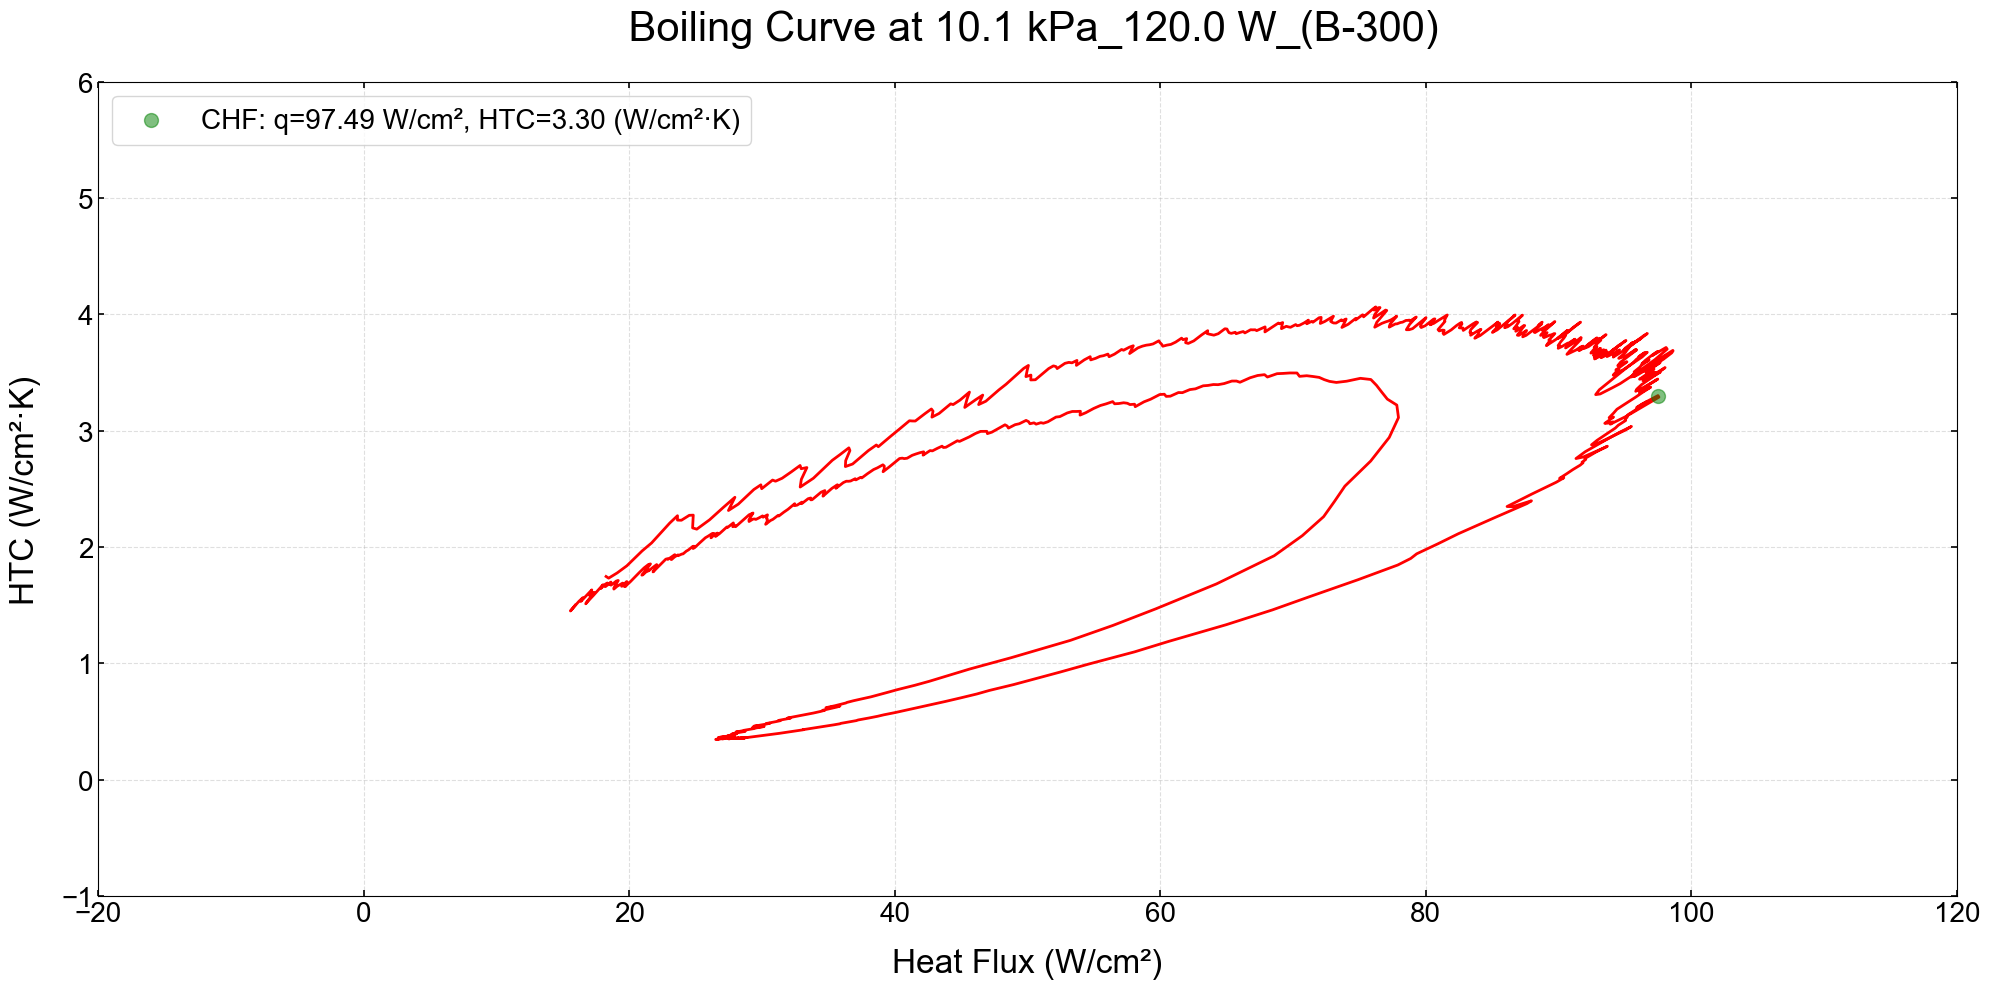

In [722]:
# --- Guard: nothing to plot if window has no points ---
if not np.any(mask_ws_end):
    print("mask_ws_end produced no points; nothing to plot for the Boiling Curve.")
else:
    # Slice to window_start → end
    q_ws   = q[mask_ws_end]
    htc_ws = htc[mask_ws_end]

    plt.figure(figsize=(20, 10))
    plt.plot(q_ws, htc_ws, color='red', linewidth=2)
    plt.xlabel("Heat Flux (W/cm²)", fontsize=24, fontname='Arial', labelpad=15)
    plt.ylabel("HTC (W/cm²·K)", fontsize=24, fontname='Arial', labelpad=15)
    plt.title(f" Boiling Curve at {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})",
              fontsize=30, pad=30, fontname='Arial')

    # CHF marker only if CHF is inside the window
    idx = int(np.nanargmin(np.abs(time_temp - chf_time)))
    if time_temp[idx] >= window_start:
        T_chf  = float(q[idx])        # x-value (heat flux at CHF)
        htc_chf = float(htc[idx])     # y-value (HTC at CHF)
        plt.scatter(T_chf, htc_chf, s=100, color='green', alpha=0.5, zorder=5,
                    label=f"CHF: q={T_chf:.2f} W/cm², HTC={htc_chf:.2f} (W/cm²·K)")




    ax = plt.gca()


    x_tick_start = x_step_q * np.floor(ymin_q / x_step_q)
    x_tick_end   = x_step_q * np.ceil(ymax_q / x_step_q)
    if x_tick_start >= ymin_q:
        x_tick_start -= y_step_q
    if x_tick_end <= ymax_q:
        x_tick_end += y_step_q

    # set new y-limits and ticks
    ax.set_xlim(x_tick_start, x_tick_end)
    ax.set_xticks(np.arange(x_tick_start, x_tick_end +2*x_step_q, x_step_q))

   
    y_tick_start = y_step_htc * np.floor(htc_MIN_ws_to_end / y_step_htc)
    y_tick_end   = y_step_htc * np.ceil(htc_MAX_ws_to_end / y_step_htc)
    if y_tick_start >= htc_MIN_ws_to_end:
        y_tick_start -= y_step_htc
    if y_tick_end <= htc_MAX_ws_to_end:
        y_tick_end += y_step_htc

    # set new y-limits and ticks
    ax.set_ylim(y_tick_start-y_step_htc, y_tick_end)
    ax.set_yticks(np.arange(y_tick_start-y_step_htc, y_tick_end +2*y_step_htc, y_step_htc))


    # Ticks inward on all sides
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, width=1.2, length=4)



    plt.xticks(fontsize=20, fontname='Arial')
    plt.yticks(fontsize=20, fontname='Arial')
    plt.legend(prop={'family':'Arial','size':20}, loc='upper left')

    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()

    # Save figure
    saved_figures.append((f"23_Boiling Curve_{pressure_mean_kPa}kPa B-{boiling_id}", plt.gcf()))
    plt.show()


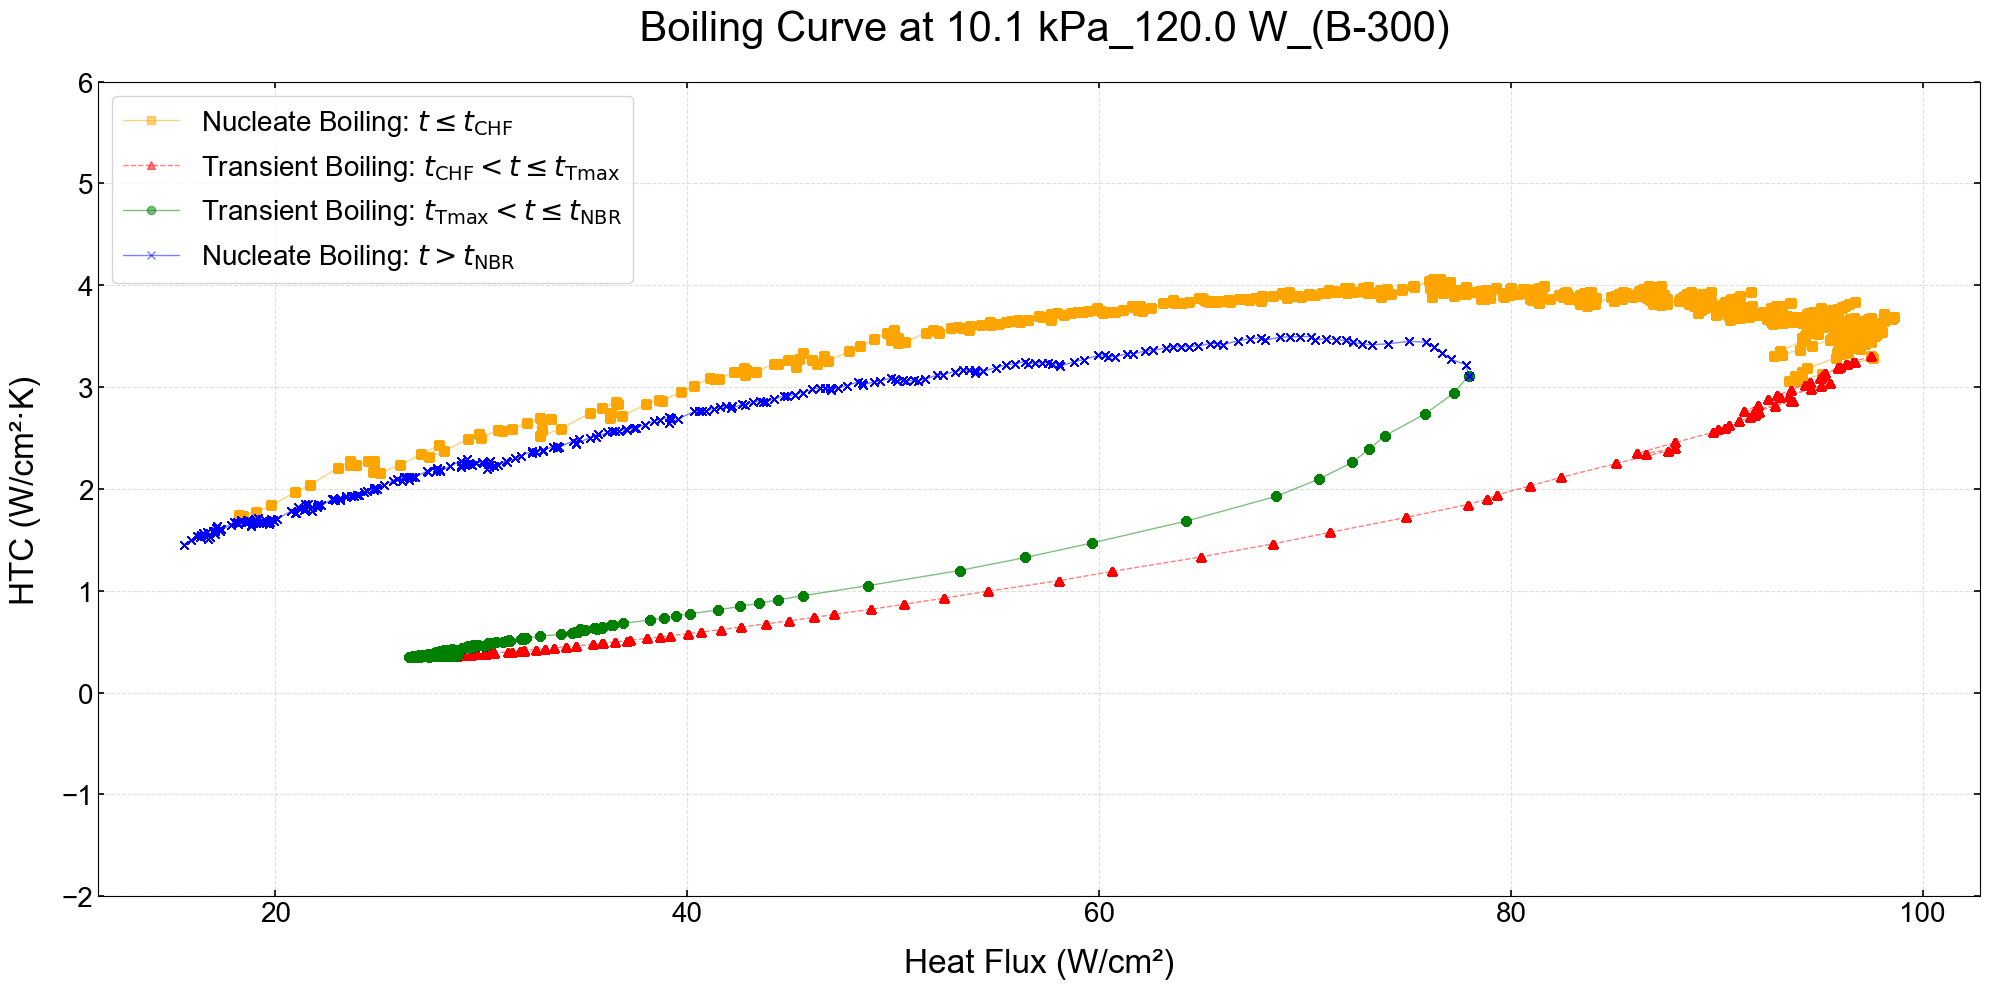

In [723]:
# --- Guard: nothing to plot if window has no points ---
if not np.any(mask_ws_end):
    print("mask_ws_end produced no points; nothing to plot for the Boiling Curve.")
else:
    # Time instants
    t_chf  = float(chf_time)
    try:
        t_tmax = float(time_at_max_Surface_Temperature)  # time at T_surface,max
    except NameError:
        t_tmax = float(time_temp[np.nanargmax(Surface_Temperature)])
    t_nbr  = float(nbr_time)

    # Restrict to window_start → end
    q_ws   = q[mask_ws_end]
    htc_ws = htc[mask_ws_end]

    # Four time-regime masks within the window
    m_nb1_ws = mask_ws_end & (time_temp <= t_chf)                               # NB: t ≤ t_CHF
    m_tb1_ws = mask_ws_end & (time_temp >  t_chf) & (time_temp <= t_tmax)       # TB: t_CHF < t ≤ t_Tmax
    m_tb2_ws = mask_ws_end & (time_temp >  t_tmax) & (time_temp <= t_nbr)       # TB: t_Tmax < t ≤ t_NBR
    m_nb2_ws = mask_ws_end & (time_temp >  t_nbr)                               # NB: t > t_NBR

    # Figure
    plt.figure(figsize=(20, 10))

    # Plot each regime (q vs htc)
    if np.any(m_nb1_ws):
        plt.plot(q[m_nb1_ws], htc[m_nb1_ws],
                 linestyle='-', marker='s', markersize=6, linewidth=1, alpha=0.5,
                 color='orange', label=r'Nucleate Boiling: $t \leq t_{\mathrm{CHF}}$')

    if np.any(m_tb1_ws):
        plt.plot(q[m_tb1_ws], htc[m_tb1_ws],
                 linestyle='--', marker='^', markersize=6, linewidth=1, alpha=0.5,
                 color='red', label=r'Transient Boiling: $t_{\mathrm{CHF}} < t \leq t_{\mathrm{Tmax}}$')

    if np.any(m_tb2_ws):
        plt.plot(q[m_tb2_ws], htc[m_tb2_ws],
                 linestyle='-', marker='o', markersize=6, linewidth=1, alpha=0.5,
                 color='green', label=r'Transient Boiling: $t_{\mathrm{Tmax}} < t \leq t_{\mathrm{NBR}}$')

    if np.any(m_nb2_ws):
        plt.plot(q[m_nb2_ws], htc[m_nb2_ws],
                 linestyle='-', marker='x', markersize=6, linewidth=1, alpha=0.5,
                 color='blue', label=r'Nucleate Boiling: $t > t_{\mathrm{NBR}}$')

    # Labels / title
    plt.xlabel("Heat Flux (W/cm²)", fontsize=24, fontname='Arial', labelpad=15)
    plt.ylabel("HTC (W/cm²·K)", fontsize=24, fontname='Arial', labelpad=15)
    plt.title(f" Boiling Curve at {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})",
              fontsize=30, pad=30, fontname='Arial')


    x_tick_start = x_step_q * np.floor(ymin_q / x_step_q)
    x_tick_end   = x_step_q * np.ceil(ymax_q / x_step_q)
    if x_tick_start >= ymin_q:
        x_tick_start -= y_step_q
    if x_tick_end <= ymax_q:
        x_tick_end += y_step_q

    # set new y-limits and ticks
    ax.set_xlim(x_tick_start, x_tick_end)
    ax.set_xticks(np.arange(x_tick_start, x_tick_end +3*x_step_q, x_step_q))

    ax = plt.gca()


    y_tick_start = y_step_htc * np.floor(htc_MIN_ws_to_end / y_step_htc)
    y_tick_end   = y_step_htc * np.ceil(htc_MAX_ws_to_end / y_step_htc)
    if y_tick_start >= htc_MIN_ws_to_end:
        y_tick_start -= y_step_htc
    if y_tick_end <= htc_MAX_ws_to_end:
        y_tick_end += y_step_htc

    # set new y-limits and ticks
    ax.set_ylim(y_tick_start-y_step_htc, y_tick_end)
    ax.set_yticks(np.arange(y_tick_start-2*y_step_htc, y_tick_end +2*y_step_htc, y_step_htc))

    # Styling
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, width=1.2, length=4)
    plt.xticks(fontsize=20, fontname='Arial')
    plt.yticks(fontsize=20, fontname='Arial')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(prop={'family':'Arial','size':20}, loc='upper left')

    plt.tight_layout()
    saved_figures.append((f"24_Boiling Curve_{pressure_mean_kPa}kPa B-{boiling_id}", plt.gcf()))
    plt.show()


#### Boiling Curve (HTC vs q) up to CHF

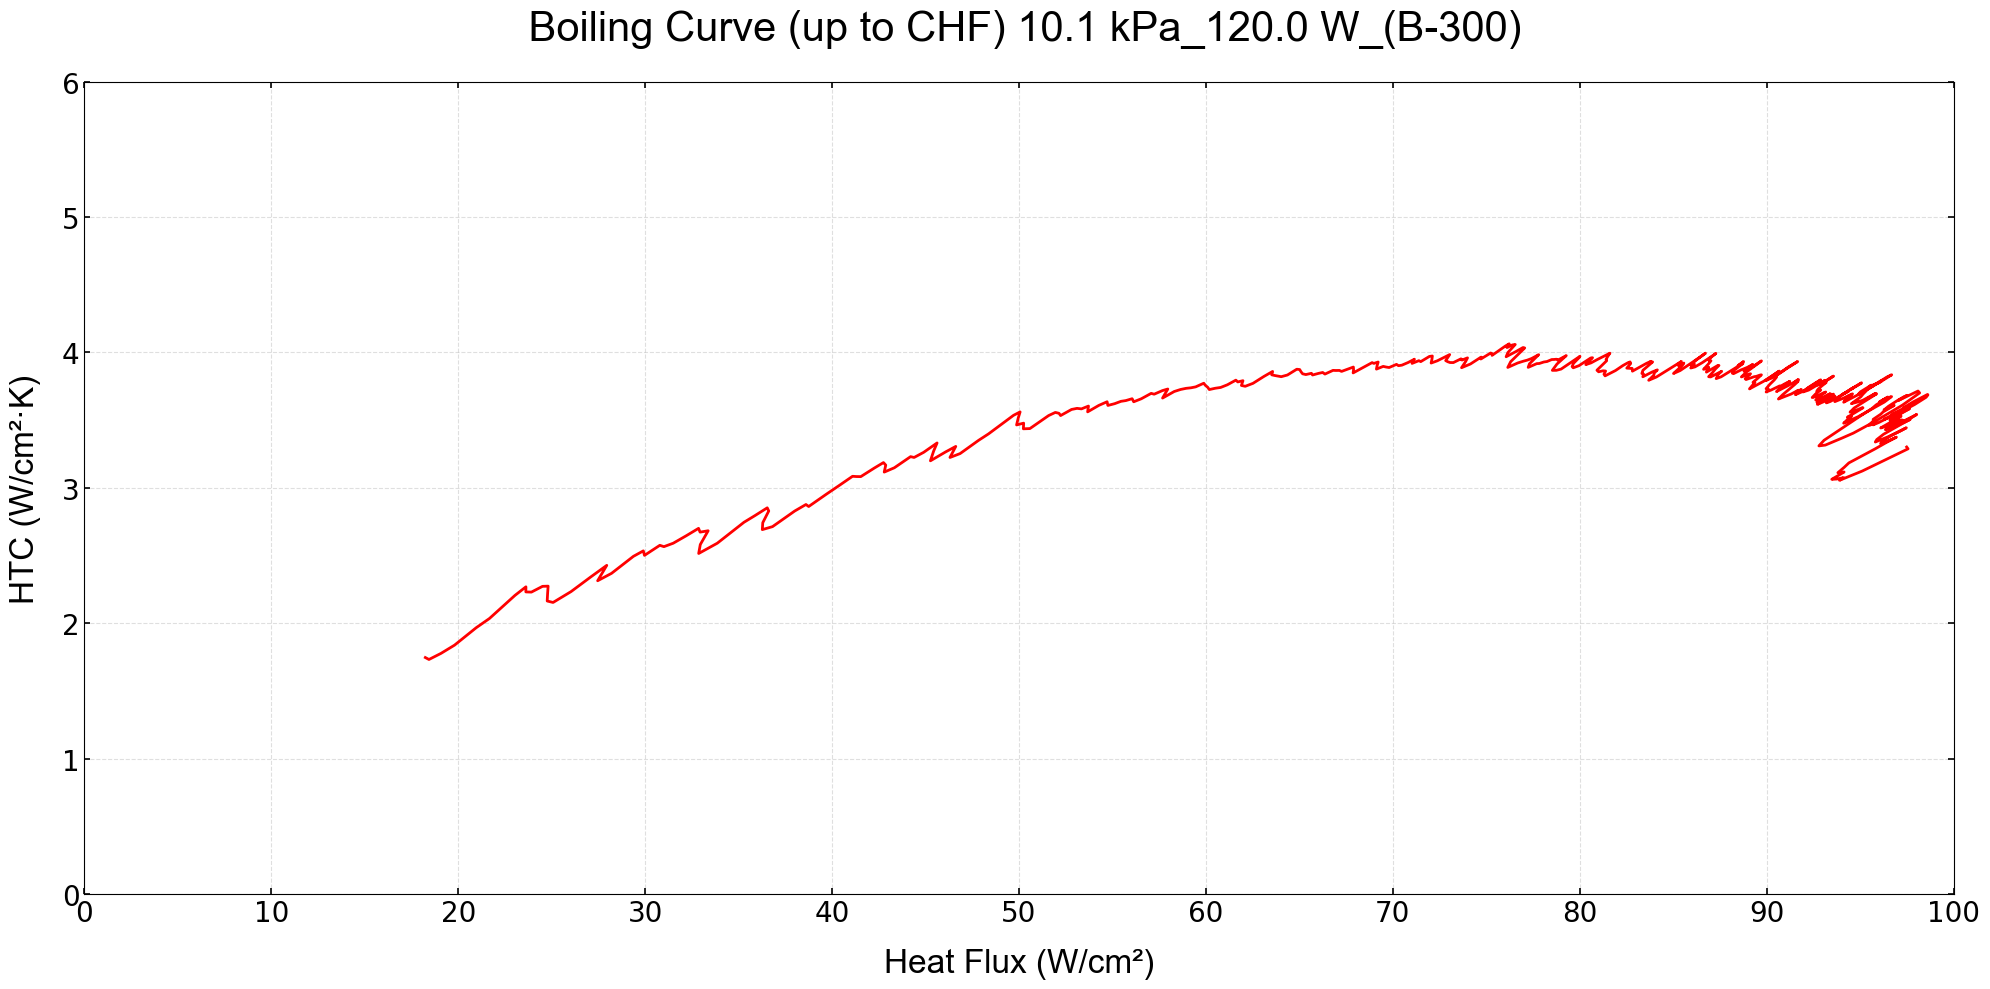

In [724]:
# Slice to window_start → CHF
q_ws_to_CHF   = q[mask_ws_chf]
htc_ws_to_CHF = htc[mask_ws_chf]


htc_MAX_ws_to_CHF = np.nanmax(htc_ws_to_CHF) if htc_ws_to_CHF.size else np.nan
htc_MIN_ws_to_CHF = np.nanmin(htc_ws_to_CHF) if htc_ws_to_CHF.size else np.nan

plt.figure(figsize=(20, 10))
plt.plot(q_ws_to_CHF, htc_ws_to_CHF, color='red', linewidth=2)

#plt.figure(figsize=(20, 10))
#plt.plot(q_cut, htc_cut, color='red', linewidth=2)
plt.xlabel("Heat Flux (W/cm²)", fontsize=24, fontname='Arial', labelpad=15)
plt.ylabel("HTC (W/cm²·K)", fontsize=24, fontname='Arial', labelpad=15)
plt.title(f" Boiling Curve (up to CHF) {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=30, pad=30, fontname='Arial')


ax = plt.gca()

x_step_q_CHF = 10
x_tick_start = x_step_q_CHF * np.floor(ymin_q / x_step_q_CHF)
x_tick_end   = x_step_q_CHF * np.ceil(ymax_q / x_step_q_CHF)
if x_tick_start >= ymin_q:
    x_tick_start -= x_step_q_CHF
if x_tick_end <= ymax_q:
    x_tick_end += x_step_q_CHF

# set new y-limits and ticks
ax.set_xlim(0, x_tick_end)
ax.set_xticks(np.arange(0, x_tick_end +x_step_q_CHF, x_step_q_CHF))

y_tick_start = y_step_htc * np.floor(htc_MIN_ws_to_CHF / y_step_htc)
y_tick_end   = y_step_htc * np.ceil(htc_MAX_ws_to_CHF / y_step_htc)
if y_tick_start >= htc_MIN_ws_to_CHF:
    y_tick_start -= y_step_htc
if y_tick_end <= htc_MAX_ws_to_CHF:
    y_tick_end += y_step_htc

# set new y-limits and ticks
ax.set_ylim(y_tick_start, y_tick_end)
ax.set_yticks(np.arange(y_tick_start-1*y_step_htc, y_tick_end +2*y_step_htc, y_step_htc))

plt.xticks(fontsize=20)  # Increase x-axis tick size
plt.yticks(fontsize=20)  # Increase y-axis tick size

ax.tick_params(axis='both', which='both',direction='in', top=True, right=True,width=1.2, length=4)  

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

# Save figure (use a tuple)
saved_figures.append((f"25_Boiling Curve (up to CHF) {pressure_mean_kPa}kPa B-{boiling_id}", plt.gcf()))

plt.show()


# MagnaDC Power

In [725]:
# --- Fixed names ---
temperature_name = "Temperature.lvm"
dc_name          = "DC_power.lvm"

# --- Build full paths ---
temperature_path = os.path.join(folder_path, temperature_name)
dc_path          = os.path.join(folder_path, dc_name)

# --- Required: Temperature must exist ---
if not os.path.isdir(folder_path):
    print(f"❌ Folder not found: {folder_path}")
else:
    if not os.path.exists(temperature_path):
        print(f"❌ Missing {temperature_name} in {folder_path} (cannot proceed).")
    else:
        print("✅ Found Temperature file:", temperature_path)

# --- Optional: DC_power.lvm ---
has_dc = os.path.exists(dc_path)
if has_dc:
    print("✅ Found DC Power file:", dc_path)
else:
    print("⚠️ DC_power.lvm not found — skipping DC-related steps for this Boiling ID.")

# --- Store only what exists ---
file_paths = {"Temperature": temperature_path}
if has_dc:
    file_paths["MagnaDC"] = dc_path

✅ Found Temperature file: Y:\0_Ishraq\New Pool Boiling Video\Boiling-300\Temperature.lvm
⚠️ DC_power.lvm not found — skipping DC-related steps for this Boiling ID.


In [726]:
# DC (optional) — only if present; skip 21 rows
if has_dc:
    dataframes['MagnaDC'] = pd.read_csv(dc_path, sep='\t', skiprows=21, engine='python')
    df_dc = dataframes['MagnaDC'].copy()
    col_map_dc = {
        df_dc.columns[0]: 'Time (sec)',
        df_dc.columns[1]: 'Set Voltage (V)',
        df_dc.columns[2]: 'Set Current (A)',
        df_dc.columns[3]: 'Output Voltage (V)',
        df_dc.columns[4]: 'Output Current (A)',
        df_dc.columns[5]: 'Output Power (W)'
    }
    df_dc.rename(columns=col_map_dc, inplace=True)
    if 'Comment' in df_dc.columns:
        df_dc.drop(columns=['Comment'], inplace=True)
    if 'Comment' in dataframes['MagnaDC'].columns:
        dataframes['MagnaDC'].drop(columns=['Comment'], inplace=True)

    dataframes['MagnaDC'] = df_dc
    print("✅ Loaded & renamed DC Power.")
else:
    # nothing—continue with temp-only workflow
    pass




In [727]:
with open(temperature_path, 'r', encoding='utf-8', errors='ignore') as f:
    for i, line in enumerate(f, start=1):
        if i == 11:                  # 11th line (1-indexed)
            time_line = line.strip() # e.g., "Time\t14:17:55.9428834249995120136"
            break

# extract the time string after "Time"
# works whether it's separated by tab or spaces
time_token = re.split(r'\s+', time_line, maxsplit=1)[1]

# trim to microseconds (6 digits)
if '.' in time_token:
    hhmmss, frac = time_token.split('.', 1)
    Temperature_time_str = f"{hhmmss}.{frac[:6]}"   # -> "14:17:55.942883"
else:
    Temperature_time_str = time_token               # no fractional part present

# split into components
hh, mm, ss_frac = Temperature_time_str.split(':')
Temperature_hour   = int(hh)                        # 24-hour clock
Temperature_minute = int(mm)
Temperature_second = float(ss_frac)                 # includes fractional part, e.g., 55.942883

print("Start time of Temperature (trimmed to microseconds):", Temperature_time_str)
print("Hour:", Temperature_hour, "| Minute:", Temperature_minute, "| Seconds:", Temperature_second)

Start time of Temperature (trimmed to microseconds): 23:56:44.891424
Hour: 23 | Minute: 56 | Seconds: 44.891424


In [728]:
if has_dc:    
    with open(dc_path, 'r', encoding='utf-8', errors='ignore') as f:
        for i, line in enumerate(f, start=1):
            if i == 11:                  # 11th line (1-indexed)
                time_line = line.strip() # e.g., "Time\t14:17:55.9428834249995120136"
                break

    # extract the time string after "Time"
    # works whether it's separated by tab or spaces
    time_token = re.split(r'\s+', time_line, maxsplit=1)[1]

    # trim to microseconds (6 digits)
    if '.' in time_token:
        hhmmss, frac = time_token.split('.', 1)
        dc_time_str = f"{hhmmss}.{frac[:6]}"   # -> "14:17:55.942883"
    else:
        dc_time_str = time_token               # no fractional part present

    # split into components
    hh, mm, ss_frac = dc_time_str.split(':')
    dc_hour   = int(hh)                        # 24-hour clock
    dc_minute = int(mm)
    dc_second = float(ss_frac)                 # includes fractional part, e.g., 55.942883

    print("Start time of MagnaDC (trimmed to microseconds):", dc_time_str)
    print("Hour:", dc_hour, "| Minute:", dc_minute, "| Seconds:", dc_second)

else:
    print("⏭️ Skipping DC plot: DC_power.lvm not found.")

⏭️ Skipping DC plot: DC_power.lvm not found.


In [729]:
if has_dc:    
    if 'MagnaDC' in dataframes:
        df_dc = dataframes['MagnaDC'].copy()
        col_map = {
            df_dc.columns[0]: 'Time (sec)',
            df_dc.columns[1]: 'Set Voltage (V)',
            df_dc.columns[2]: 'Set Current (A)',
            df_dc.columns[3]: 'Output Voltage (V)',
            df_dc.columns[4]: 'Output Current (A)',
            df_dc.columns[5]: 'Output Power (W)'
        }
        df_dc.rename(columns=col_map, inplace=True)
        dataframes['MagnaDC'] = df_dc
        print("✅ Renamed DC Power columns.")


    for key in ['Temperature', 'MagnaDC']:
        if key in dataframes:
            df = dataframes[key]
            print(f"\n===== {key} : head() =====")
            print(df.head())
            print(f"\n===== {key} : tail() =====")
            print(df.tail())
        else:
            print(f"\n[!] DataFrame '{key}' not found in dataframes.")

    # Extract data from Pressure file
    df_dc = dataframes['MagnaDC']
    time_dc = df_dc['Time (sec)']
    Set_Voltage = df_dc['Set Voltage (V)']
    Set_Current = df_dc['Set Current (A)']
    Output_Voltage = df_dc['Output Voltage (V)']
    Output_Current = df_dc['Output Current (A)']
    Power_Watts = df_dc['Output Power (W)']


else:
    print("⏭️ Skipping DC plot: DC_power.lvm not found.")


⏭️ Skipping DC plot: DC_power.lvm not found.


In [730]:
if has_dc:
    # --- Create the figure & base axis (left y for Power) ---
    fig, ax1 = plt.subplots(figsize=(20, 10))

    # Color palette
    dark_red  = '#8B0000'  # voltage (Output)
    light_red = '#FF6B6B'  # voltage (Set)
    green     = '#2CA02C'  # current (Set)
    dark_green= '#006400'  # current (Output)
    blue      = '#1F77B4'  # power

    # Left y-axis: Power
    p_line,   = ax1.plot(time_dc, Power_Watts, label='Output Power (W)', color=blue, linewidth=2)
    ax1.set_xlabel("Time (seconds)", fontsize=24, fontname='Arial', labelpad=15)
    ax1.set_ylabel("Power (W)", fontsize=24, color=blue, fontname='Arial', labelpad=15)
    ax1.tick_params(axis='y', labelcolor=blue)
    ax1.grid(True, linestyle='--', alpha=0.4)

    # Only bottom x-ticks
    ax1.tick_params(axis='x', which='both',bottom=True, top=False,direction='in', width=1.2, length=4)

    # Only left y-ticks
    ax1.tick_params(axis='y', which='both',left=True, right=False,direction='in', width=1.2, length=4)

    # First right y-axis (Voltage)
    ax2 = ax1.twinx()
    vset_line,   = ax2.plot(time_dc, Set_Voltage,    label='Set Voltage (V)',    color=light_red, linewidth=1)
    vout_line,   = ax2.plot(time_dc, Output_Voltage, label='Output Voltage (V)', color=dark_red,  linewidth=1)
    ax2.set_ylabel("Voltage (V)", fontsize=20, color=dark_red)
    ax2.tick_params(axis='y', labelcolor=dark_red)

    # Second right y-axis (Current), offset outward
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 80))  # push this axis outward
    # for older Matplotlib, also:
    ax3.spines['right'].set_visible(True)

    iset_line,  = ax3.plot(time_dc, Set_Current,    label='Set Current (A)',    color=green,      linewidth=1)
    iout_line,  = ax3.plot(time_dc, Output_Current, label='Output Current (A)', color=dark_green, linewidth=1)
    ax3.set_ylabel("Current (A)", fontsize=20, color=dark_green)
    ax3.tick_params(axis='y', labelcolor=dark_green)

    # Title & ticks
    ax1.set_title(f"MagnaDC Profile of (B-{boiling_id})", fontsize=30, pad=30, fontname='Arial')
    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='y', labelsize=20)

    # Build a single legend from all lines
    lines = [p_line, vset_line, vout_line, iset_line, iout_line]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels,loc='center right',prop={'family': 'Arial', 'size': 20},frameon=True)

    # Add a figure border
    #fig.patch.set_linewidth(2)
    #fig.patch.set_edgecolor('black')

    plt.tight_layout()

    # Save figure (use a tuple)
    saved_figures.append((f"26_MagnaDC Profile {applied_heat_load} W {pressure_mean_kPa} kPa B-{boiling_id}", plt.gcf()))
    plt.show()

else:
    print("⏭️ Skipping DC plot: DC_power.lvm not found.")

⏭️ Skipping DC plot: DC_power.lvm not found.


In [731]:
if has_dc:
    # 1) Compute start-time offset (DC start relative to Temperature start)
    def hms_to_seconds(h, m, s): 
        return h*3600 + m*60 + s

    temp_t0 = hms_to_seconds(Temperature_hour, Temperature_minute, Temperature_second)
    dc_t0   = hms_to_seconds(dc_hour, dc_minute, dc_second)

    offset_s = dc_t0 - temp_t0
    # If runs could cross midnight, optionally handle wrap:
    # if offset_s < -12*3600: offset_s += 24*3600
    # if offset_s >  12*3600: offset_s -= 24*3600

    # 2) Build aligned time axes (relative to Temperature start)
    time_temp = dataframes['Temperature']['Time (sec)'].to_numpy(dtype=float)
    time_dc   = dataframes['MagnaDC']['Time (sec)'].to_numpy(dtype=float) + offset_s
else:
    print("⏭️ Skipping DC plot: DC_power.lvm not found.")

⏭️ Skipping DC plot: DC_power.lvm not found.


#### Surface Temperature & Power Curve

In [732]:
if has_dc:
    ## Create the plot
    fig, ax1 = plt.subplots(figsize=(20, 10))   # ax1 = left y (Temperature)

    # =======================
    # 🔹 Plot Temperatures on LEFT Y
    # =======================
    ax1.plot(time_temp, T1, label='Thermocouple-1', color='black',     linewidth=1)
    ax1.plot(time_temp, T2, label='Thermocouple-2', color='dimgray',   linewidth=1)
    ax1.plot(time_temp, T3, label='Thermocouple-3', color='gray',      linewidth=1)
    ax1.plot(time_temp, T4, label='Thermocouple-4', color='lightgray', linewidth=1)
    surf_line, = ax1.plot(time_temp, Surface_Temperature, label='Surface_Temperature',color='green', linewidth=4, linestyle='--')

    ax1.set_xlabel("Time (seconds)", fontsize=24, fontname ='Arial', labelpad=15)
    ax1.set_ylabel("Temperature (°C)", fontsize=24, fontname ='Arial', labelpad=15)

    # =======================
    # 🔹 Plot Power on RIGHT Y
    # =======================
    ax2 = ax1.twinx()  # ax2 shares x, separate y for Power
    power_line, = ax2.plot(time_dc, Power_Watts, label='Output Power (Watts)',color='red', linewidth=2, linestyle='-')
    ax2.set_ylabel("Power (W)", fontsize=24, color='red', fontname ='Arial', labelpad=15)
    ax2.tick_params(axis='y', labelcolor='red')

    power_min = float(np.nanmin(Power_Watts))
    power_max = float(np.nanmax(Power_Watts))

    y_step_p = 40
    y_tick_start_p = y_step_p * np.floor(power_min / y_step_p)
    y_tick_end_p   = y_step_p * np.ceil(power_max / y_step_p)
    if y_tick_start_p >= power_min:
        y_tick_start_p -= y_step_p
    if y_tick_end_p <= power_max:
        y_tick_end_p += y_step_p

    ax2.set_ylim(y_tick_start_p, y_tick_end_p)
    ax2.set_yticks(np.arange(y_tick_start_p, y_tick_end_p + 30, y_step_p))

    # =======================
    # 🔧 X-axis limits/ticks (cover both time series)
    # =======================
    import numpy as np
    tmin = float(np.nanmin([np.nanmin(time_temp), np.nanmin(time_dc)]))
    tmax = float(np.nanmax([np.nanmax(time_temp), np.nanmax(time_dc)]))

    x_step = 50
    x_tick_start = x_step * np.floor(tmin / x_step)
    x_tick_end   = x_step * np.ceil(tmax / x_step)
    if x_tick_start >= tmin:
        x_tick_start -= 0
    if x_tick_end <= tmax:
        x_tick_end += x_step

    ax1.set_xlim(x_tick_start, x_tick_end)
    ax1.set_xticks(np.arange(x_tick_start, x_tick_end + x_step, x_step))

    # =======================
    # 🔧 LEFT Y ticks from temps (your logic)
    # =======================
    Temp_min_value = np.min([T1.min(), T2.min(), T3.min(), T4.min()])
    Temp_max_value = np.max([T1.max(), T2.max(), T3.max(), T4.max()])

    ymin_raw = float(Temp_min_value)
    ymax_raw = float(Temp_max_value)

    y_step = 20
    y_tick_start = y_step * np.floor(ymin_raw / y_step)
    y_tick_end   = y_step * np.ceil(ymax_raw / y_step)
    if y_tick_start >= ymin_raw:
        y_tick_start -= y_step
    if y_tick_end <= ymax_raw:
        y_tick_end += y_step

    ax1.set_ylim(y_tick_start, y_tick_end)
    ax1.set_yticks(np.arange(y_tick_start, y_tick_end + 30, y_step))

    # (Right Y: let Matplotlib autoscale for power; add custom ticks if you prefer)

    # Title & general ticks
    ax1.set_title(f"Temperature Profile at {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=30, pad=30, fontname ='Arial')
    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)

    # Grid on base axis
    # ax1.grid(True, linestyle='--', alpha=0.4)
    # Grid: x-grid from left axis, y-grid tied to RIGHT y-axis
    ax1.grid(True, axis='x', linestyle='--', alpha=0.4)
    ax2.grid(True, axis='y', linestyle='--', alpha=0.4)

    # Combined legend from both axes
    lines_left  = ax1.get_lines()
    lines_right = [power_line]  # only the power line lives on ax2
    lines_all   = list(lines_left) + lines_right
    labels_all  = [l.get_label() for l in lines_all]
    ax1.legend(lines_all, labels_all, fontsize=16, loc='upper right')

    # Figure border
    #fig.patch.set_linewidth(2)
    #fig.patch.set_edgecolor('black')

    # Inward ticks on all sides for left axis; right handled separately
    ax1.tick_params(axis='both', which='both', direction='in', top=True, right=False, width=1.2, length=4)
    ax2.tick_params(axis='y', which='both', direction='in',left=False, width=1.2, length=4)
    plt.tight_layout()
    
    # Save figure (use a tuple)
    saved_figures.append((f"27_Temperature and MagnaDC {applied_heat_load} W {pressure_mean_kPa} kPa B-{boiling_id}", plt.gcf()))

    plt.show()
else:
    print("⏭️ Skipping DC plot: DC_power.lvm not found.")


⏭️ Skipping DC plot: DC_power.lvm not found.


#### Heat Flux & Power Curve

In [733]:
if has_dc:
    # Heat Flux (left Y) + Output Power (right Y) with shared tick start/end
    fig, ax1 = plt.subplots(figsize=(20, 10))

    # ---- Left Y: Heat Flux ----
    hf_line, = ax1.plot(time_temp, q, label='Heat Flux (W/cm²)', color='blue', linewidth=2)

    # CHF markers/lines
    vline = ax1.axvline(x=chf_time, color='green', linestyle='--', linewidth=3, label=f'CHF Time = {chf_time:.2f}s')
    hline = ax1.axhline(y=chf_value, color='green', linestyle='--', linewidth=3, label=f'CHF = {chf_value:.2f} W/cm²')
    pt    = ax1.scatter(chf_time, chf_value, color='green', s=250, alpha=0.5, label='CHF Point', zorder=5)

    ax1.set_xlabel("Time (s)", fontsize=24,fontname='Arial')
    ax1.set_ylabel("Heat Flux (W/cm²)", fontsize=24, color='blue',fontname='Arial')
    ax1.tick_params(axis='y', labelcolor='blue')

    # ---- Right Y: Output Power ----
    ax2 = ax1.twinx()
    p_line, = ax2.plot(time_dc, Power_Watts, label='Output Power (W)', color='red', linewidth=2)
    ax2.set_ylabel("Power (W)", fontsize=24, color='red',fontname='Arial')
    ax2.tick_params(axis='y', labelcolor='red')

    # ---- X-axis ticks/limits (cover both series) ----
    tmin = float(np.nanmin([np.nanmin(time_temp), np.nanmin(time_dc)]))
    tmax = float(np.nanmax([np.nanmax(time_temp), np.nanmax(time_dc)]))
    x_step = 50
    x_tick_start = x_step * np.floor(tmin / x_step)
    x_tick_end   = x_step * np.ceil(tmax / x_step)
    if x_tick_end <= tmax: x_tick_end += x_step
    ax1.set_xlim(x_tick_start, x_tick_end)
    ax1.set_xticks(np.arange(x_tick_start, x_tick_end + x_step, x_step))

    # ---- Y-axis ticks/limits from the COMBINED range of q and Power_Watts ----
    combined_min = float(np.nanmin([np.nanmin(q), np.nanmin(Power_Watts)]))
    combined_max = float(np.nanmax([np.nanmax(q), np.nanmax(Power_Watts)]))

    y_step = 20  # keep your style; adjust if you want finer/coarser ticks
    y_tick_start = y_step * np.floor(combined_min / y_step)
    y_tick_end   = y_step * np.ceil(combined_max / y_step)
    if y_tick_end <= combined_max: y_tick_end += y_step

    # apply same start/end and ticks to BOTH axes
    yticks = np.arange(y_tick_start, y_tick_end + y_step, y_step)
    ax1.set_ylim(y_tick_start, y_tick_end)
    ax1.set_yticks(yticks)
    ax2.set_ylim(y_tick_start, y_tick_end)
    ax2.set_yticks(yticks)

    # ---- Title, grid, styling ----
    ax1.set_title(f"CHF & Output Power for {pressure_mean_kPa} kPa, {applied_heat_load} W (B-{boiling_id})", fontsize=30, pad=30,fontname='Arial')
    ax1.grid(True, linestyle='--', alpha=0.9)
    ax1.tick_params(axis='x', labelsize=16)
    ax1.tick_params(axis='y', labelsize=16)
    ax2.tick_params(axis='y', labelsize=16)

    ax1.tick_params(axis='both', which='both', direction='in', top=True, right=False, width=1.2, length=4)
    ax2.tick_params(axis='y', which='both', direction='in', left=False,  width=1.2, length=4)

    # ---- Combined legend ----
    lines_left  = [hf_line, vline, hline]
    lines_right = [p_line]
    legend_handles = lines_left + [pt] + lines_right
    legend_labels  = [l.get_label() for l in lines_left] + ['CHF Point'] + [l.get_label() for l in lines_right]
    ax1.legend(legend_handles, legend_labels, fontsize=18, loc='best', frameon=True)

    fig.patch.set_linewidth(2)
    fig.patch.set_edgecolor('black')
    plt.tight_layout()

    # Save figure (use a tuple)
    saved_figures.append((f"28_Heat Flux and MagnaDC {applied_heat_load} W {pressure_mean_kPa} kPa B-{boiling_id}", plt.gcf()))
    
    plt.show()
else:
    print("⏭️ Skipping DC plot: DC_power.lvm not found.")


⏭️ Skipping DC plot: DC_power.lvm not found.


### HTC and Power Output

In [734]:
if has_dc:
    # --- Figure & axes ---
    fig, ax1 = plt.subplots(figsize=(20, 10))   # ax1: LEFT (HTC)

    # ---- LEFT: HTC ----
    ax1.plot(time_temp, htc, color='blue', linewidth=2, label="HTC")

    label_chf = f"HTC at CHF is: {htc_at_chf:.2f} at t = {t_chf_aligned:.2f}s"
    ax1.scatter(t_chf_aligned, htc_at_chf, color='green', s=200, alpha=0.4, zorder=5, label=label_chf)

    label_max1 = f"Max HTC before CHF: {htc_MAX_ws_to_chf:.2f} at t = {time_MAX_ws_to_chf:.2f}s"
    ax1.scatter(time_MAX_ws_to_chf, htc_MAX_ws_to_chf, color='red', s=200, alpha=0.4, zorder=6, label=label_max1)

    label_max2 = f"Max HTC after CHF: {htc_MAX_chf_to_end:.2f} at t = {time_MAX_chf_to_end:.2f}s"
    ax1.scatter(time_MAX_chf_to_end, htc_MAX_chf_to_end, color='orange', s=200, alpha=0.4, zorder=6, label=label_max2)

    ax1.set_xlabel("Time (s)", fontsize=24,fontname='Arial')
    ax1.tick_params(axis='x', labelsize=16)
    ax1.set_ylabel("HTC (W/cm²·K)", fontsize=24, color='blue',fontname='Arial')
    ax1.tick_params(axis='y', labelcolor='blue', labelsize=16)

    # ---- RIGHT: Power (no shared tick range with HTC) ----
    ax2 = ax1.twinx()
    ax2.plot(time_dc, Power_Watts, color='crimson', linewidth=2, label="Output Power (W)")
    ax2.set_ylabel("Power (W)", fontsize=24, color='crimson')
    ax2.tick_params(axis='y', labelcolor='crimson', labelsize=16)

    # Right Y-axis limits & ticks: from -20 to (max power + 20), spaced by 20
    power_min = float(np.nanmin(Power_Watts))
    power_max = float(np.nanmax(Power_Watts))

    y_step_p = 40
    y_tick_start_p = y_step_p * np.floor(power_min / y_step_p)
    y_tick_end_p   = y_step_p * np.ceil(power_max / y_step_p)
    if y_tick_start_p >= power_min:
        y_tick_start_p -= y_step_p
    if y_tick_end_p <= power_max:
        y_tick_end_p += y_step_p

    ax2.set_ylim(y_tick_start_p, y_tick_end_p)
    ax2.set_yticks(np.arange(y_tick_start_p, y_tick_end_p + 30, y_step_p))

    # ---- X-axis ticks/limits (cover both series) ----
    tmin = float(np.nanmin([np.nanmin(time_temp), np.nanmin(time_dc)]))
    tmax = float(np.nanmax([np.nanmax(time_temp), np.nanmax(time_dc)]))
    x_step = 50
    x_tick_start = x_step * np.floor(tmin / x_step)
    x_tick_end   = x_step * np.ceil(tmax / x_step)
    if x_tick_end <= tmax: x_tick_end += x_step

    ax1.set_xlim(x_tick_start, x_tick_end)
    ax1.set_xticks(np.arange(x_tick_start, x_tick_end + x_step, x_step))

    # ---- LEFT Y ticks from HTC only (no sharing with right axis) ----
    y_bottom = int(np.floor(val_min)) - 1
    y_top    = int(np.ceil(val_max)) + 1
    if y_bottom >= y_top:  # guard
        y_bottom -= 1
        y_top    += 1
    ax1.set_ylim(y_bottom, y_top)
    ax1.set_yticks(np.arange(y_bottom, y_top + 1, 1))

    # (Right Y autoscale to power — intentionally NOT shared with left)

    # ---- Title, grid, styling ----
    ax1.set_title(f"HTC & Output Power at {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=30, pad=30,fontname='Arial')
   #ax1.grid(True, linestyle='--', alpha=0.4)
    ax1.grid(True, axis='x', linestyle='--', alpha=0.4)
    ax2.grid(True, axis='y', linestyle='--', alpha=0.4)
    ax1.tick_params(axis='both', which='both', direction='in', top=True, right=False, width=1.2, length=4)
    ax2.tick_params(axis='y', which='both', direction='in', left=False, width=1.2, length=4)

    # ---- Combined legend (HTC + markers + Power) ----
    lines_left  = ax1.get_lines()          # HTC line is here
    lines_right = ax2.get_lines()          # Power line
    # add the scatter handles explicitly (last 2 scatters are not in lines)
    handles = list(lines_left) + [ax1.collections[0], ax1.collections[1], ax1.collections[2]] + list(lines_right)
    labels  = [h.get_label() for h in handles]
    ax1.legend(handles, labels, fontsize=20, loc='upper right', frameon=True)

    plt.tight_layout()
    # Save figure (use a tuple)
    saved_figures.append((f"29_HTC and MagnaDC {applied_heat_load} W {pressure_mean_kPa} kPa B-{boiling_id}", plt.gcf()))
    plt.show()
else:
    print("⏭️ Skipping DC plot: DC_power.lvm not found.")


⏭️ Skipping DC plot: DC_power.lvm not found.


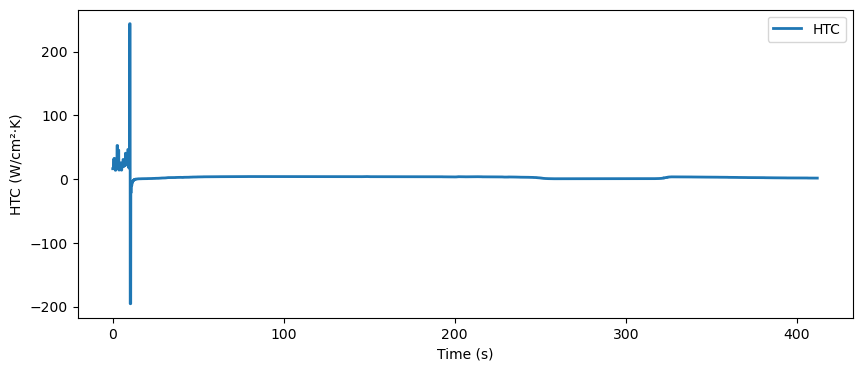

In [735]:
plt.figure(figsize=(10,4))
plt.plot(time_temp, htc, label='HTC', linewidth=2)
plt.xlabel('Time (s)'); plt.ylabel('HTC (W/cm²·K)'); plt.legend()
plt.show()

In [736]:
if has_dc:
    fig, ax1 = plt.subplots(figsize=(20,10))

    # --- 🔴 Left Y-axis: Heat Flux (+ Power on same axis) ---
    ax1.set_xlabel('Time (s)', fontsize=24, fontname='Arial')
    ax1.set_ylabel('Heat Flux (W/cm²)', color='red', fontsize=24, fontname='Arial')
    l1, = ax1.plot(time_temp, q, color='red', label='Heat Flux', linewidth=2)

    # ✅ Add Output Power on the SAME (left) Y-axis
    #    (If DC is optional in your run, this block will auto-skip if `has_dc` is False)
    if 'has_dc' not in globals() or has_dc:
        l4, = ax1.plot(time_dc, Power_Watts, color='orange', linewidth=2, label='Output Power (W)')
    else:
        l4 = None  # for legend assembly later

    ax1.tick_params(axis='x', labelcolor='black', labelsize=16)
    ax1.tick_params(axis='y', labelcolor='red', labelsize=16)

    # CHF time line on shared x
    ax1.axvline(x=chf_time, color='teal', linestyle='--', linewidth=2, alpha=0.2, label='CHF Time')
    
    # Only bottom x-ticks
    ax1.tick_params(axis='x', which='both',bottom=True, top=False,direction='in', width=1.2, length=4)
    # Only left y-ticks
    ax1.tick_params(axis='y', which='both',left=True, right=False,direction='in', width=1.2, length=4)

    ax1.set_xlim(0, 600)






    # --- 🔵 Second Y-axis (right): HTC ---
    ax2 = ax1.twinx()
    ax2.set_ylabel('HTC (W/cm²·K)', color='blue', fontsize=24, fontname='Arial')
    l2, = ax2.plot(time_temp, htc, color='blue', label='HTC', linewidth=2)
    ax2.tick_params(axis='y', labelcolor='blue', labelsize=16)
    ax2.tick_params(axis='y', which='both', direction='in', left=False, right=True, width=1.2)

    # Center/limit HTC axis
    ax2.set_ylim(y_bottom, y_top)
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

    # --- 🟢 Third Y-axis (right): Surface Temperature ---
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 70))
    ax3.set_ylabel('Surface Temperature (°C)', color='green', fontsize=24, fontname='Arial')
    l3, = ax3.plot(time_temp, Surface_Temperature, color='green', label='Surface Temperature', linewidth=2)
    ax3.tick_params(axis='y', labelcolor='green', labelsize=16)
    ax3.tick_params(axis='y', which='both', direction='in', left=False, right=True, width=1.2, length=4)

    # ---- X-axis limits & ticks (25 s grid) ----
    tmin = float(np.nanmin(time_temp))
    tmax = float(np.nanmax(time_temp))
    
    
    x_step = 50
    x_tick_start = x_step * np.floor(tmin / x_step)
    x_tick_end   = x_step * np.ceil(tmax  / x_step)
    if x_tick_end <= tmax:
        x_tick_end += x_step
    ax1.set_xlim(x_tick_start, x_tick_end)
    ax1.set_xticks(np.arange(x_tick_start, x_tick_end + x_step, x_step))

    # ---- LEFT Y ticks/limits must cover BOTH Heat Flux and Power ----
    if 'has_dc' not in globals() or has_dc:
        combined_min = float(np.nanmin([np.nanmin(q), np.nanmin(Power_Watts)]))
        combined_max = float(np.nanmax([np.nanmax(q), np.nanmax(Power_Watts)]))
    else:
        combined_min = float(np.nanmin(q))
        combined_max = float(np.nanmax(q))

    y_step = 20
    y_tick_start = y_step * np.floor(combined_min / y_step)
    y_tick_end   = y_step * np.ceil( combined_max / y_step)
    if y_tick_end <= combined_max:
        y_tick_end += y_step

    ax1.set_ylim(y_tick_start, y_tick_end)
    ax1.set_yticks(np.arange(y_tick_start, y_tick_end + y_step, y_step))

    ## y-axis ticks ##
    y_tick_start = y_step_htc * np.floor(htc_MIN_ws_to_end / y_step_htc)
    y_tick_end   = y_step_htc * np.ceil(htc_MAX_ws_to_end / y_step_htc)
    if y_tick_start >= htc_MIN_ws_to_end:
        y_tick_start -= y_step_htc
    if y_tick_end <= htc_MAX_ws_to_end:
        y_tick_end += y_step_htc

    
    # set new y-limits and ticks
    ax2.set_ylim(y_tick_start-y_step_htc, y_tick_end)
    ax2.set_yticks(np.arange(y_tick_start-2*y_step_htc, y_tick_end +2*y_step_htc, y_step_htc))

    # ---- Surface Temperature (ax3) ticks/limits ----
    st_min = float(np.nanmin(Surface_Temperature))
    st_max = float(np.nanmax(Surface_Temperature))
    st_step = 20
    st_tick_start = st_step * np.floor(st_min / st_step)
    st_tick_end   = st_step * np.ceil( st_max / st_step)
    if st_tick_end <= st_max:
        st_tick_end += st_step
    ax3.set_ylim(st_tick_start, st_tick_end)
    ax3.set_yticks(np.arange(st_tick_start, st_tick_end + st_step, st_step))
  
    #ax1.set_xlim(0, 600)
    # Title, grid
    plt.title(f"Comparison_{pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=28, pad=30, fontname='Arial')
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Legend (include power only if present)
    lines = [l for l in [l1, l2, l3, l4] if l is not None]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper right', fontsize=20)

    plt.tight_layout()
    # Save figure (use a tuple)
    saved_figures.append((f"30_Comparison and MagnaDC {applied_heat_load} W {pressure_mean_kPa} kPa B-{boiling_id}", plt.gcf()))
    plt.show()
else:
    print("⏭️ Skipping DC plot: DC_power.lvm not found.")

⏭️ Skipping DC plot: DC_power.lvm not found.


In [737]:
if has_dc:
    # --- Combined Plot: Temperatures + Heat Flux + Surface Temperature ---
    fig, ax1 = plt.subplots(figsize=(20, 10))

    # ---------------------------
    # 🔴 Left Y-axis: Temperatures
    # ---------------------------
    ax1.plot(time_temp, T1, label='Thermocouple-1', color='red', alpha=0.6, linewidth=1.5)
    ax1.plot(time_temp, T2, label='Thermocouple-2', color='orange', alpha=0.6, linewidth=1.5)
    ax1.plot(time_temp, T3, label='Thermocouple-3', color='green', alpha=0.6, linewidth=1.5)
    ax1.plot(time_temp, T4, label='Thermocouple-4', color='blue', alpha=0.6, linewidth=1.5)

    # Temperature axis limits
    Temp_min_value = np.min([T1.min(), T2.min(), T3.min(), T4.min()])
    Temp_max_value = np.max([T1.max(), T2.max(), T3.max(), T4.max()])
    # ax1.set_xlim(time_temp.min(), time_temp.min() + 40)

    a = 10
    b = 30
    ax1.set_xlim(a, b)
    ax1.set_ylim(Temp_min_value - 0.2, Temp_min_value + 12)   # Temperature y-limit

    # Labels
    ax1.set_xlabel("Time (s)", fontsize=22)
    ax1.set_ylabel("Temperature (°C)", fontsize=22, color='black')
    ax1.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)

    ax1.tick_params(axis='x', which='both',
                    bottom=True, top=False,
                    direction='in', width=1.2, length=4, labelsize=14)

    # Only left y-ticks
    ax1.tick_params(axis='y', which='both',
                    left=True, right=False,
                    direction='in', width=1.2, length=4, labelsize=14)
    # ---------------------------
    # 🔵 Right Y-axis #1: Heat Flux
    # ---------------------------
    ax2 = ax1.twinx()
    ax2.plot(time_temp, q, color='magenta', linewidth=8, linestyle='--', alpha=0.3, label="Heat Flux")
    # Add MagnaDC Power on the SAME right axis as Heat Flux
    ax2.plot(time_dc, Power_Watts, color='teal', linewidth=3, alpha=0.9, label='Output Power (W)')

    # Heat Flux axis limits (independent!)
    q_min = np.min(q)
    q_max = np.max(q)
    # ax2.set_ylim(q_min - 5, q_min + 10)   # Heat flux y-limit
    ax2.set_ylim(-5, 10)   # Heat flux y-limit

    ax2.set_ylabel("Heat Flux (W/cm²)", fontsize=22, color='magenta')
    ax2.tick_params(axis='y', labelcolor='magenta', labelsize=14)

    ax2.tick_params(axis='y', which='both',left=False, right=True,direction='in', width=1.2, length=4)

    # ---------------------------
    # 🟣 Right Y-axis #2 (offset): Surface Temperature
    # ---------------------------
    ax3 = ax1.twinx()  # create a second right-side axis
    ax3.spines["right"].set_position(("axes", 1.08))  # offset to avoid overlap with ax2
    ax3.spines["right"].set_visible(True)

    # Plot Surface Temperature (adjust name if your variable differs)
    # Example variable name: Surface_Temperature
    Surf_min = np.nanmin(Surface_Temperature)
    Surf_max = np.nanmax(Surface_Temperature)
    ax3.plot(time_temp, Surface_Temperature, color='darkgreen', linewidth=8, alpha=0.4, label="Surface Temperature")

    # Independent y-lim for surface temp
    #ax3.set_ylim(Surf_min - 0.2, Surf_min + 15)
    ax3.set_ylim(Temp_min_value - 0.2, Temp_min_value + 10)

    ax3.set_ylabel("Surface Temp (°C)", fontsize=22, color='black')
    ax3.tick_params(axis='y', labelcolor='black', labelsize=14)

    # ---------------------------
    # Legends (combine from all three axes)
    # ---------------------------
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, fontsize=16, loc='upper left')

    # Title & Grid
    plt.title(f"Temperature & Heat Flux vs Time at {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})", fontsize=26, pad=30)
    ax1.grid(True, linestyle='--', alpha=0.4)

    # Save figure (use a tuple)
    #saved_figures.append((f"3_Heat Flux check_{pressure_mean_kPa}kPa_B-{boiling_id}", plt.gcf()))
    # Save figure (use a tuple)
    saved_figures.append((f"31_Power Load Start {applied_heat_load} W {pressure_mean_kPa} kPa B-{boiling_id}", plt.gcf()))
    plt.show()
else:
    print("⏭️ Skipping DC plot: DC_power.lvm not found.")

⏭️ Skipping DC plot: DC_power.lvm not found.


In [738]:
saved_figures

[('1_Temperature_Profile_10.1kPa_B-300', <Figure size 2000x1000 with 1 Axes>),
 ('2_Heat Flux check_10.1kPa_B-300', <Figure size 2000x1000 with 3 Axes>),
 ('3_Surface Temperature_10.1kPa_B-300', <Figure size 2000x1000 with 1 Axes>),
 ('4_Temperature Gradient_10.1kPa_B-300', <Figure size 2000x600 with 1 Axes>),
 ('5_Heat Flux VS Time_10.1kPa_B-300', <Figure size 2000x1000 with 1 Axes>),
 ('6_CHF Point_10.1kPa_B-300', <Figure size 2000x1000 with 1 Axes>),
 ('6_Boiling Regimes 4_10.1kPa_B-300', <Figure size 2000x1000 with 1 Axes>),
 ('6_CHF Point_10.1kPa_B-300', <Figure size 2000x1000 with 1 Axes>),
 ('6_CHF Point_10.1kPa_B-300', <Figure size 2000x1000 with 1 Axes>),
 ('6_Boiling Regimes 4_10.1kPa_B-300', <Figure size 2000x1000 with 1 Axes>),
 ('7_HTC VS Time_10.1kPa_B-300', <Figure size 2000x1000 with 1 Axes>),
 ('8_Comparison_10.1kPa_B-300', <Figure size 2000x1000 with 3 Axes>),
 ('9_Pressure Control_10.1kPa_B-300', <Figure size 2000x1000 with 1 Axes>),
 ('10_Sat Temp_10.1kPa B-300', <F

In [739]:
from IPython.display import display, Markdown

# Build summary text with bigger font and spacing
summary_text = f"""
<style>
.summary-text {{
    font-size: 18px;        /* increase font size */
    line-height: 1.8;       /* increase spacing between lines */
}}
</style>

<div class="summary-text">

### 🔹 Experiment Summary (Boiling-{boiling_id})

- **Target Pressure (kPa):** {Target_pressure_kPa:.2f}  
- **Mean Pressure (kPa):** {pressure_mean_kPa:.2f}  
- **Standard Deviation (σ):** {std_val:.3f}  
- **Root Mean Square Error (RMSE):** {rmse_val:.3f}  
- **Saturation Temperature (°C):** {T_sat:.3f}  
- **CHF Value:** {chf_value:.2f}  
- **CHF Time Value:** {chf_time:.2f}  
- **HTC Value at CHF:** {htc_at_chf:.3f}  
- **Max HTC Value:** {htc_MAX_ws_to_chf:.3f}  

</div>
"""

# Display it nicely
display(Markdown(summary_text))

# Auto-scroll to bottom
js_scroll = """
<script>
window.scrollTo(0, document.body.scrollHeight);
</script>
"""
display(Markdown(js_scroll))



<style>
.summary-text {
    font-size: 18px;        /* increase font size */
    line-height: 1.8;       /* increase spacing between lines */
}
</style>

<div class="summary-text">

### 🔹 Experiment Summary (Boiling-300)

- **Target Pressure (kPa):** 10.00  
- **Mean Pressure (kPa):** 10.10  
- **Standard Deviation (σ):** 0.119  
- **Root Mean Square Error (RMSE):** 0.159  
- **Saturation Temperature (°C):** 46.002  
- **CHF Value:** 97.49  
- **CHF Time Value:** 231.84  
- **HTC Value at CHF:** 3.302  
- **Max HTC Value:** 4.064  

</div>



<script>
window.scrollTo(0, document.body.scrollHeight);
</script>


In [740]:
raise Exception

Exception: 

In [ ]:
# Collect into dictionary (replace with your actual variable names)
data_dict = {
    "Time_Pressure (seconds)": time_press, 
    "Pressure (kPa)": pressure, 
    "Target Pressure_value (kPa)": Target_pressure_kPa,
    "Mean Pressure_value (kPa)": pressure_mean_kPa,
    "Saturation Temperature_value (degC)": T_sat,
    "Time_Thermocouple (seconds)": time_temp,
    "Thermo-couple_1 (degC)": T1, 
    "Thermo-couple_2 (degC)": T2, 
    "Thermo-couple_3 (degC)": T3,
    "Thermo-couple_4 (degC)": T4,
    "Vapour Temp (degC)": T_vapour, 
    "Liquid Temp (degC)": T_liquid, 
    "Surface Temperature (degC)": Surface_Temperature,
    "Heat Flux (W/cm^2)": q, 
    "HTC (W/cm^2.K)": htc, 
    "Wall Superheat (degC)": delta_T,
    "Surface Temperature_cut (degC)": T_surface_cut,
    "Heat Flux_cut (W/cm^2)": q_cut, 
    "HTC_cut (W/cm^2.K)": htc_cut, 
    "Wall Superheat_cut (degC)": delta_T_cut,
    "CHF_value": chf_value , 
    "CHF_Time_value": chf_time , 
    "HTC_value": htc_at_chf 
}

# Convert to DataFrame (handles arrays + scalars correctly)
df = pd.DataFrame({k: pd.Series(v) for k, v in data_dict.items()})

# Build file name and path
csv_name = f"Boiling-{boiling_id}_csv_data.csv"
csv_path = os.path.join(folder_path, csv_name)

# Save to CSV (no row limit, no bold formatting possible in CSV)
df.to_csv(csv_path, index=False)

print(f"✅ Full dataset saved to CSV: {csv_path}")

✅ Full dataset saved to CSV: Y:\0_Ishraq\New Pool Boiling Video\Boiling-317\Boiling-317_csv_data.csv


In [ ]:
raise Exception

Exception: 

: 

: 

: 

: 

In [ ]:
# Define the subfolder for plots
plots_folder = os.path.join(folder_path, "Plot Images")
os.makedirs(plots_folder, exist_ok=True)  # Create folder if it doesn't exist

# Save all queued figures as high-quality PNGs
for name, fig in saved_figures:
    filename = os.path.join(plots_folder, f"{_safe(name)}.png")
    fig.savefig(filename, dpi=300, bbox_inches='tight')
    print("✅ Saved:", filename)

✅ Saved: Y:\0_Ishraq\New Pool Boiling Video\Boiling-317\Plot Images\1_Temperature_Profile_98.08kPa_B-317.png
✅ Saved: Y:\0_Ishraq\New Pool Boiling Video\Boiling-317\Plot Images\2_Heat_Flux_check_98.08kPa_B-317.png
✅ Saved: Y:\0_Ishraq\New Pool Boiling Video\Boiling-317\Plot Images\3_Surface_Temperature_98.08kPa_B-317.png
✅ Saved: Y:\0_Ishraq\New Pool Boiling Video\Boiling-317\Plot Images\4_Temperature_Gradient_98.08kPa_B-317.png
✅ Saved: Y:\0_Ishraq\New Pool Boiling Video\Boiling-317\Plot Images\5_Heat_Flux_VS_Time_98.08kPa_B-317.png
✅ Saved: Y:\0_Ishraq\New Pool Boiling Video\Boiling-317\Plot Images\6_CHF_Point_98.08kPa_B-317.png
✅ Saved: Y:\0_Ishraq\New Pool Boiling Video\Boiling-317\Plot Images\6_Boiling_Regimes_4_98.08kPa_B-317.png
✅ Saved: Y:\0_Ishraq\New Pool Boiling Video\Boiling-317\Plot Images\7_HTC_VS_Time_98.08kPa_B-317.png
✅ Saved: Y:\0_Ishraq\New Pool Boiling Video\Boiling-317\Plot Images\8_Comparison_98.08kPa_B-317.png
✅ Saved: Y:\0_Ishraq\New Pool Boiling Video\Boiling-3

In [ ]:
raise Exception

# Animation Videos

#### Temperature Profile with Surface Temperature

In [ ]:
#**************************************************************************        Temperature Profile with Surface Temperature        ************************************************************************************

# ---------------- Settings you can adjust ----------------
out_fps  = 30        # final video frame rate
speedup  = 5.0       # playback speedup (e.g., 4x faster than real time)
dpi_out  = 120       # lower = faster render/smaller file
bitrate  = 1000      # kbps target (adjust as needed)

# Save path (uses your folder_path if defined, else current dir)
try:
    out_base = os.path.join(folder_path, f"03_Surface_Temperature_anim_{pressure_mean_kPa}kPa_B-{boiling_id}")
    os.makedirs(folder_path, exist_ok=True)
except NameError:
    out_base = f"03_Surface_Temperature_anim_{pressure_mean_kPa}kPa_B-{boiling_id}"

# ---------------- Data as numpy (for fast masking) ----------------
t  = np.asarray(time_temp, dtype=float)
T1 = np.asarray(T1, dtype=float)
T2 = np.asarray(T2, dtype=float)
T3 = np.asarray(T3, dtype=float)
T4 = np.asarray(T4, dtype=float)
Ts = np.asarray(Surface_Temperature, dtype=float)

tmin = float(np.nanmin(t))
tmax = float(np.nanmax(t))

# ---------------- Figure (same look as your static plot) ----------------
fig, ax = plt.subplots(figsize=(20, 10))

# Pre-create empty lines with your styles
ln1, = ax.plot([], [], label='Thermocouple-1', color='red',    alpha=0.6, linewidth=1.5)
ln2, = ax.plot([], [], label='Thermocouple-2', color='orange', alpha=0.6, linewidth=1.5)
ln3, = ax.plot([], [], label='Thermocouple-3', color='green',  alpha=0.6, linewidth=1.5)
ln4, = ax.plot([], [], label='Thermocouple-4', color='blue',   alpha=0.6, linewidth=1.5)
lnS, = ax.plot([], [], label='Surface_Temperature', color='violet', linewidth=5, linestyle='--')

# Axes labels/title (same as yours)
ax.set_xlabel("Time (seconds)", fontsize=24, fontname='Arial', labelpad=15)
ax.set_ylabel("Temperature (°C)", fontsize=24, fontname='Arial', labelpad=15)
ax.set_title(f"Temperature Profile at {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})",
             fontsize=30, pad=30, fontname='Arial')

# ---- X ticks/limits (your logic) ----
x_tick_start = x_step_time * np.floor(tmin / x_step_time)
x_tick_end   = x_step_time * np.ceil (tmax / x_step_time)
if x_tick_start >= tmin:
    x_tick_start -= 0
if x_tick_end <= tmax:
    x_tick_end += x_step_time
ax.set_xlim(x_tick_start, x_tick_end)
ax.set_xticks(np.arange(x_tick_start, x_tick_end + x_step_time, x_step_time))

# ---- Y ticks/limits (your logic) ----
y_tick_start = y_step_temp * np.floor(ymin_Temp / y_step_temp)
y_tick_end   = y_step_temp * np.ceil (ymax_Temp / y_step_temp)
if y_tick_start >= ymin_Temp:
    y_tick_start -= y_step_temp
if y_tick_end <= ymax_Temp:
    y_tick_end += y_step_temp
ax.set_ylim(y_tick_start, y_tick_end)
ax.set_yticks(np.arange(y_tick_start - y_step_temp, y_tick_end + 2*y_step_temp, y_step_temp))

# Grid, legend, ticks (same as yours)
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.4)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, width=1.2, length=4)
ax.legend(prop={'family':'Arial','size':20}, loc='upper right')

# ---------------- Animation frames (speed-controlled) ----------------
real_duration = float(tmax - tmin)
video_duration = max(1e-9, real_duration / speedup)
frames = max(10, int(out_fps * video_duration))
frame_times = np.linspace(tmin, tmax, frames)

def _subset(t_cut):
    m = (t <= t_cut)
    return t[m], T1[m], T2[m], T3[m], T4[m], Ts[m]

def _init():
    ln1.set_data([], []); ln2.set_data([], [])
    ln3.set_data([], []); ln4.set_data([], [])
    lnS.set_data([], [])
    return ln1, ln2, ln3, ln4, lnS

def _update(i):
    t_cut = frame_times[i]
    tt, a, b, c, d, s = _subset(t_cut)
    ln1.set_data(tt, a); ln2.set_data(tt, b)
    ln3.set_data(tt, c); ln4.set_data(tt, d)
    lnS.set_data(tt, s)
    return ln1, ln2, ln3, ln4, lnS

ani = FuncAnimation(fig, _update, init_func=_init,
                    frames=frames, interval=1000.0/out_fps, blit=False)

# ---------------- Save (MP4 if possible, else GIF) ----------------
mp4_path = out_base + ".mp4"
try:
    writer = FFMpegWriter(fps=out_fps, bitrate=bitrate,
                          extra_args=['-preset','ultrafast','-crf','28'])
    ani.save(mp4_path, writer=writer, dpi=dpi_out)
    print("Saved MP4:", mp4_path)
except Exception as e:
    print("MP4 save failed, saving GIF instead:", e)
    gif_path = out_base + ".gif"
    ani.save(gif_path, writer=PillowWriter(fps=min(out_fps, 20)), dpi=dpi_out)
    print("Saved GIF:", gif_path)

plt.close(fig)

#### Heat Flux VS Time

In [ ]:
#**************************************************************************          Heat Flux vs Time        ************************************************************************************

# ensure ffmpeg is found
mpl.rcParams['animation.ffmpeg_path'] = imageio_ffmpeg.get_ffmpeg_exe()

# ------------------- USER SPEED/OUTPUT SETTINGS -------------------
out_fps  = 15          # video frame rate
speedup  = 5.0         # 5x faster than real time (change as you like)
out_base = os.path.join(
    folder_path,  # you already set base_dir/folder_path
    f"06_Boiling_Regimes_animated_{pressure_mean_kPa}kPa_B-{boiling_id}"
)
os.makedirs(folder_path, exist_ok=True)

# ------------------- Key instants/values -------------------
t_chf  = float(chf_time)
t_tmax = float(time_at_max_Surface_Temperature)
t_nbr  = float(nbr_time)
q_chf  = float(chf_value)
q_nbr  = float(nbr_value)

# ------------------- Four time-regime masks -------------------
m_nb1 = (time_temp <= t_chf)                              # NB: t ≤ t_CHF
m_tb1 = (time_temp >  t_chf) & (time_temp <= t_tmax)      # TB: t_CHF < t ≤ t_Tmax
m_tb2 = (time_temp >  t_tmax) & (time_temp <= t_nbr)      # TB: t_Tmax < t ≤ t_NBR
m_nb2 = (time_temp >  t_nbr)                              # NB: t > t_NBR

# ------------------- Figure & static styling -------------------
fig, ax = plt.subplots(figsize=(20, 10))

line_nb1, = ax.plot([], [], linestyle='-',  marker='s', markersize=6, linewidth=1, alpha=0.5,
                    color='orange', label=r'Nucleate Boiling: $t \leq t_{\mathrm{CHF}}$')
line_tb1, = ax.plot([], [], linestyle='--', marker='^', markersize=6, linewidth=1, alpha=0.5,
                    color='red',    label=r'Transient Boiling: $t_{\mathrm{CHF}} < t \leq t_{\mathrm{Tmax}}$')
line_tb2, = ax.plot([], [], linestyle='-',  marker='o', markersize=6, linewidth=1, alpha=0.5,
                    color='green',  label=r'Transient Boiling: $t_{\mathrm{Tmax}} < t \leq t_{\mathrm{NBR}}$')
line_nb2, = ax.plot([], [], linestyle='-',  marker='x', markersize=6, linewidth=1, alpha=0.5,
                    color='blue',   label=r'Nucleate Boiling: $t > t_{\mathrm{NBR}}$')

ax.set_xlabel("Time (s)", fontsize=24, fontname='Arial', labelpad=15)
ax.set_ylabel("Heat Flux (W/cm²)", fontsize=24, fontname='Arial', labelpad=15)
ax.set_title(f"Heat Flux vs Time with Regimes — {pressure_mean_kPa} kPa, {applied_heat_load} W (B-{boiling_id})",
             fontsize=30, pad=30, fontname='Arial')
ax.grid(True, linestyle='--', alpha=0.4)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, width=1.2, length=4)
plt.xticks(fontsize=16); plt.yticks(fontsize=16)

# ------------------- Ticks/limits (your logic) -------------------
tmin = float(np.nanmin(time_temp))
tmax = float(np.nanmax(time_temp))

x_tick_start = x_step_time * np.floor(tmin / x_step_time)
x_tick_end   = x_step_time * np.ceil (tmax / x_step_time)
if x_tick_end <= tmax:
    x_tick_end += x_step_time
ax.set_xlim(x_tick_start, x_tick_end)
ax.set_xticks(np.arange(x_tick_start, x_tick_end + x_step_time, x_step_time))

y_tick_start = y_step_q * np.floor(ymin_q / y_step_q)
y_tick_end   = y_step_q * np.ceil (ymax_q / y_step_q)
if y_tick_start >= ymin_q:
    y_tick_start -= y_step_q
if y_tick_end <= ymax_q:
    y_tick_end += y_step_q
ax.set_ylim(y_tick_start, y_tick_end)
ax.set_yticks(np.arange(y_tick_start - y_step_q, y_tick_end + 2*y_step_q, y_step_q))

# ---------- Labels for q'' values (keep, but NO horizontal lines) ----------
xmin, xmax = ax.get_xlim()
xpos = lambda frac: xmin + frac * (xmax - xmin)
ax.text(xpos(0.30), q_chf + 2, r"$q^{\prime\prime}_{\mathrm{CHF}}$", fontsize=20, ha='left', va='bottom')
ax.text(xpos(0.70), q_nbr + 2, r"$q^{\prime\prime}_{\mathrm{NBR}}$", fontsize=20, ha='left', va='bottom')


plt.legend(prop={'family':'Arial','size':20}, loc='upper right')

# ------------------- Animation data -------------------
# Duration control: final video length = (tmax - tmin)/speedup
real_duration  = float(tmax - tmin)
video_duration = real_duration / speedup
frames         = max(10, int(out_fps * video_duration))
frame_times    = np.linspace(tmin, tmax, frames)

def _subset(mask, t_cut):
    m = mask & (time_temp <= t_cut)
    return time_temp[m], q[m]  # x = time, y = q

def _init():
    for ln in (line_nb1, line_tb1, line_tb2, line_nb2):
        ln.set_data([], [])
    return line_nb1, line_tb1, line_tb2, line_nb2

def _update(i):
    t_cut = frame_times[i]
    line_nb1.set_data(*_subset(m_nb1, t_cut))
    line_tb1.set_data(*_subset(m_tb1, t_cut))
    line_tb2.set_data(*_subset(m_tb2, t_cut))
    line_nb2.set_data(*_subset(m_nb2, t_cut))
    return line_nb1, line_tb1, line_tb2, line_nb2

ani = FuncAnimation(fig, _update, init_func=_init,
                    frames=frames, interval=1000.0/out_fps, blit=False)

# ------------------- Save as MP4 -------------------
writer = FFMpegWriter(fps=out_fps, bitrate=1000,
                      extra_args=['-preset','ultrafast','-crf','28'])
mp4_path = out_base + ".mp4"
ani.save(mp4_path, writer=writer, dpi=80)
print("Saved MP4:", mp4_path)

#### Heat Flux VS Wall Superheat

Saved MP4: Y:\0_Ishraq\New Pool Boiling Video\Boiling-300\14_HeatFlux_vs_WallSuperheat_animated_10.1kPa_B-300.mp4


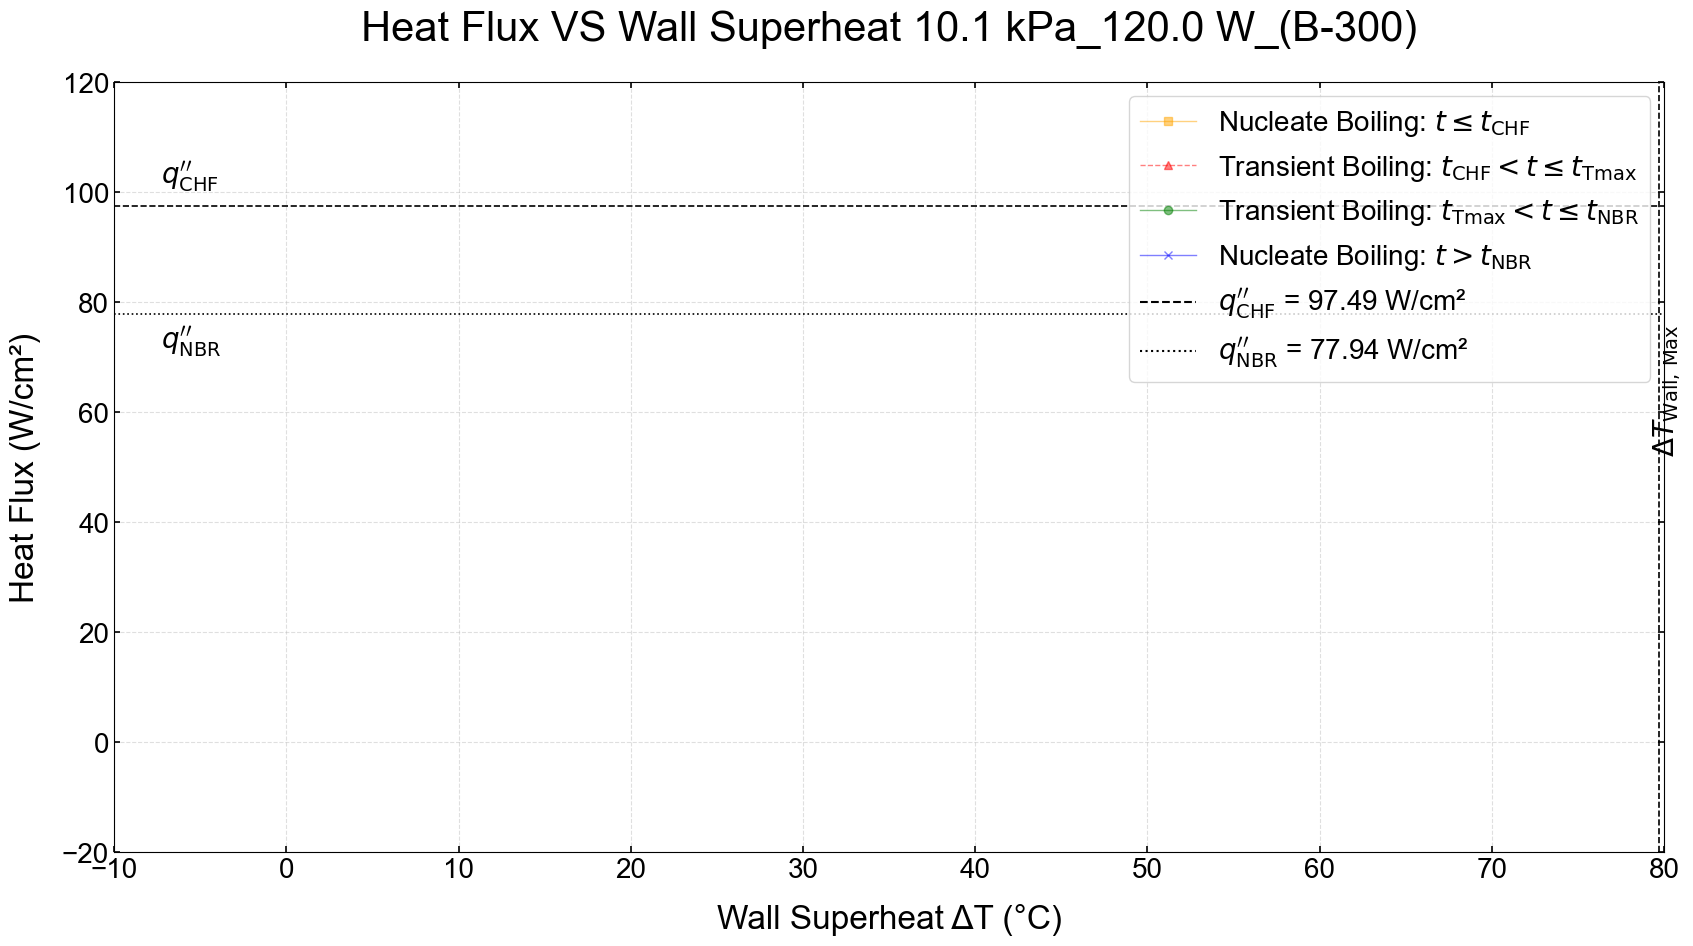

In [741]:
#**************************************************************************          Heat Flux vs Wall Superheat        ************************************************************************************

# Use the bundled ffmpeg (from imageio-ffmpeg)
mpl.rcParams['animation.ffmpeg_path'] = imageio_ffmpeg.get_ffmpeg_exe()

# -------- User controls --------
out_fps  = 15         # video frame rate
speedup  = 5.0        # playback speedup (e.g. 5x faster than real-time)
out_base = os.path.join(
    folder_path, f"14_HeatFlux_vs_WallSuperheat_animated_{pressure_mean_kPa}kPa_B-{boiling_id}"
)
os.makedirs(folder_path, exist_ok=True)

# -------- Key instants (your variables) --------
t_chf  = float(chf_time)
try:
    t_tmax = float(time_at_max_Surface_Temperature)
except NameError:
    t_tmax = float(time_temp[np.nanargmax(Surface_Temperature)])
t_nbr  = float(nbr_time)

# -------- Windowed time and masks --------
t_ws = np.asarray(time_temp[mask_ws_end])
t_ws = t_ws[np.argsort(t_ws)]
if t_ws.size < 2:
    raise ValueError("mask_ws_end has too few points for an animation.")

m_nb1_ws = mask_ws_end & (time_temp <= t_chf)                          # NB: t ≤ t_CHF
m_tb1_ws = mask_ws_end & (time_temp >  t_chf) & (time_temp <= t_tmax)  # TB: t_CHF < t ≤ t_Tmax
m_tb2_ws = mask_ws_end & (time_temp >  t_tmax) & (time_temp <= t_nbr)  # TB: t_Tmax < t ≤ t_NBR
m_nb2_ws = mask_ws_end & (time_temp >  t_nbr)                          # NB: t > t_NBR

# -------- Figure & styling --------
fig2, ax2 = plt.subplots(figsize=(20, 10))

line_nb1, = ax2.plot([], [], linestyle='-',  marker='s', markersize=6, linewidth=1, alpha=0.5,
                     color='orange', label=r'Nucleate Boiling: $t \leq t_{\mathrm{CHF}}$')
line_tb1, = ax2.plot([], [], linestyle='--', marker='^', markersize=6, linewidth=1, alpha=0.5,
                     color='red',    label=r'Transient Boiling: $t_{\mathrm{CHF}} < t \leq t_{\mathrm{Tmax}}$')
line_tb2, = ax2.plot([], [], linestyle='-',  marker='o', markersize=6, linewidth=1, alpha=0.5,
                     color='green',  label=r'Transient Boiling: $t_{\mathrm{Tmax}} < t \leq t_{\mathrm{NBR}}$')
line_nb2, = ax2.plot([], [], linestyle='-',  marker='x', markersize=6, linewidth=1, alpha=0.5,
                     color='blue',   label=r'Nucleate Boiling: $t > t_{\mathrm{NBR}}$')

ax2.set_xlabel("Wall Superheat ΔT (°C)", fontsize=24, fontname='Arial', labelpad=15)
ax2.set_ylabel("Heat Flux (W/cm²)",      fontsize=24, fontname='Arial', labelpad=15)
ax2.set_title(
    f"Heat Flux VS Wall Superheat {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})",
    fontsize=30, pad=30, fontname='Arial'
)
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True, width=1.2, length=4)
plt.xticks(fontsize=20, fontname='Arial')
plt.yticks(fontsize=20, fontname='Arial')

# -------- Axes ticks/limits (use your precomputed steps if available; else fallback) --------
try:
    # If you've already computed these elsewhere
    x_step = float(x_step_Wall_Superheat)
    xmin_w, xmax_w = float(ymin_Wall_Superheat), float(ymax_Wall_Superheat)
    x_tick_start = x_step * np.floor(xmin_w / x_step)
    x_tick_end   = x_step * np.ceil (xmax_w / x_step)
except Exception:
    x_step = 1.0
    dt_ws = delta_T[mask_ws_end]
    xmin_w = float(np.nanmin(dt_ws)); xmax_w = float(np.nanmax(dt_ws))
    x_tick_start = x_step * np.floor(xmin_w / x_step)
    x_tick_end   = x_step * np.ceil (xmax_w / x_step)

ax2.set_xlim(x_tick_start, x_tick_end)
ax2.set_xticks(np.arange(x_tick_start, x_tick_end+x_step, x_step))

try:
    y_step = float(y_step_q); ymin_qv = float(ymin_q); ymax_qv = float(ymax_q)
except Exception:
    q_ws = q[mask_ws_end]
    ymin_qv = float(np.nanmin(q_ws)); ymax_qv = float(np.nanmax(q_ws))
    rng = max(1e-6, ymax_qv - ymin_qv)
    y_step = 10.0 if rng > 60 else 5.0
y_tick_start = y_step * np.floor(ymin_qv / y_step)
y_tick_end   = y_step * np.ceil (ymax_qv / y_step)
ax2.set_ylim(y_tick_start, y_tick_end)
ax2.set_yticks(np.arange(y_tick_start, y_tick_end + 2*y_step, y_step))

# -------- Static reference lines & labels --------
q_chf = float(chf_value); q_nbr = float(nbr_value)
ax2.axhline(q_chf, linestyle='--', linewidth=1.2, color='black')
ax2.axhline(q_nbr, linestyle=':',  linewidth=1.2, color='black')

xmin_lbl, xmax_lbl = ax2.get_xlim()
xpos2 = lambda frac: xmin_lbl + frac * (xmax_lbl - xmin_lbl)
ax2.text(xpos2(0.03), q_chf + 2, r"$q^{\prime\prime}_{\mathrm{CHF}}$", fontsize=20, ha='left', va='bottom')
ax2.text(xpos2(0.03), q_nbr - 2, r"$q^{\prime\prime}_{\mathrm{NBR}}$", fontsize=20, ha='left', va='top')

max_Wall_Superheat = float(max_Surface_Temperature - T_sat)
ax2.axvline(max_Wall_Superheat, linestyle='--', linewidth=1.2, color='black')
ymin2, ymax2 = ax2.get_ylim()
ax2.text(max_Wall_Superheat + 0.5, ymin2 + 0.60*(ymax2 - ymin2),
         r"$\Delta T_{\mathrm{Wall,\,Max}}$", fontsize=20, rotation=90, ha='center', va='center')

# Legend (includes ghost entries for the two ref lines)
ax2.plot([], [], linestyle='--', color='black',
         label=r"$q^{\prime\prime}_{\mathrm{CHF}}$ = " + f"{q_chf:.2f} W/cm²")
ax2.plot([], [], linestyle=':',  color='black',
         label=r"$q^{\prime\prime}_{\mathrm{NBR}}$ = " + f"{q_nbr:.2f} W/cm²")
plt.legend(prop={'family':'Arial','size':20}, loc='upper right')

# -------- Animation data --------
real_duration = float(t_ws[-1] - t_ws[0])
video_duration = real_duration / speedup
frames = max(10, int(out_fps * video_duration))
frame_times = np.linspace(t_ws[0], t_ws[-1], frames)

def _subset(mask, t_cut):
    m = mask_ws_end & mask & (time_temp <= t_cut)
    return delta_T[m], q[m]   # x = ΔT, y = q

def _init():
    for ln in (line_nb1, line_tb1, line_tb2, line_nb2):
        ln.set_data([], [])
        # Optional speed tweaks:
        # ln.set_marker(None)
        # ln.set_antialiased(False)
    return line_nb1, line_tb1, line_tb2, line_nb2

def _update(i):
    t_cut = frame_times[i]
    line_nb1.set_data(*_subset(m_nb1_ws, t_cut))
    line_tb1.set_data(*_subset(m_tb1_ws, t_cut))
    line_tb2.set_data(*_subset(m_tb2_ws, t_cut))
    line_nb2.set_data(*_subset(m_nb2_ws, t_cut))
    return line_nb1, line_tb1, line_tb2, line_nb2

ani = FuncAnimation(fig2, _update, init_func=_init,
                    frames=frames, interval=1000.0/out_fps, blit=False)

# -------- Save MP4 --------
writer = FFMpegWriter(fps=out_fps, bitrate=1000, extra_args=['-preset','ultrafast','-crf','28'])
mp4_path = out_base + ".mp4"
ani.save(mp4_path, writer=writer, dpi=80)
print("Saved MP4:", mp4_path)

#### Boiling Curve: HTC VS Heat Flux 

In [ ]:
#**************************************************************************     Boiling Curve: HTC VS Heat Flux        ************************************************************************************

mpl.rcParams['animation.ffmpeg_path'] = imageio_ffmpeg.get_ffmpeg_exe()

# ------------------- USER SPEED/OUTPUT SETTINGS -------------------
out_fps   = 15           # frame rate of the video
speedup   = 5.0        # playback speedup (3× faster than real time)
out_base  = os.path.join(folder_path,   # you already define base_dir/folder_path
    f"19_Boiling_Curve_animated_{pressure_mean_kPa}kPa_B-{boiling_id}"
)
os.makedirs(folder_path, exist_ok=True)

# -------------------- TIME INSTANTS (your variables) --------------------
t_chf  = float(chf_time)
try:
    t_tmax = float(time_at_max_Surface_Temperature)
except NameError:
    t_tmax = float(time_temp[np.nanargmax(Surface_Temperature)])
t_nbr  = float(nbr_time)

# -------------------- WINDOWED TIME + REGIME MASKS ---------------------
t_ws = np.asarray(time_temp[mask_ws_end])
t_ws = t_ws[np.argsort(t_ws)]  # ensure monotonic
if t_ws.size < 2:
    raise ValueError("mask_ws_end has too few points for an animation.")

m_nb1_ws = mask_ws_end & (time_temp <= t_chf)                         # NB:  t ≤ t_CHF
m_tb1_ws = mask_ws_end & (time_temp >  t_chf) & (time_temp <= t_tmax) # TB:  t_CHF < t ≤ t_Tmax
m_tb2_ws = mask_ws_end & (time_temp >  t_tmax) & (time_temp <= t_nbr) # TB:  t_Tmax < t ≤ t_NBR
m_nb2_ws = mask_ws_end & (time_temp >  t_nbr)                         # NB:  t > t_NBR

# -------------------- FIGURE & STATIC STYLING ---------------------------
fig, ax = plt.subplots(figsize=(20, 10))
line_nb1, = ax.plot([], [], linestyle='-',  marker='s', markersize=6, linewidth=1, alpha=0.5,
                    color='orange', label=r'Nucleate Boiling: $t \leq t_{\mathrm{CHF}}$')
line_tb1, = ax.plot([], [], linestyle='--', marker='^', markersize=6, linewidth=1, alpha=0.5,
                    color='red',    label=r'Transient Boiling: $t_{\mathrm{CHF}} < t \leq t_{\mathrm{Tmax}}$')
line_tb2, = ax.plot([], [], linestyle='-',  marker='o', markersize=6, linewidth=1, alpha=0.5,
                    color='green',  label=r'Transient Boiling: $t_{\mathrm{Tmax}} < t \leq t_{\mathrm{NBR}}$')
line_nb2, = ax.plot([], [], linestyle='-',  marker='x', markersize=6, linewidth=1, alpha=0.5,
                    color='blue',   label=r'Nucleate Boiling: $t > t_{\mathrm{NBR}}$')

ax.set_xlabel("Heat Flux (W/cm²)", fontsize=24, fontname='Arial', labelpad=15)
ax.set_ylabel("HTC (W/cm²·K)",     fontsize=24, fontname='Arial', labelpad=15)
ax.set_title(f" Boiling Curve at {pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})",
             fontsize=30, pad=30, fontname='Arial')
ax.grid(True, linestyle='--', alpha=0.4)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, width=1.2, length=4)
plt.xticks(fontsize=20, fontname='Arial'); plt.yticks(fontsize=20, fontname='Arial')
plt.legend(prop={'family':'Arial','size':20}, loc='upper left')

# ---- Ticks/limits (use your precomputed ranges if available; else derive) ----
try:
    # your existing tick variables
    x_step = float(x_step_q)
    xmin_q, xmax_q = float(ymin_q), float(ymax_q)   # you used these names earlier
    x_tick_start = x_step * np.floor(xmin_q / x_step)
    x_tick_end   = x_step * np.ceil (xmax_q / x_step)
    try:
        y_step = float(y_step_htc); ymin_htc = float(htc_MIN_ws_to_end); ymax_htc = float(htc_MAX_ws_to_end)
    except NameError:
        raise
except Exception:
    # robust fallback from windowed data
    x_step = 10.0
    q_ws = q[mask_ws_end]
    #x_tick_start = x_step * np.floor(np.nanmin(q_ws)/x_step)
    x_tick_start = 0
    x_tick_end   = x_step * np.ceil (np.nanmax(q_ws)/x_step)
    ymin_htc = float(np.nanmin(htc[mask_ws_end])); ymax_htc = float(np.nanmax(htc[mask_ws_end]))
    # choose a sensible y step
    y_range = max(1e-6, ymax_htc - ymin_htc)
    y_step = 0.2 if y_range <= 3 else 0.5

ax.set_xlim(0, x_tick_end)
ax.set_xticks(np.arange(0, x_tick_end + x_step, x_step))
y_tick_start = y_step * np.floor(ymin_htc / y_step)
y_tick_end   = y_step * np.ceil (ymax_htc / y_step)
ax.set_ylim(y_tick_start, y_tick_end)
ax.set_yticks(np.arange(y_tick_start, y_tick_end + y_step, y_step))

# -------------------- ANIMATION DATA --------------------
# number of frames so that final video duration = real duration / speedup
real_duration = float(t_ws[-1] - t_ws[0])
video_duration = real_duration / speedup
frames = max(10, int(out_fps * video_duration))
frame_times = np.linspace(t_ws[0], t_ws[-1], frames)

def _subset(mask, t_cut):
    m = mask_ws_end & mask & (time_temp <= t_cut)
    return q[m], htc[m]   # x = q, y = htc

def _init():
    for ln in (line_nb1, line_tb1, line_tb2, line_nb2):
        ln.set_data([], [])
    return line_nb1, line_tb1, line_tb2, line_nb2

def _update(i):
    t_cut = frame_times[i]
    line_nb1.set_data(*_subset(m_nb1_ws, t_cut))
    line_tb1.set_data(*_subset(m_tb1_ws, t_cut))
    line_tb2.set_data(*_subset(m_tb2_ws, t_cut))
    line_nb2.set_data(*_subset(m_nb2_ws, t_cut))
    return line_nb1, line_tb1, line_tb2, line_nb2

ani = FuncAnimation(fig, _update, init_func=_init,
                    frames=frames, interval=1000.0/out_fps, blit=False)

# -------------------- SAVE AS MP4 --------------------
writer = FFMpegWriter(fps=out_fps, bitrate=1000,
                      extra_args=['-preset','ultrafast','-crf','28'])
mp4_path = out_base + ".mp4"
ani.save(mp4_path, writer=writer, dpi=80)
print("Saved MP4:", mp4_path)

####  Comparison with MagnaDC Power

In [ ]:
#*************************************************************************       Comparison with MagnaDC Power           ******************************************************************************************
# Make sure ffmpeg is discoverable by Matplotlib
mpl.rcParams['animation.ffmpeg_path'] = imageio_ffmpeg.get_ffmpeg_exe()

# ------------------- USER SPEED/OUTPUT SETTINGS -------------------
out_fps = 15          # frame rate of the video
speedup = 5.0         # playback speedup (3× faster than real time)
DPI     = 80       # render DPI (tweak for speed/quality)

# Where to save
out_base = os.path.join(
    folder_path,
    f"30_Comparison_and_MagnaDC_animated_{pressure_mean_kPa}kPa_{applied_heat_load}W_B-{boiling_id}"
)
os.makedirs(folder_path, exist_ok=True)

# =======================
# Your original plotting
# =======================
if has_dc:
    fig, ax1 = plt.subplots(figsize=(20,10))

    # --- 🔴 Left Y-axis: Heat Flux (+ Power on same axis) ---
    ax1.set_xlabel('Time (s)', fontsize=24, fontname='Arial')
    ax1.set_ylabel('Heat Flux (W/cm²)', color='red', fontsize=24, fontname='Arial')
    l1, = ax1.plot(time_temp, q, color='red', label='Heat Flux', linewidth=2)

    # ✅ Output Power on SAME left Y-axis
    if 'has_dc' not in globals() or has_dc:
        l4, = ax1.plot(time_dc, Power_Watts, color='orange', linewidth=2, label='Output Power (W)')
    else:
        l4 = None

    ax1.tick_params(axis='x', labelcolor='black', labelsize=16)
    ax1.tick_params(axis='y', labelcolor='red',   labelsize=16)

    # CHF time line on shared x
    ax1.axvline(x=chf_time, color='teal', linestyle='--', linewidth=2, alpha=0.2, label='CHF Time')

    # Only bottom x-ticks & only left y-ticks
    ax1.tick_params(axis='x', which='both', bottom=True, top=False,  direction='in', width=1.2, length=4)
    ax1.tick_params(axis='y', which='both', left=True,  right=False, direction='in', width=1.2, length=4)

    # ax1.set_xlim(0, 600)

    # --- 🔵 Second Y-axis (right): HTC ---
    ax2 = ax1.twinx()
    ax2.set_ylabel('HTC (W/cm²·K)', color='blue', fontsize=24, fontname='Arial')
    l2, = ax2.plot(time_temp, htc, color='blue', label='HTC', linewidth=2)
    ax2.tick_params(axis='y', labelcolor='blue', labelsize=16)
    ax2.tick_params(axis='y', which='both', direction='in', left=False, right=True, width=1.2)
    ax2.set_ylim(y_bottom, y_top)
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

    # --- 🟢 Third Y-axis (right): Surface Temperature ---
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 70))
    ax3.set_ylabel('Surface Temperature (°C)', color='green', fontsize=24, fontname='Arial')
    l3, = ax3.plot(time_temp, Surface_Temperature, color='green', label='Surface Temperature', linewidth=2)
    ax3.tick_params(axis='y', labelcolor='green', labelsize=16)
    ax3.tick_params(axis='y', which='both', direction='in', left=False, right=True, width=1.2, length=4)

    # ---- X-axis limits & ticks (50 s grid) ----
    tmin = float(np.nanmin(time_temp))
    tmax = float(np.nanmax(time_temp))
    # include DC time if present
    if 'has_dc' not in globals() or has_dc:
        tmin = min(tmin, float(np.nanmin(time_dc)))
        tmax = max(tmax, float(np.nanmax(time_dc)))

    x_step = 50
    x_tick_start = x_step * np.floor(tmin / x_step)
    x_tick_end   = x_step * np.ceil (tmax / x_step)
    if x_tick_end <= tmax:
        x_tick_end += x_step
    ax1.set_xlim(x_tick_start, x_tick_end)
    ax1.set_xticks(np.arange(x_tick_start, x_tick_end + x_step, x_step))

    # ---- LEFT Y ticks/limits must cover BOTH Heat Flux and Power ----
    if 'has_dc' not in globals() or has_dc:
        combined_min = float(np.nanmin([np.nanmin(q), np.nanmin(Power_Watts)]))
        combined_max = float(np.nanmax([np.nanmax(q), np.nanmax(Power_Watts)]))
    else:
        combined_min = float(np.nanmin(q))
        combined_max = float(np.nanmax(q))

    y_step = 20
    y_tick_start = y_step * np.floor(combined_min / y_step)
    y_tick_end   = y_step * np.ceil (combined_max / y_step)
    if y_tick_end <= combined_max:
        y_tick_end += y_step
    ax1.set_ylim(y_tick_start, y_tick_end)
    ax1.set_yticks(np.arange(y_tick_start, y_tick_end + y_step, y_step))

    ## HTC y-axis ticks ##
    y_tick_start = y_step_htc * np.floor(htc_MIN_ws_to_end / y_step_htc)
    y_tick_end   = y_step_htc * np.ceil (htc_MAX_ws_to_end / y_step_htc)
    if y_tick_start >= htc_MIN_ws_to_end:
        y_tick_start -= y_step_htc
    if y_tick_end <= htc_MAX_ws_to_end:
        y_tick_end += y_step_htc
    ax2.set_ylim(y_tick_start - y_step_htc, y_tick_end)
    ax2.set_yticks(np.arange(y_tick_start - 2*y_step_htc, y_tick_end + 2*y_step_htc, y_step_htc))

    # ---- Surface Temperature (ax3) ticks/limits ----
    st_min = float(np.nanmin(Surface_Temperature))
    st_max = float(np.nanmax(Surface_Temperature))
    st_step = 20
    st_tick_start = st_step * np.floor(st_min / st_step)
    st_tick_end   = st_step * np.ceil (st_max / st_step)
    if st_tick_end <= st_max:
        st_tick_end += st_step
    ax3.set_ylim(st_tick_start, st_tick_end)
    ax3.set_yticks(np.arange(st_tick_start, st_tick_end + st_step, st_step))

    # Title, grid, legend
    plt.title(f"Comparison_{pressure_mean_kPa} kPa_{applied_heat_load} W_(B-{boiling_id})",
              fontsize=28, pad=30, fontname='Arial')
    ax1.grid(True, linestyle='--', alpha=0.5)

    lines  = [l for l in (l1, l2, l3, l4) if l is not None]
    labels = [ln.get_label() for ln in lines]
    ax1.legend(lines, labels, loc='upper right', fontsize=20)

    plt.tight_layout()

    # ======================
    # Animation (time sweep)
    # ======================

    # Pre-sort time bases (robust even if already sorted)
    t_q   = np.asarray(time_temp)
    y_q   = np.asarray(q)
    t_htc = np.asarray(time_temp)
    y_htc = np.asarray(htc)
    t_t   = np.asarray(time_temp)
    y_t   = np.asarray(Surface_Temperature)

    # Power can be a different time base
    if l4 is not None:
        t_p = np.asarray(time_dc)
        y_p = np.asarray(Power_Watts)

    # Determine global time span for animation
    t_start = float(np.nanmin([t_q.min(), t_htc.min(), t_t.min()] + ([t_p.min()] if l4 is not None else [])))
    t_end   = float(np.nanmax([t_q.max(), t_htc.max(), t_t.max()] + ([t_p.max()] if l4 is not None else [])))

    real_duration  = max(1e-9, t_end - t_start)
    video_duration = real_duration / speedup
    frames = max(10, int(out_fps * video_duration))
    frame_times = np.linspace(t_start, t_end, frames)

    # Fast index slicing via searchsorted
    def set_prog(t_cut, t_arr, y_arr, line):
        idx = np.searchsorted(t_arr, t_cut, side='right')
        line.set_data(t_arr[:idx], y_arr[:idx])

    def _init():
        l1.set_data([], [])
        l2.set_data([], [])
        l3.set_data([], [])
        if l4 is not None:
            l4.set_data([], [])
        return (l1, l2, l3) if l4 is None else (l1, l2, l3, l4)

    def _update(i):
        t_cut = frame_times[i]
        set_prog(t_cut, t_q,   y_q,   l1)   # Heat Flux (left)
        set_prog(t_cut, t_htc, y_htc, l2)   # HTC (right)
        set_prog(t_cut, t_t,   y_t,   l3)   # Surface Temp (right, offset)
        if l4 is not None:
            set_prog(t_cut, t_p, y_p, l4)   # Power (left)
        return (l1, l2, l3) if l4 is None else (l1, l2, l3, l4)

    ani = FuncAnimation(fig, _update, init_func=_init,
                        frames=frames, interval=1000.0/out_fps, blit=False)

    # Save MP4
    writer = FFMpegWriter(fps=out_fps, bitrate=2000,
                          extra_args=['-preset','ultrafast','-crf','28'])
    fig.set_dpi(DPI)
    mp4_path = out_base + ".mp4"
    ani.save(mp4_path, writer=writer, dpi=DPI)
    print("Saved MP4:", mp4_path)

    
    plt.show()

else:
    print("⏭️ Skipping DC plot: DC_power.lvm not found.")